In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

from collections import defaultdict

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, auc,roc_curve,accuracy_score, f1_score, roc_auc_score, log_loss,cohen_kappa_score, classification_report, plot_confusion_matrix, recall_score, precision_score, matthews_corrcoef,make_scorer
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE
from imblearn.under_sampling import ClusterCentroids,RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier

from sklearn.naive_bayes import GaussianNB,ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier

from statistics import mean
from functools import partial
from scipy.stats import loguniform

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('seaborn-whitegrid')

# global configuration

In [8]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.3f}'.format
random_state = 2021

# Useful fuctions

In [9]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int'or str(col_type)[:3] == 'uin':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [10]:
def plot_target_distribution(model,testing_x):
    
    plt.figure(figsize=(10,10), dpi=150)
    predictions_prob = model.predict_proba(testing_x).reshape(1, -1)
    plt.hist(predictions_prob, 1000)

In [11]:
def model_report(model,testing_x,testing_y,name,customerized_threshold=False,threshold=0.5) :

    predictions  = model.predict(testing_x)
    predictions_prob = model.predict_proba(testing_x)
    
    if customerized_threshold:
        predictions = []
        for pred in predictions_prob[:,1]:  
            predictions.append(1) if pred > threshold else predictions.append(0) 
    recallscore  = recall_score(testing_y,predictions)
    precision    = precision_score(testing_y,predictions)
    roc_auc      = roc_auc_score(testing_y,predictions_prob[:, 1])
    f1score      = f1_score(testing_y,predictions) 
    kappa_metric = cohen_kappa_score(testing_y,predictions)
    MCC          = matthews_corrcoef(testing_y, predictions)
    
    
    # classification_report
    print(classification_report(testing_y,predictions))
    
    # customered_confusion_matrix
    
    fact = testing_y
    classes = list(set(fact))
    classes.sort()
    confusion = confusion_matrix(predictions, testing_y)
    plt.figure(figsize=(10,10), dpi=150)
    plt.imshow(confusion, cmap=plt.cm.Blues)
#     plt.imshow(confusion, cmap="viridis")
    indices = range(len(confusion))
    plt.xticks(indices, classes,fontsize=20)
    plt.yticks(indices, classes,fontsize=20)
    plt.colorbar()
    plt.xlabel('Predictions',fontsize=20)
    plt.ylabel('Ground Turth',fontsize=20)
    for first_index in range(len(confusion)):
        for second_index in range(len(confusion[first_index])):
            plt.text(first_index, second_index, confusion[first_index][second_index],va = 'center',ha = 'center',c='darkorange',fontsize=20)
    plt.grid(False)

    # default_confusion_matrix
    plot_confusion_matrix(model, testing_x,testing_y)
    plt.grid(False)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                       "MCC"             : [MCC]
                      })
    return df

In [12]:
def find_best_threshold(start, end, model,testing_x,testing_y):
    predictions_prob = model.predict_proba(testing_x)
    x = []
    y = []
    for threshold in np.arange(start, end, 0.01):
        predictions = []
        x.append(threshold)
        
        for pred in predictions_prob[:,1]:  
            predictions.append(1) if pred > threshold else predictions.append(0)
        MCC = matthews_corrcoef(testing_y, predictions)
        y.append(MCC)
        print(f"threshold:{threshold:0.3f} --->MCC:{MCC:0.3f}")
    plt.style.use('seaborn-whitegrid')
    plt.figure()
    plt.scatter(x, y)
    plt.xlim([0, 1])
    plt.ylim([0.3, 0.7])
    plt.xlabel('Thresholds')
    plt.ylabel('MCC')
    plt.title('Performance with Different Thresholds')
    plt.show()
    
    return x[y.index(max(y))]

In [13]:
def compute_and_plot_roc_curve(model, testing_x, testing_y,name):
    predict_prob = model.predict_proba(testing_x)
    fpr, tpr, threshold = metrics.roc_curve(testing_y, predict_prob[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(figsize=(10,10),facecolor="white")
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = '{} : {:0.3f}'.format(name,roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return fpr, tpr, roc_auc

# EDA

In [2]:
bank = pd.read_csv("bank-full.csv", sep=";")

In [3]:
bank

age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  duration  campaign  pdays  previous poutcome    y  
0        unknown    5   may       261         1     -1         0  unknown   no  
1        unknown    5   may       151         1     -1         0  unknown   no  
2        unknown    5   may        76         1     -1         0  unknown   no  
3        unknown    5   may        92         1     -1         0  unknown   no  
4        unknown    5   may       198         1     -1         0  unknown   no  
...          ...  ...   ...       ...       ...    ...       ...      ...  ...  
45206   cellular   17   nov       977         3     -1         0  unknown  yes  
45207   cellular   17   nov       456         2     -1         0  unknown  yes  
45208   cellular   17   nov      1127         5    184         3  success  yes  
45209  telephone   17   nov       508         4     -1         0  unknown   no  
45210   cellular   17   nov       361         2    188        11    other   no  

[45211 rows x 17 columns]

In [4]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
for i in list(bank.columns):
    print(f"{i:<10}->  {bank[i].nunique():<5} unique values")

age       ->  77    unique values
job       ->  12    unique values
marital   ->  3     unique values
education ->  4     unique values
default   ->  2     unique values
balance   ->  7168  unique values
housing   ->  2     unique values
loan      ->  2     unique values
contact   ->  3     unique values
day       ->  31    unique values
month     ->  12    unique values
duration  ->  1573  unique values
campaign  ->  48    unique values
pdays     ->  559   unique values
previous  ->  41    unique values
poutcome  ->  4     unique values
y         ->  2     unique values


In [6]:
bank_int = list(bank.select_dtypes(include = ['int64']).columns)
bank_str = list(bank.select_dtypes(include = ['object']).columns)
bank_str.remove("y")
bank_categorical = bank_str+['day']

In [7]:
bank_categorical

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'day']

In [8]:
# cleaning `pdays`
bank['pdays'][bank["pdays"]==-1]=0
bank["first_contact"] = 0
bank['first_contact'][bank['pdays']==0]=1

In [21]:
# cleaning `balance`
sum(bank['balance']<0)

3766

##  log2

In [6]:
# Just comment out this cell if you don't need log transformation

# for i in ['balance', 'duration', 'campaign', 'pdays', 'previous']:
#     bank[i] = np.log2(bank[i])
#     bank[i][bank[i]==float('-inf')]=-1
# bank['balance'].fillna(-1, inplace=True)

In [23]:
for i in bank_int:
    print(f'zeros in {i}: {sum(bank[i]==0)}')

zeros in age: 0
zeros in balance: 3514
zeros in day: 0
zeros in duration: 3
zeros in campaign: 0
zeros in pdays: 36954
zeros in previous: 36954


## target

No:  39922 88.30%
Yes: 5289  11.70%


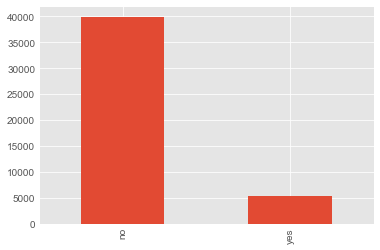

In [24]:
plt.style.use('ggplot')
bank.y.value_counts().plot(kind = "bar")
n = bank['y'].value_counts()[0]
y = bank['y'].value_counts()[1]
print('No:  %d %.2f%%' % (n,n/(n+y)*100))
print('Yes: %d  %.2f%%' % (y,y/(n+y)*100))

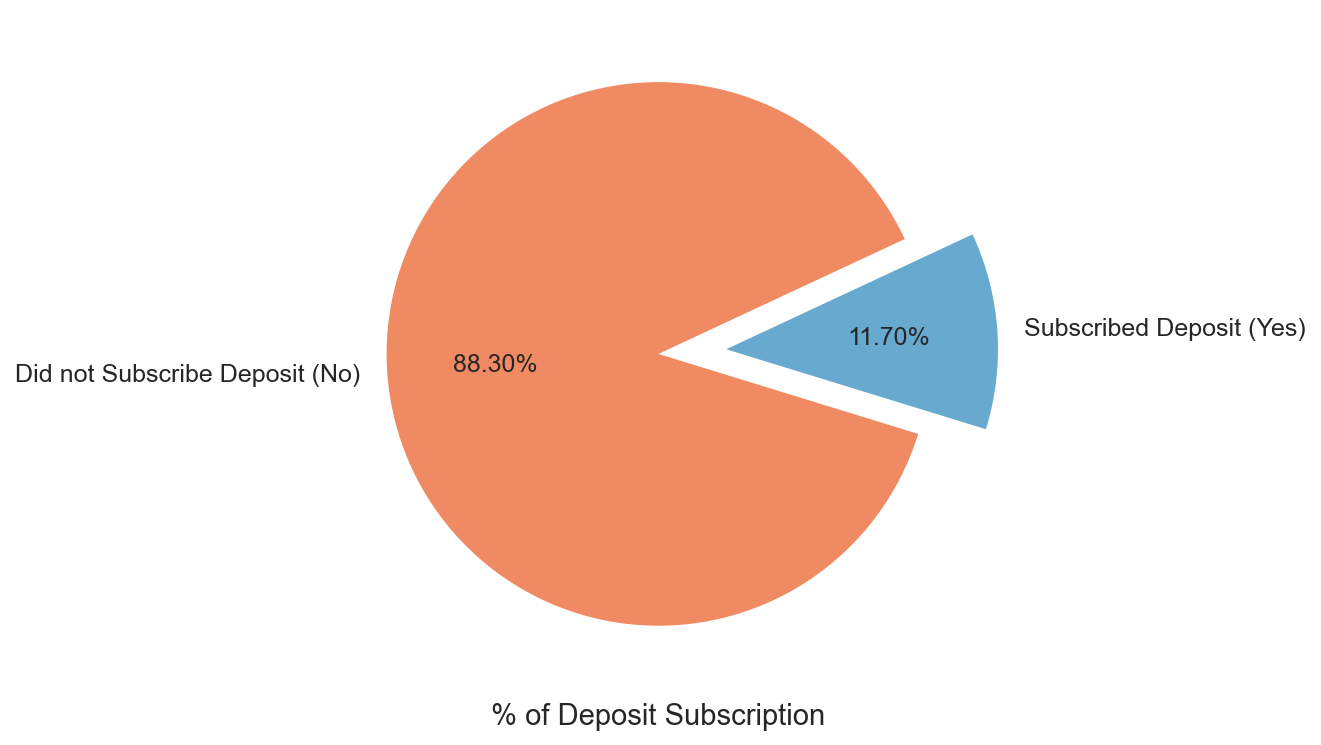

In [5]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

f, ax = plt.subplots(figsize=(12,6))
colors = ["#ef8a62", "#67a9cf"]
labels ="Did not Subscribe Deposit (No)", "Subscribed Deposit (Yes)"

bank['y'].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax, shadow=False, colors=colors, 
                                             labels=labels, fontsize=12, startangle=25)

ax.set_ylabel('')
ax.set_xlabel('% of Deposit Subscription', fontsize=14)
plt.show()

In [25]:
# print("Categorical Variables Visualization")
# fig, axes = plt.subplots(3, 3, figsize=(20, 12))
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.3)
# for i, ax in enumerate(axes.ravel()):
#     if i > 9:
#         ax.set_visible(False)
#         continue
#     sns.countplot(y = bank_str[i], data = bank, ax = ax)
# plt.show()

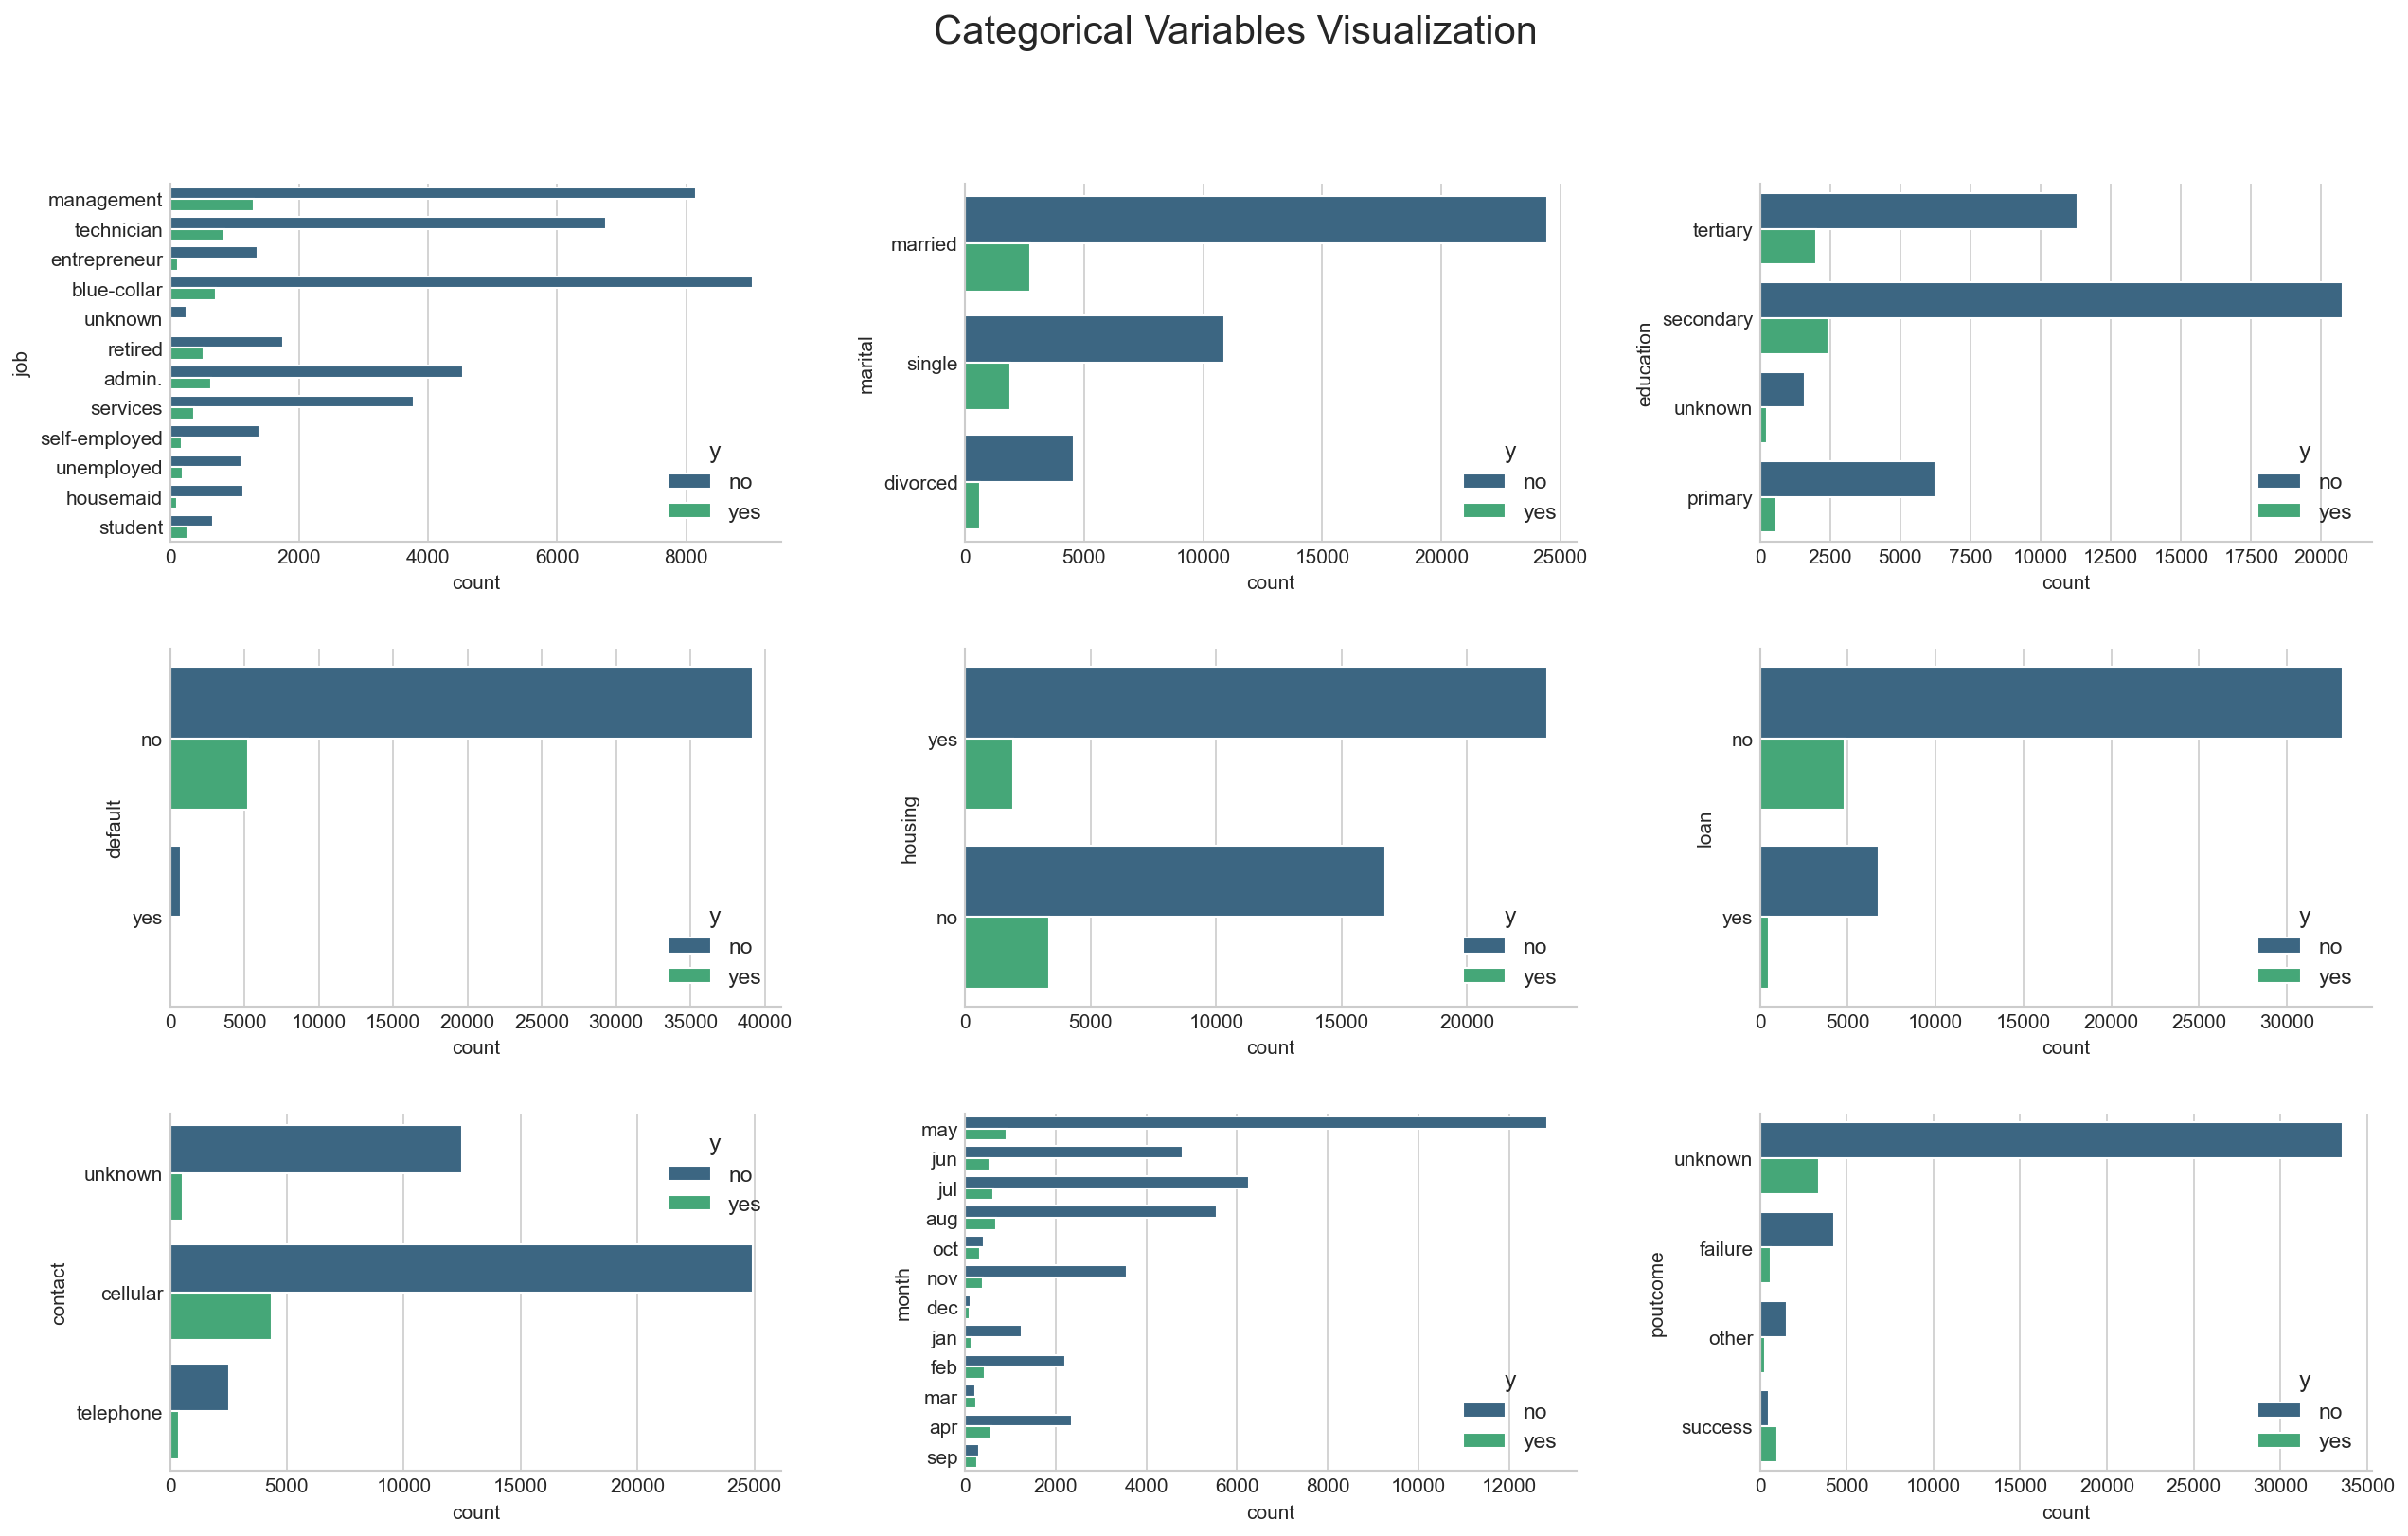

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
plt.suptitle('Categorical Variables Visualization', fontsize=20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
for i, ax in enumerate(axes.ravel()):
    if i > 9:
        ax.set_visible(False)
        continue
    sns.set_theme(style="white")
    sns.countplot(y = bank_str[i], data = bank,hue='y', ax = ax, palette="viridis")    
    sns.despine()
    
plt.show()

In [9]:
def get_y_ratio_plot(x,axes):
    ratio = bank[bank['y']=="yes"].groupby(x).count()['y']/(bank.groupby(x).count()['y'])
    ratio = np.array(ratio)
    size = np.arange(ratio.size)
    
    ax = sns.barplot(x=size,y=ratio,palette="viridis", ax=axes)
    sns.despine()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xticklabels(sorted(bank[x].unique()))
    ax.set_title(x)
    
    return ax

In [9]:
avg_duration = bank['duration'].mean()
lst = [bank]
bank["duration_status"] = np.nan

for col in lst:
    col.loc[col["duration"] < avg_duration, "duration_status"] = "below_average"
    col.loc[col["duration"] > avg_duration, "duration_status"] = "above_average"
    
bank['age_cate'] = pd.cut(bank['age'], bins=[0, 35, 55, 70, float('Inf')], labels=['0-35', '25-55', '55-70', '70-95'])

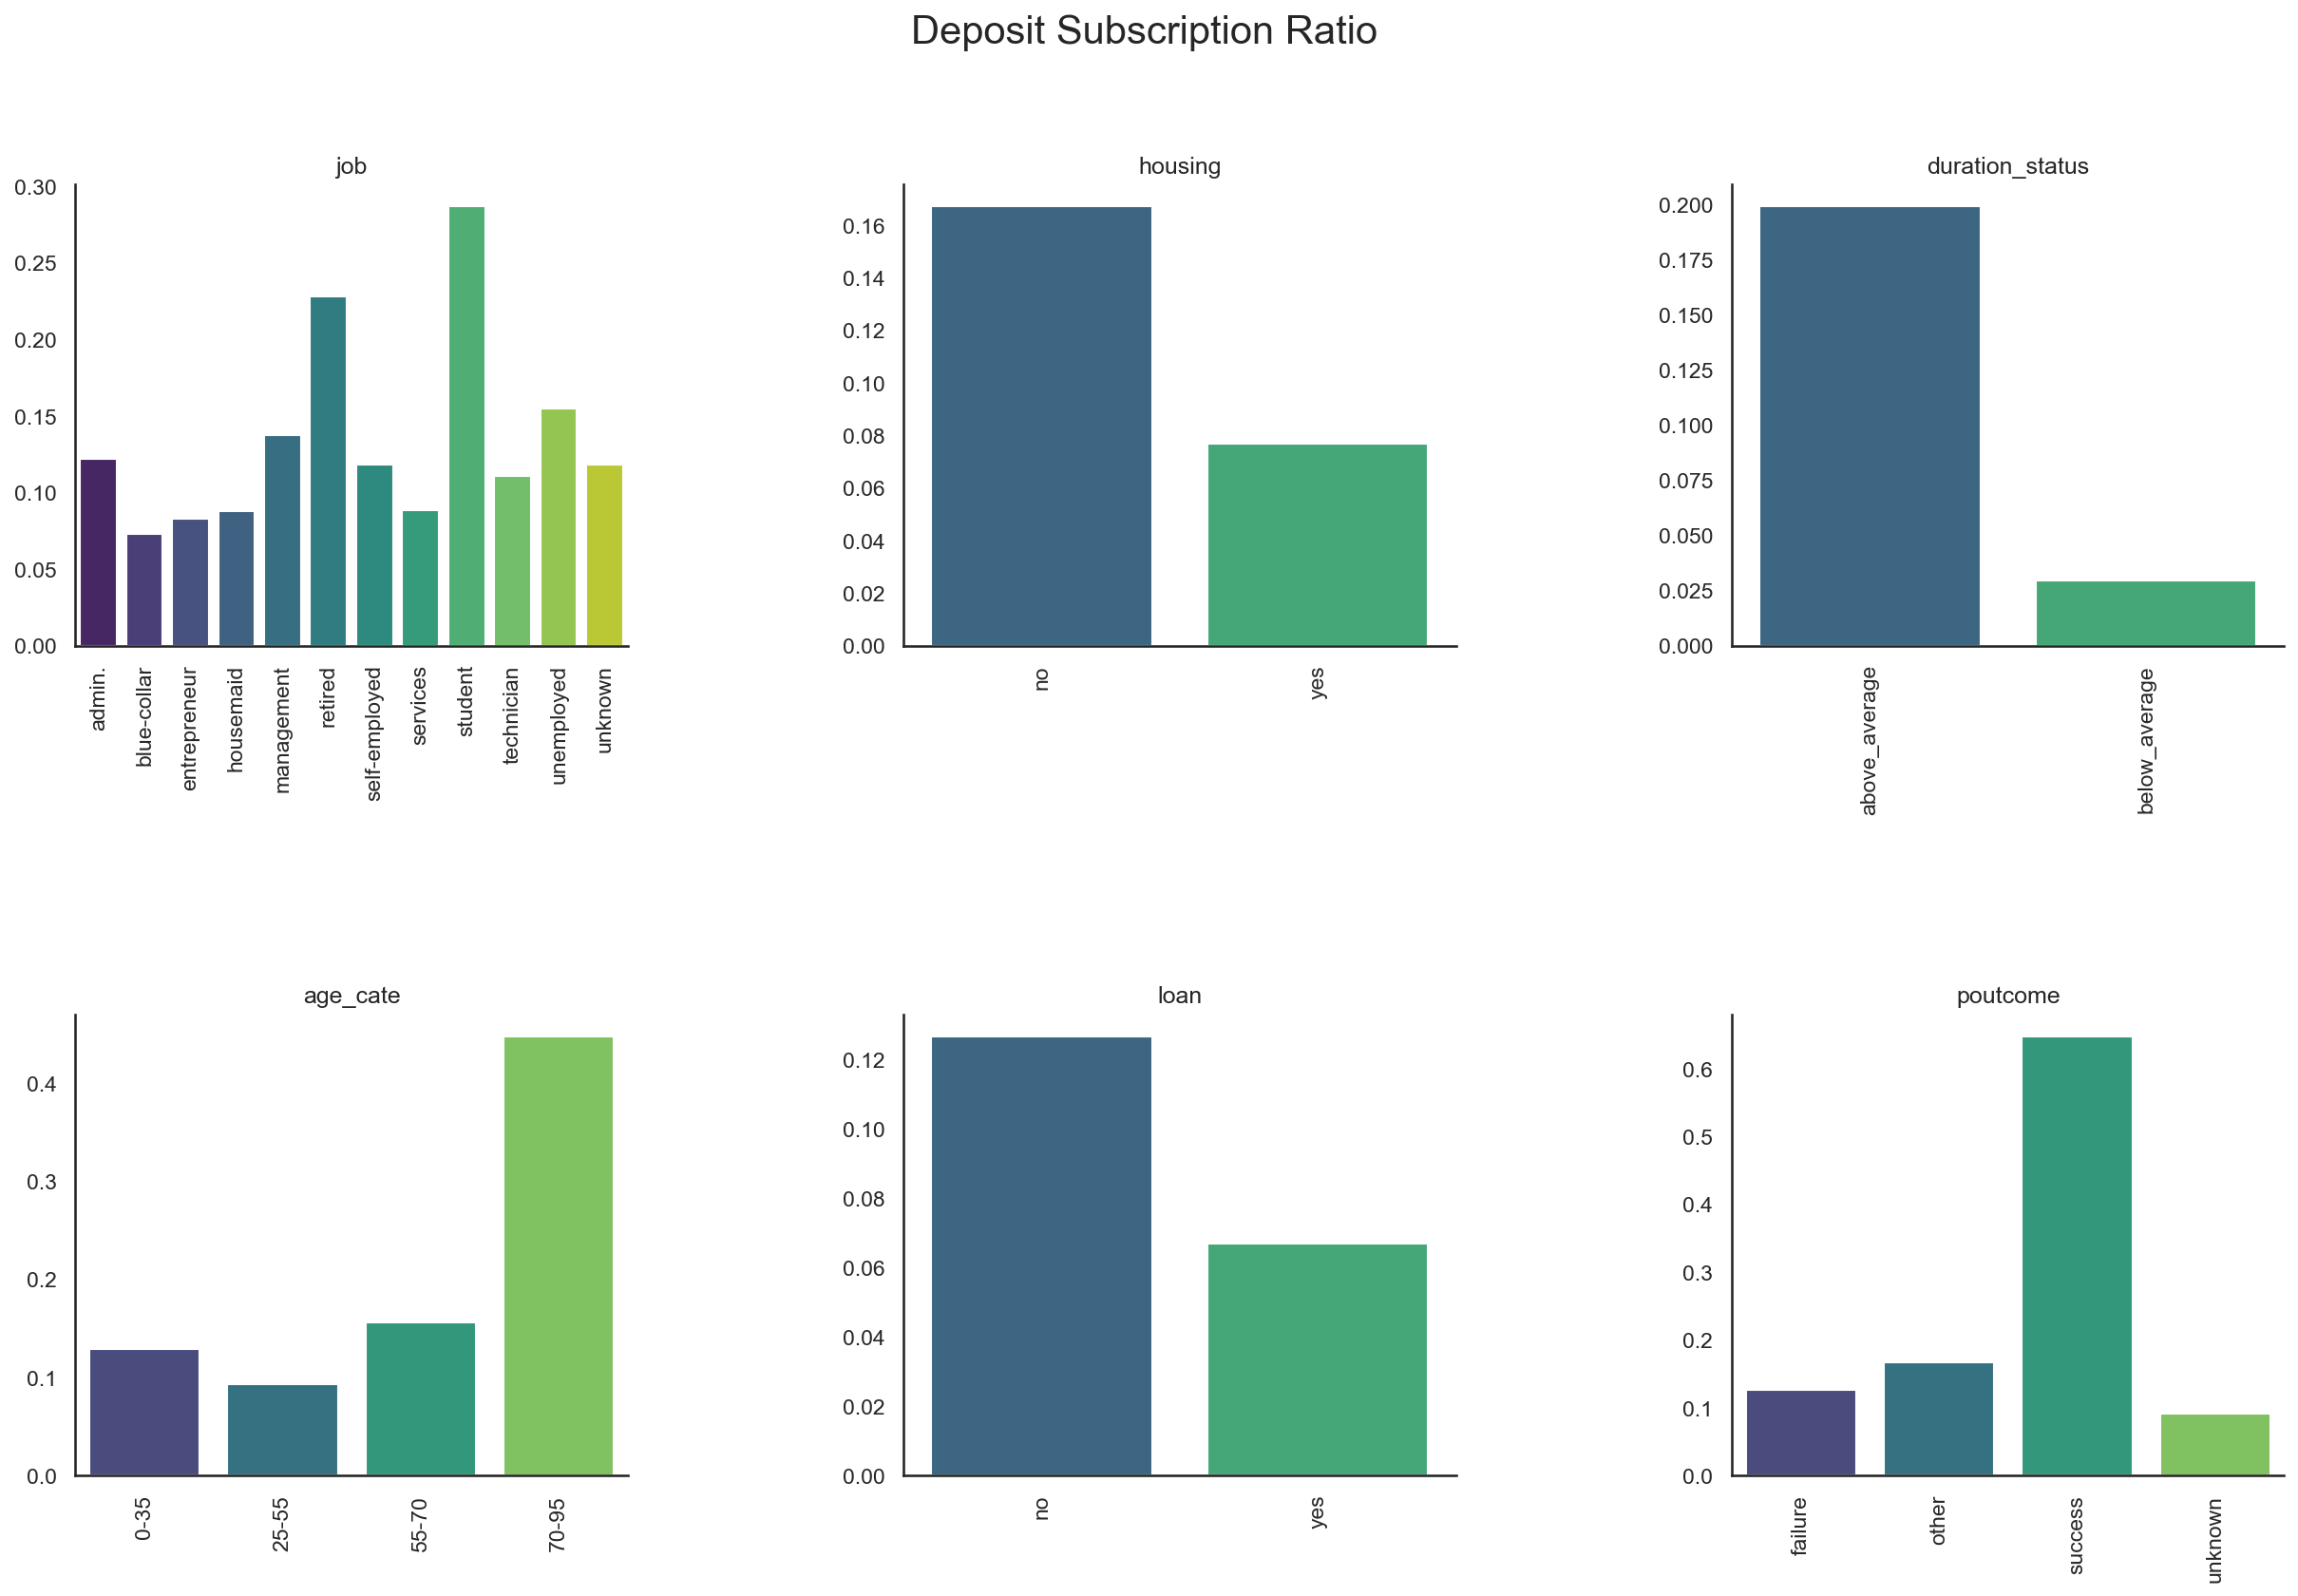

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
plt.suptitle('Deposit Subscription Ratio', fontsize=20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.8)

get_y_ratio_plot('job',axes[0,0])
get_y_ratio_plot('housing',axes[0,1])
get_y_ratio_plot('duration_status',axes[0,2])
get_y_ratio_plot('age_cate',axes[1,0])
get_y_ratio_plot('loan',axes[1,1])
get_y_ratio_plot('poutcome',axes[1,2])

plt.show()

## Continuous Variables

Continuous Variables Visualization


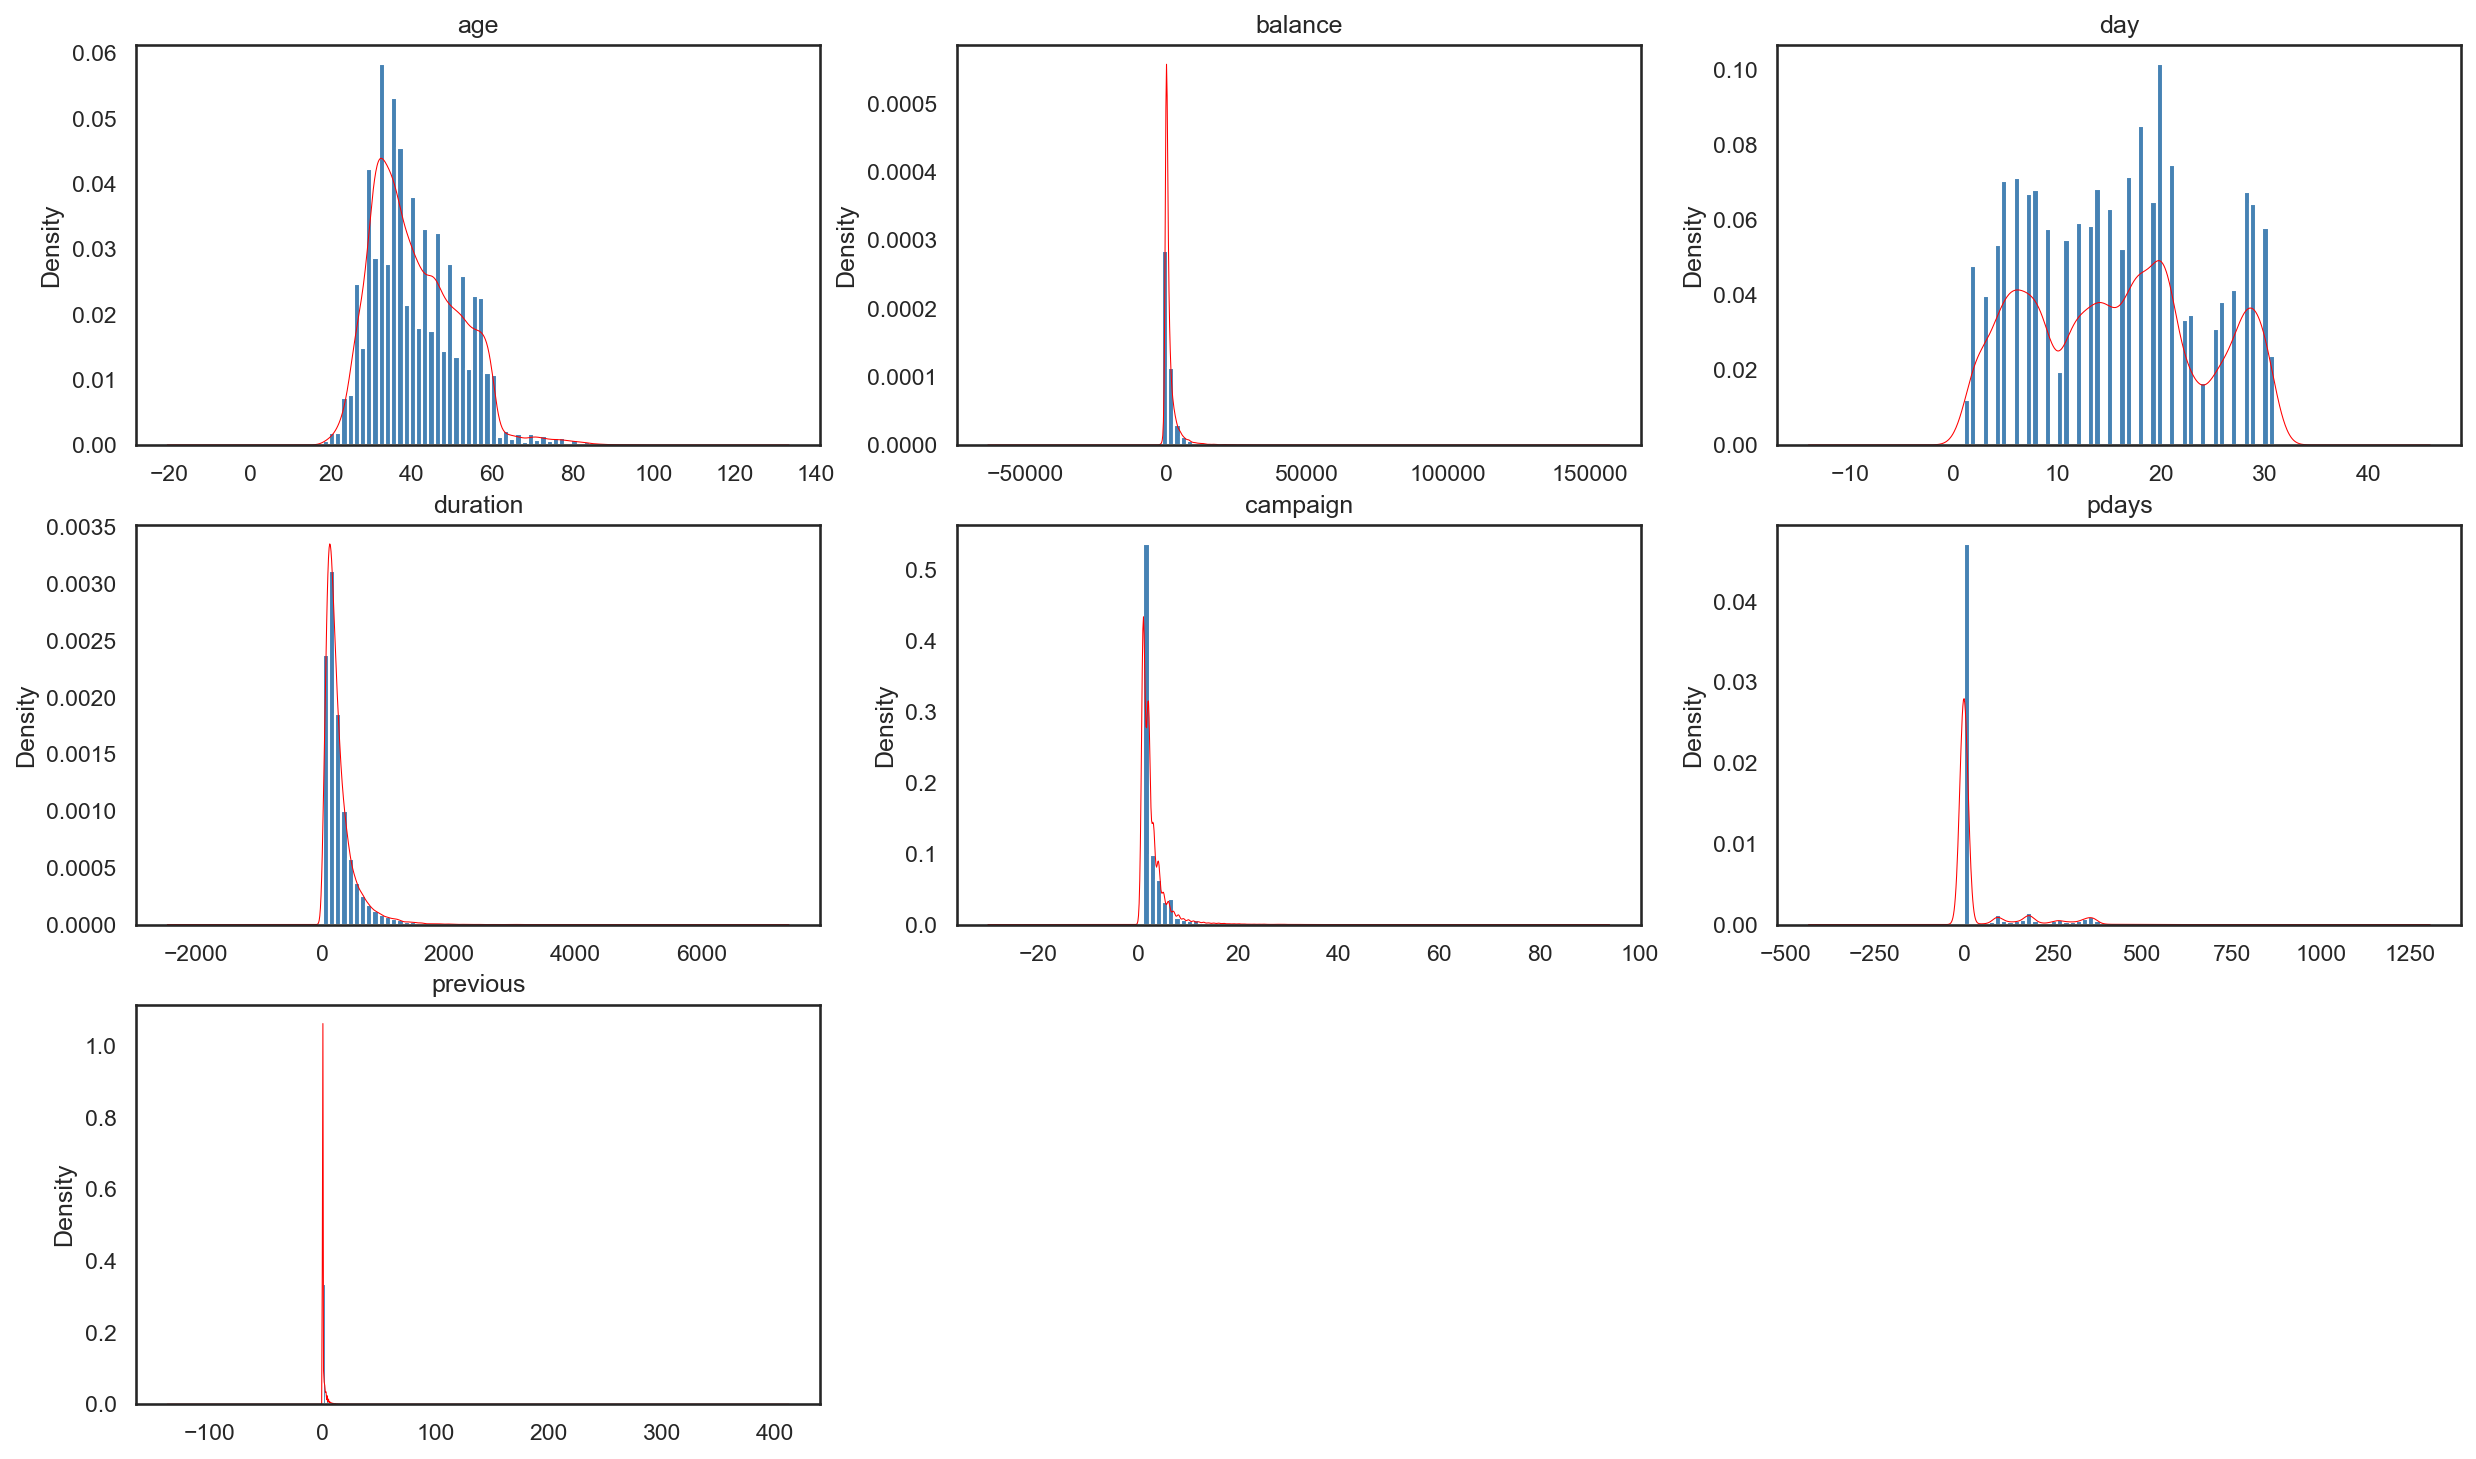

In [7]:
print("Continuous Variables Visualization")
fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (20,12))
for i, item in enumerate(bank_int):
    if i < 3:
#         ax = sns.displot(bank[item], bins=100, hist=True, kde=True)
        ax = bank[item].plot(kind = 'hist', ax=axes[0,i], bins=50, density=True, color='steelblue')
        ax = bank[item].plot(kind = 'kde', ax=axes[0,i], color = 'red', linewidth=0.5)
    elif i >=3 and i < 6:
        ax = bank[item].plot(kind = 'hist', ax=axes[1,i-3], bins=50, density=True, color='steelblue')
        ax = bank[item].plot(kind = 'kde', ax=axes[1,i-3], color = 'red', linewidth=0.5)
    elif i < 9:
        ax = bank[item].plot(kind = 'hist', ax=axes[2,i-6], bins=100, density=True, color='steelblue')
        ax = bank[item].plot(kind = 'kde', ax=axes[2,i-6], color = 'red', linewidth=0.5)
        
    ax.set_title(item)
plt.delaxes(axes[2, 1])
plt.delaxes(axes[2, 2])

In [8]:
# Just comment out this cell if you don't need log transformation

# for i in ['balance', 'duration', 'campaign', 'pdays', 'previous']:
#     bank[i] = np.log2(bank[i])
#     bank[i][bank[i]==float('-inf')]=-1
# bank['balance'].fillna(-1, inplace=True)

After log transformation


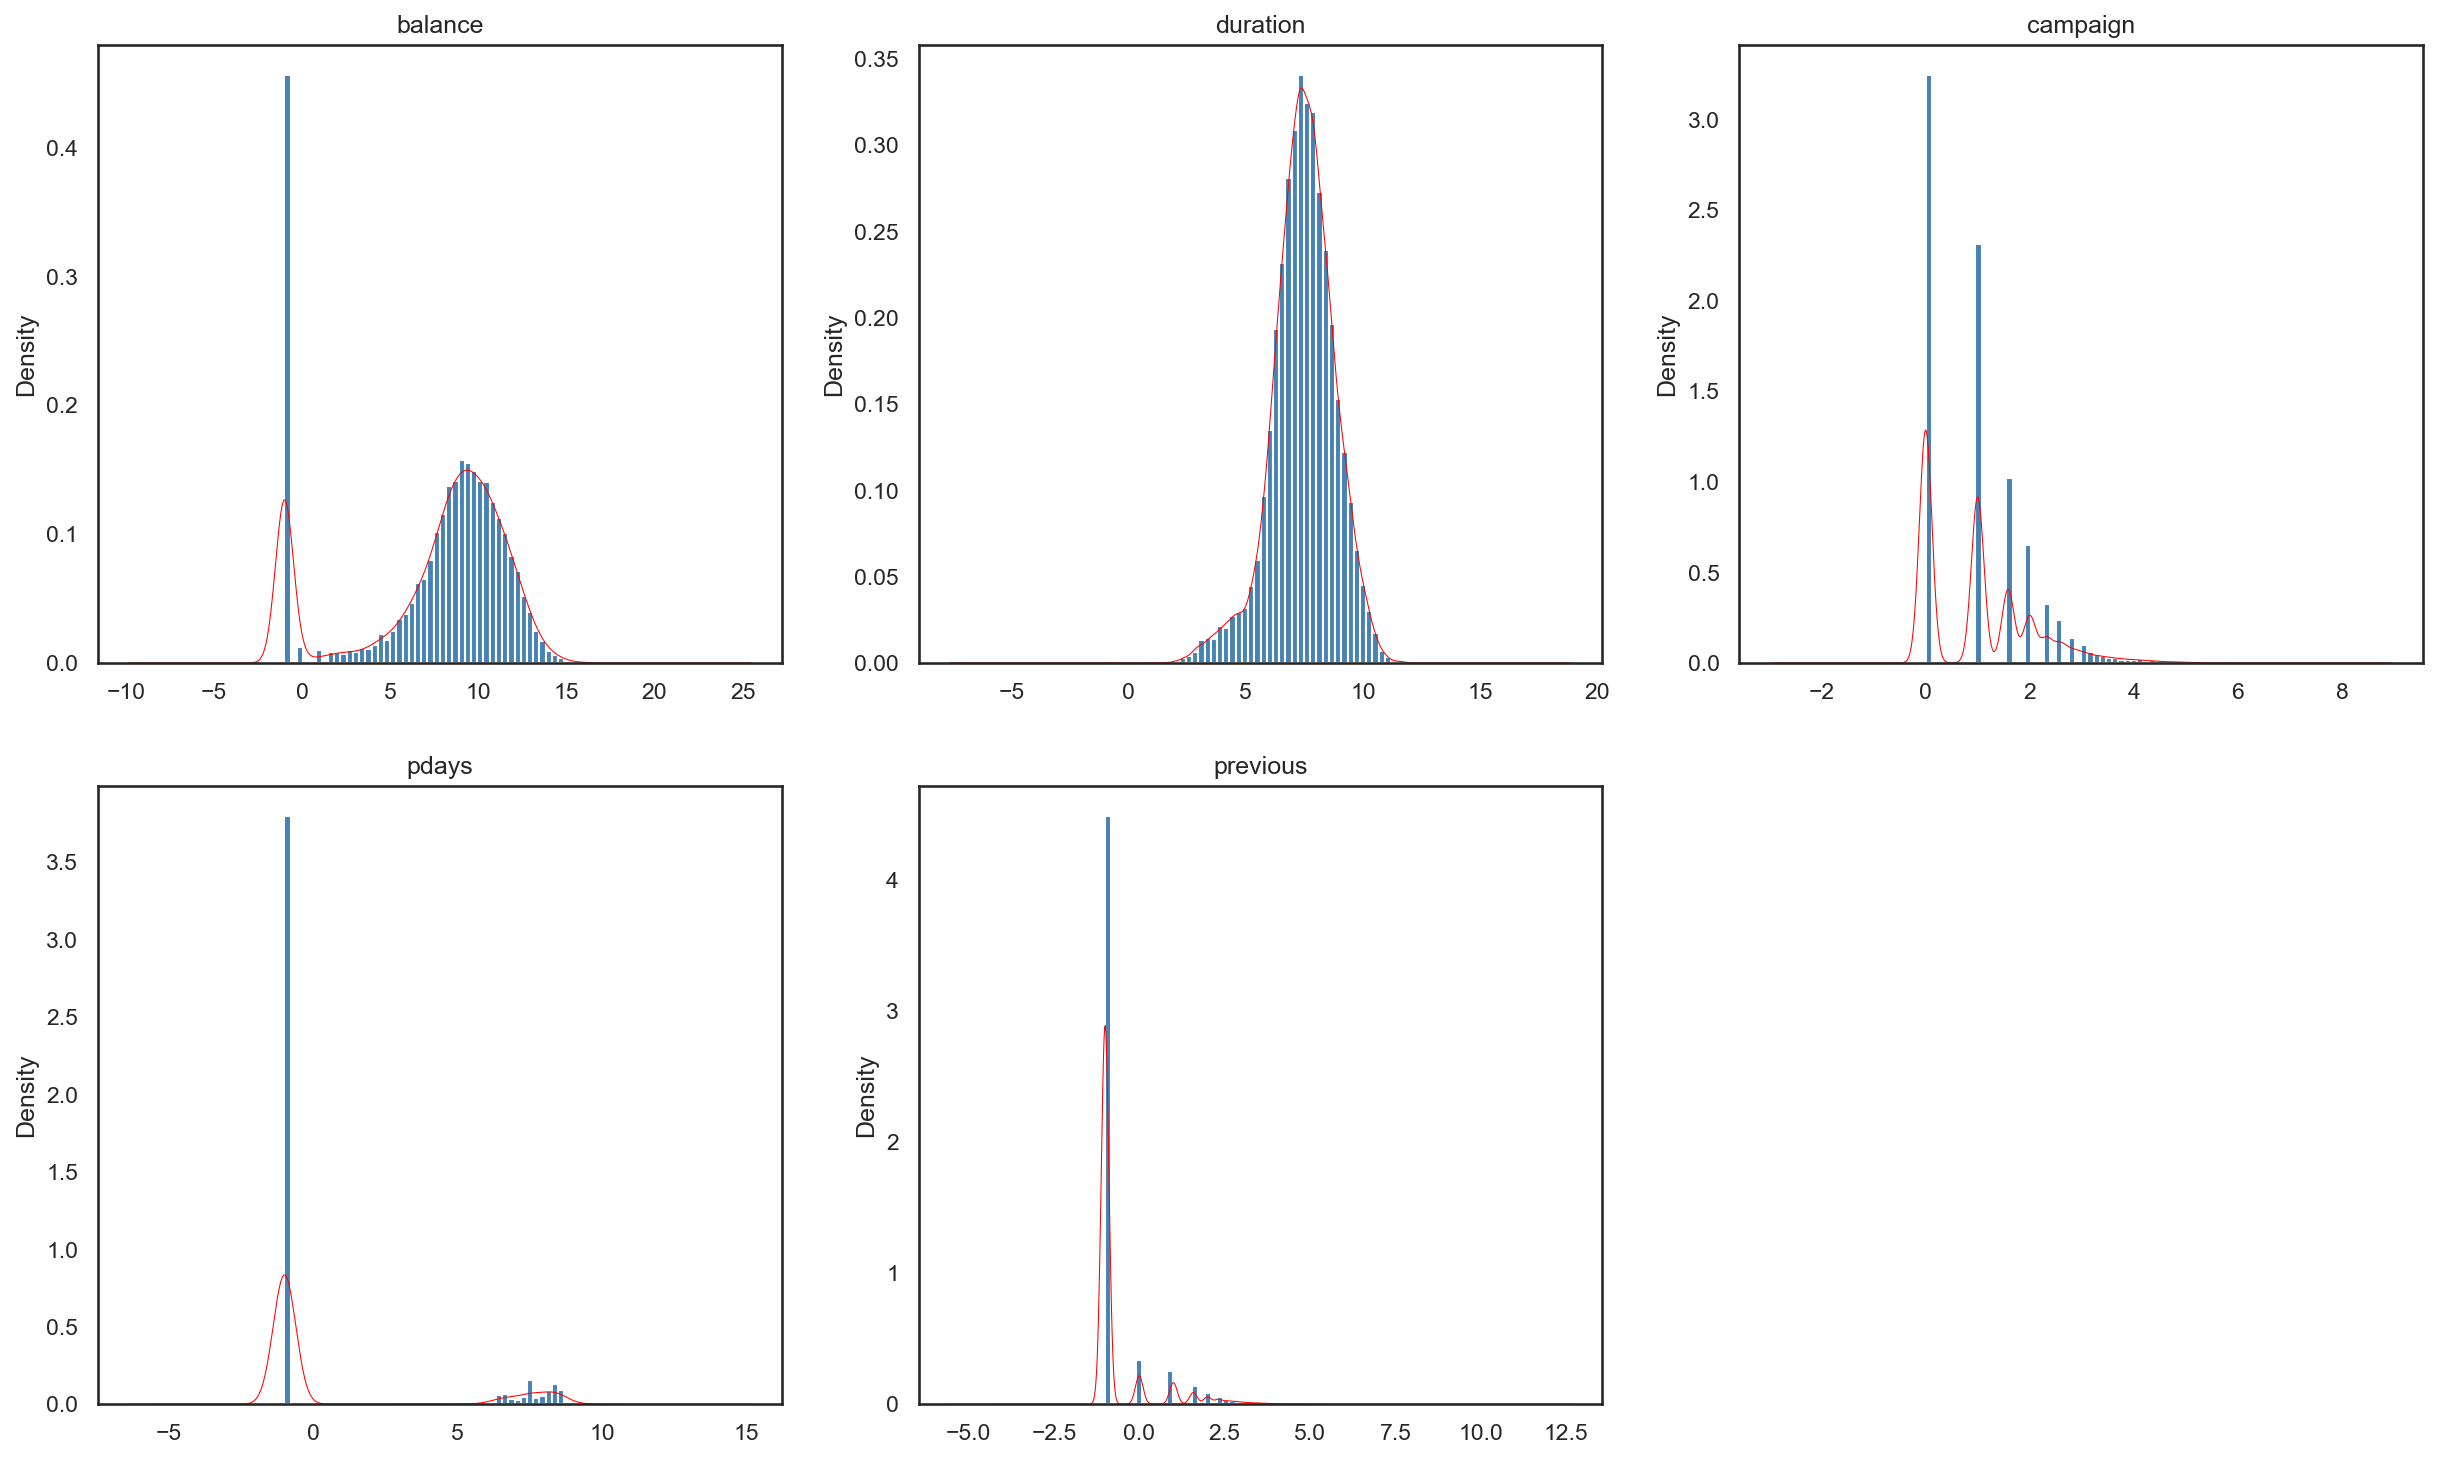

In [9]:
bank_log = ['balance', 'duration', 'campaign', 'pdays', 'previous']
print("After log transformation")
fig, axes = plt.subplots(nrows = 2,ncols = 3,figsize = (20,12))
for i, item in enumerate(bank_log):
    if i < 3:
#         ax = sns.displot(bank[item], bins=100, hist=True, kde=True)
        ax = bank[item].plot(kind = 'hist', ax=axes[0,i], bins=50, density=True, color='steelblue')
        ax = bank[item].plot(kind = 'kde', ax=axes[0,i], color = 'red', linewidth=0.5)
    elif i >=3 and i < 6:
        ax = bank[item].plot(kind = 'hist', ax=axes[1,i-3], bins=50, density=True, color='steelblue')
        ax = bank[item].plot(kind = 'kde', ax=axes[1,i-3], color = 'red', linewidth=0.5)
    elif i < 9:
        ax = bank[item].plot(kind = 'hist', ax=axes[2,i-6], bins=100, density=True, color='steelblue')
        ax = bank[item].plot(kind = 'kde', ax=axes[2,i-6], color = 'red', linewidth=0.5)
        
    ax.set_title(item)
plt.delaxes(axes[1, 2])

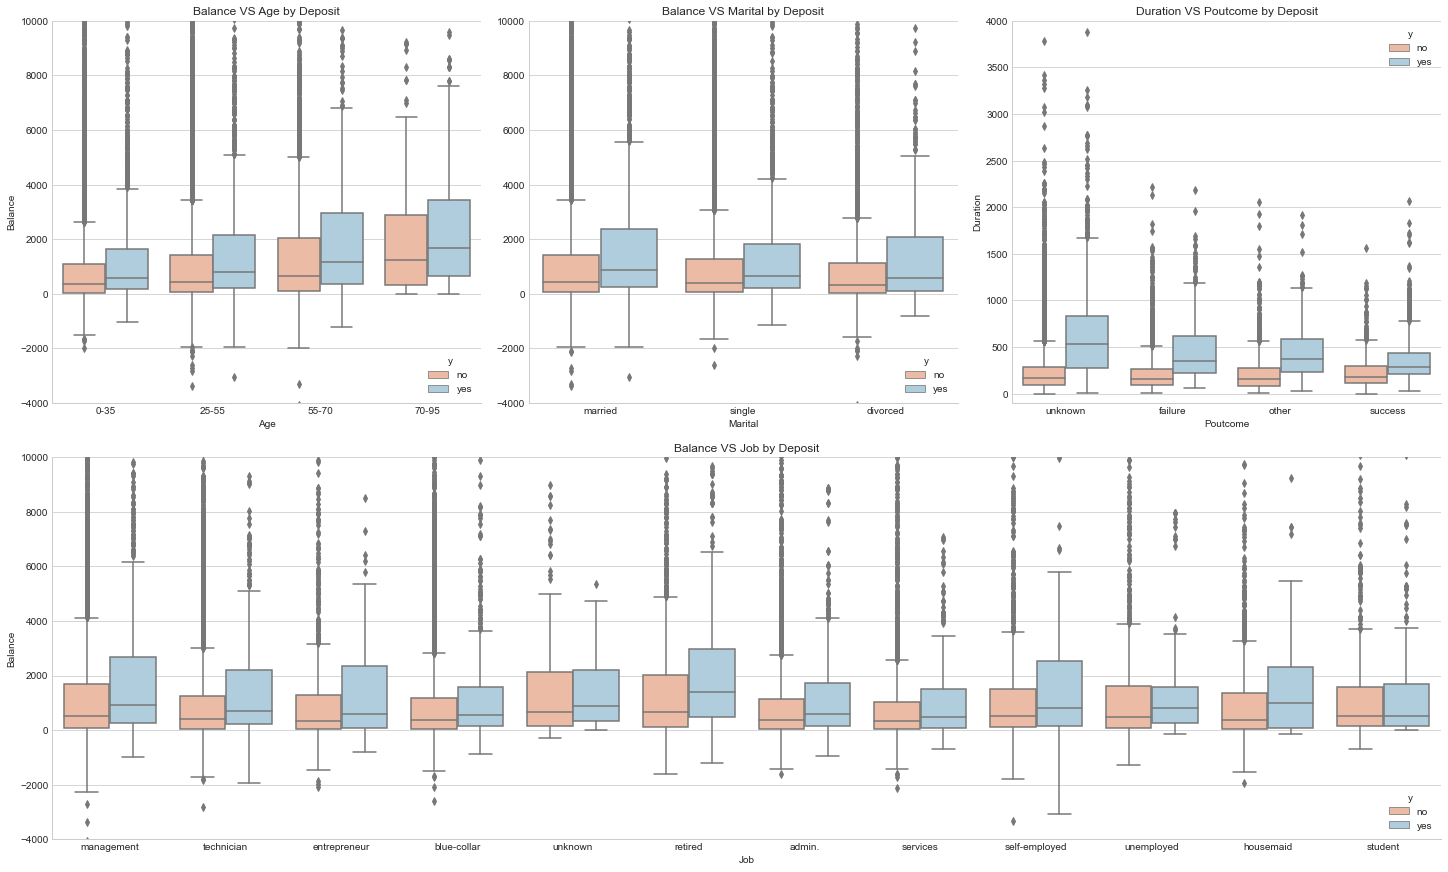

<Figure size 432x288 with 0 Axes>

In [10]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(constrained_layout=True, figsize=(20, 12))

gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
ax4 = fig.add_subplot(gs[0, 2])

sns.boxplot(x='age_cate', y='balance', hue='y', data=bank, ax=ax1, palette="RdBu")
sns.despine()
ax1.set(ylim=(-4000, 10000))
ax1.set_title('Balance VS Age by Deposit')
ax1.set_xlabel('Age')
ax1.set_ylabel('Balance')

sns.boxplot(x='marital', y='balance', hue='y', data=bank, ax=ax2, palette="RdBu")
sns.despine()
ax2.set(ylim=(-4000, 10000))
ax2.set_title('Balance VS Marital by Deposit')
ax2.set_xlabel('Marital')
ax2.set_ylabel('')

sns.boxplot(x="job", y="balance", data=bank, hue="y", ax=ax3, palette="RdBu")
sns.despine()
ax3.set(ylim=(-4000, 10000))
ax3.set_title('Balance VS Job by Deposit')
ax3.set_xlabel('Job')
ax3.set_ylabel('Balance')

sns.boxplot(x="poutcome", y="duration", data=bank, hue="y", ax=ax4, palette="RdBu")
sns.despine()
ax4.set_title('Duration VS Poutcome by Deposit')
ax4.set(ylim=(-100, 4000))
ax4.set_xlabel('Poutcome')
ax4.set_ylabel('Duration')
plt.show()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
plt.show()

**previous: number of contacts performed before this campaign and for this client (numeric)**

In [27]:
bank.previous.value_counts()

0      36954
1       2772
2       2106
3       1142
4        714
5        459
6        277
7        205
8        129
9         92
10        67
11        65
12        44
13        38
15        20
14        19
17        15
16        13
19        11
20         8
23         8
18         6
22         6
27         5
24         5
21         4
29         4
25         4
30         3
26         2
37         2
28         2
38         2
40         1
275        1
51         1
55         1
35         1
32         1
58         1
41         1
Name: previous, dtype: int64

**To do:**

distribution on different

devide into discrete and continuous or not? 

# Data Preprocessing

After one - hot encoding, linear correlated, delete one in each orginal attribute

In [28]:
0 in list(bank.pdays.tolist())

True

## encoding

In [29]:
# label encoding 1
for i in ['y','loan','housing','default']:
    bank[i] = bank[i].map({'yes':1,'no':0})

In [30]:
bank

age           job   marital  education  default  balance  housing  \
0       58    management   married   tertiary        0     2143        1   
1       44    technician    single  secondary        0       29        1   
2       33  entrepreneur   married  secondary        0        2        1   
3       47   blue-collar   married    unknown        0     1506        1   
4       33       unknown    single    unknown        0        1        0   
...    ...           ...       ...        ...      ...      ...      ...   
45206   51    technician   married   tertiary        0      825        0   
45207   71       retired  divorced    primary        0     1729        0   
45208   72       retired   married  secondary        0     5715        0   
45209   57   blue-collar   married  secondary        0      668        0   
45210   37  entrepreneur   married  secondary        0     2971        0   

       loan    contact  day month  duration  campaign  pdays  previous  \
0         0    unknown    5   may       261         1      0         0   
1         0    unknown    5   may       151         1      0         0   
2         1    unknown    5   may        76         1      0         0   
3         0    unknown    5   may        92         1      0         0   
4         0    unknown    5   may       198         1      0         0   
...     ...        ...  ...   ...       ...       ...    ...       ...   
45206     0   cellular   17   nov       977         3      0         0   
45207     0   cellular   17   nov       456         2      0         0   
45208     0   cellular   17   nov      1127         5    184         3   
45209     0  telephone   17   nov       508         4      0         0   
45210     0   cellular   17   nov       361         2    188        11   

      poutcome  y  first_contact  
0      unknown  0              1  
1      unknown  0              1  
2      unknown  0              1  
3      unknown  0              1  
4      unknown  0              1  
...        ... ..            ...  
45206  unknown  1              1  
45207  unknown  1              1  
45208  success  1              0  
45209  unknown  0              1  
45210    other  0              0  

[45211 rows x 18 columns]

In [31]:
# one-hot encoding, solved for the multicollinearity

columns = bank.select_dtypes(include=[object]).columns
bank_dummies = pd.concat([bank, pd.get_dummies(bank[columns], drop_first = True)], axis=1)
bank_dummies = bank_dummies.drop(['job', 'marital', 'education', 'contact', 'month', 'poutcome'], axis=1)

In [32]:
# label encoding 2
bank['month'] = bank['month'].map({'jan':1,'feb':2,'mar':3,"apr":4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12})
for col in ['job', 'contact', 'marital', 'education', 'poutcome']:
    le = LabelEncoder()
    bank[col] = le.fit_transform(bank[col])
    print(col, le.classes_)

job ['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']
contact ['cellular' 'telephone' 'unknown']
marital ['divorced' 'married' 'single']
education ['primary' 'secondary' 'tertiary' 'unknown']
poutcome ['failure' 'other' 'success' 'unknown']


In [33]:
bank

age  job  marital  education  default  balance  housing  loan  contact  \
0       58    4        1          2        0     2143        1     0        2   
1       44    9        2          1        0       29        1     0        2   
2       33    2        1          1        0        2        1     1        2   
3       47    1        1          3        0     1506        1     0        2   
4       33   11        2          3        0        1        0     0        2   
...    ...  ...      ...        ...      ...      ...      ...   ...      ...   
45206   51    9        1          2        0      825        0     0        0   
45207   71    5        0          0        0     1729        0     0        0   
45208   72    5        1          1        0     5715        0     0        0   
45209   57    1        1          1        0      668        0     0        1   
45210   37    2        1          1        0     2971        0     0        0   

       day  month  duration  campaign  pdays  previous  poutcome  y  \
0        5      5       261         1      0         0         3  0   
1        5      5       151         1      0         0         3  0   
2        5      5        76         1      0         0         3  0   
3        5      5        92         1      0         0         3  0   
4        5      5       198         1      0         0         3  0   
...    ...    ...       ...       ...    ...       ...       ... ..   
45206   17     11       977         3      0         0         3  1   
45207   17     11       456         2      0         0         3  1   
45208   17     11      1127         5    184         3         2  1   
45209   17     11       508         4      0         0         3  0   
45210   17     11       361         2    188        11         1  0   

       first_contact  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1  
...              ...  
45206              1  
45207              1  
45208              0  
45209              1  
45210              0  

[45211 rows x 18 columns]

## Correlation 

Correlation Matrix 



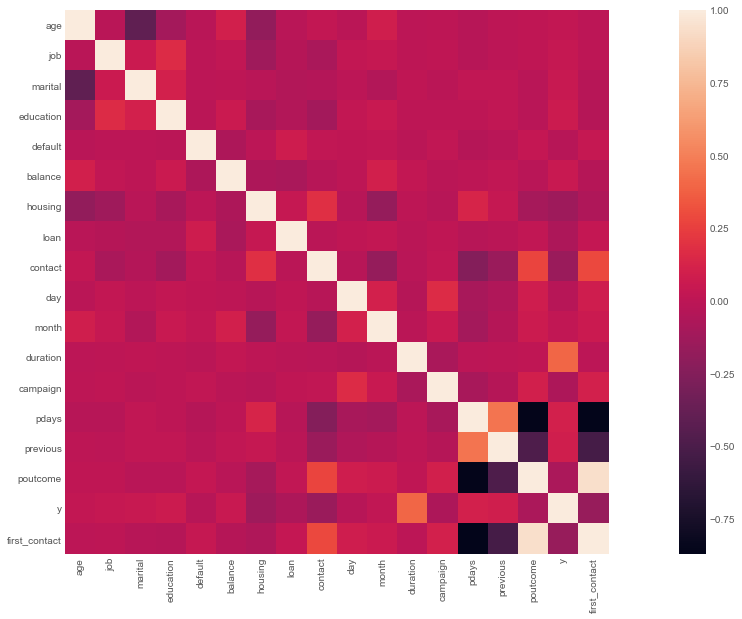

In [34]:
#Heat map
print("Correlation Matrix","\n")    
correlation=bank.corr(method="pearson")
plt.figure(figsize=(25,10))
sns.heatmap(correlation,vmax=1,square=True,annot=False)
plt.show()

Correlation Matrix 



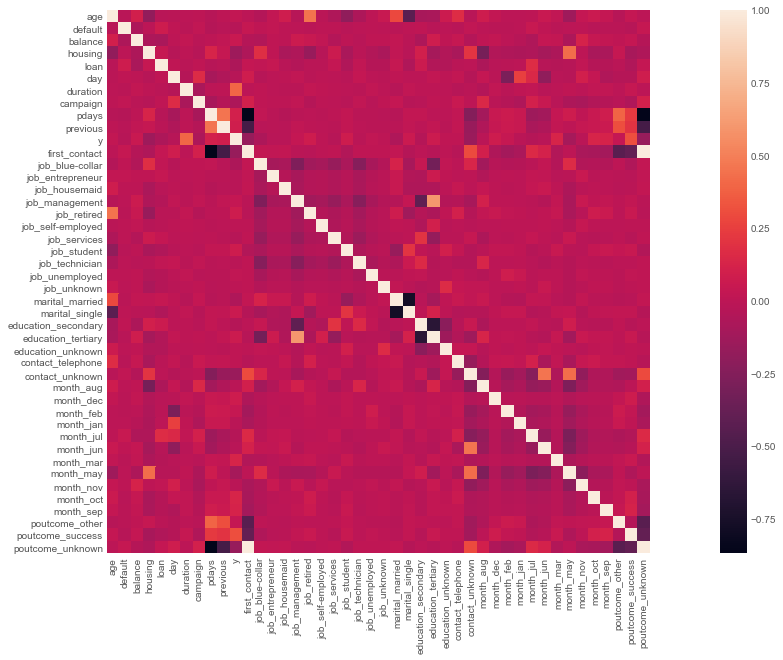

In [35]:
#Heat map
print("Correlation Matrix","\n")    
correlation=bank_dummies.corr(method="pearson")
plt.figure(figsize=(25,10))
sns.heatmap(correlation,vmax=1,square=True,annot=False)
plt.show()

In [36]:
def correl(df,thresh):
    cor = df.corr()
    corrm = np.corrcoef(df.transpose())
    corr = corrm - np.diagflat(corrm.diagonal())
    print("max corr:",corr.max(), ", min corr: ", corr.min())
    c1 = cor.abs().stack().sort_values(ascending=False).drop_duplicates()
    high_cor = c1[c1.values!=1]        
    display(high_cor[high_cor>thresh])
threshold = 0.8
correl(bank_dummies,threshold)

max corr: 0.9996295564193068 , min corr:  -0.8695023682956219


first_contact     poutcome_unknown   1.000
                  pdays              0.870
poutcome_unknown  pdays              0.869
dtype: float64

## train / test split

In [37]:
# data set with one - hot encoding, for those algorithm which is sensitive to the catergorical variables like LogisticR...
# Choose either to use, will use 80% to do stratified cross validation, example found in Modeling section below
y_onehot = bank_dummies['y'].values
X_onehot = bank_dummies.drop(columns = ['y'])
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_onehot, y_onehot
                                                            , test_size=0.2
                                                            , random_state=random_state
                                                            , stratify=y_onehot
                                                           )
# check whether stratified
print(np.unique(y_train_o, return_counts=True),"\n",np.unique(y_test_o, return_counts=True))

(array([0, 1], dtype=int64), array([31937,  4231], dtype=int64)) 
 (array([0, 1], dtype=int64), array([7985, 1058], dtype=int64))


In [38]:
# label encoding
y = bank['y'].values
X = bank.drop(columns = ['y'])
X_train, X_test, y_train, y_test = train_test_split(X, y
                                                    , test_size=0.2
                                                    , random_state=random_state
                                                    , stratify=y)
# check whether stratified
print(np.unique(y_train, return_counts=True),"\n",np.unique(y_test, return_counts=True))

(array([0, 1], dtype=int64), array([31937,  4231], dtype=int64)) 
 (array([0, 1], dtype=int64), array([7985, 1058], dtype=int64))


# feature engineering

## resample

In [39]:
resample_list = ['random_over_sample','SMOTE','ADASYN','BorderlineSMOTE','KMeansSMOTE', 'ClusterCentroids','random_under_sample']

def re_sample(X, y, func=None, random_state=2021):
    if func == None:
        return
    
    elif func == 'random_over_sample':
        ros = RandomOverSampler(random_state=random_state)
        X_resampled, y_resampled = ros.fit_resample(X, y)
    
    elif func == 'SMOTE':
        X_resampled, y_resampled = SMOTE().fit_resample(X, y)
    
    elif func == 'ADASYN':
        X_resampled, y_resampled = ADASYN().fit_resample(X, y)
        
    elif func == 'BorderlineSMOTE':
        X_resampled, y_resampled = BorderlineSMOTE().fit_resample(X, y)
        
    elif func == 'KMeansSMOTE':
        X_resampled, y_resampled = KMeansSMOTE(cluster_balance_threshold=0.005).fit_resample(X, y) # https://arxiv.org/pdf/1711.00837.pdf
    
    elif func == 'ClusterCentroids':
        X_resampled, y_resampled = ClusterCentroids().fit_resample(X, y)
        
    elif func == 'random_under_sample':
        X_resampled, y_resampled = RandomUnderSampler().fit_resample(X, y) 
    
    else:
        return

    return X_resampled, y_resampled

#todo: Combination of over- and under-sampling

## Feature Construction

In [ ]:
bankf = pd.read_csv("bank-full.csv", sep=";")
bank_intf = list(bankf.select_dtypes(include = ['int64']).columns)
bank_strf = list(bankf.select_dtypes(include = ['object']).columns)
bank_strf.remove("y")

In [ ]:
# cleaning `pdays`
bankf['pdays'][bankf["pdays"]==-1]=0
bankf["first_contact"] = 0
bankf['first_contact'][bankf['pdays']==0]=1

In [ ]:
bankf['pout_pdays'] = 0
bankf['pout_pdays'][ (bankf['poutcome'] =='success') & (bankf['pdays']>=300)] = 1
bankf.pout_pdays.value_counts()

0    45056
1      155
Name: pout_pdays, dtype: int64

In [ ]:
bankf['pout_duration'] = 0
bankf['pout_duration'][ (bankf['poutcome'] =='success') & (bankf['duration']>=60)] = 1
bankf.pout_duration.value_counts()

0    43728
1     1483
Name: pout_duration, dtype: int64

In [ ]:
bankf['pre_duration'] = 0
bankf['pre_duration'][ (bankf['previous'] >= 1) &(bankf['previous']< 4) & (bankf['duration']>=60)] = 1
bankf.pre_duration.value_counts()

0    39647
1     5564
Name: pre_duration, dtype: int64

In [ ]:
bankf['fir_unknown'] = 0
bankf['fir_unknown'][ (bankf['first_contact'] == 1) &(bankf['contact'] == 'unknown')] = 1
bankf.fir_unknown.value_counts()

0    32261
1    12950
Name: fir_unknown, dtype: int64

In [ ]:
bankf['summer'] = 0
bankf['summer'][(bankf['month'] == 'may')|(bankf['month'] == 'jun')|(bankf['month'] == 'jul')|(bankf['month'] == 'aug')] = 1
bankf.summer.value_counts()

1    32249
0    12962
Name: summer, dtype: int64

In [ ]:
bankf['potential'] = 0
bankf['potential'][ (bankf['marital'] == 'married') &(bankf['balance']> 600)] = 1
bankf.potential.value_counts()

0    33009
1    12202
Name: potential, dtype: int64

In [ ]:
bankf['age_balance'] = 0
bankf['age_balance'][(bankf['age']>50) & bankf['balance']> 0] = 1
bankf.age_balance.value_counts()

0    40925
1     4286
Name: age_balance, dtype: int64

In [ ]:
bankf

age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  duration  campaign  pdays  previous poutcome  \
0        unknown    5   may       261         1      0         0  unknown   
1        unknown    5   may       151         1      0         0  unknown   
2        unknown    5   may        76         1      0         0  unknown   
3        unknown    5   may        92         1      0         0  unknown   
4        unknown    5   may       198         1      0         0  unknown   
...          ...  ...   ...       ...       ...    ...       ...      ...   
45206   cellular   17   nov       977         3      0         0  unknown   
45207   cellular   17   nov       456         2      0         0  unknown   
45208   cellular   17   nov      1127         5    184         3  success   
45209  telephone   17   nov       508         4      0         0  unknown   
45210   cellular   17   nov       361         2    188        11    other   

         y  first_contact  pout_pdays  pout_duration  pre_duration  \
0       no              1           0              0             0   
1       no              1           0              0             0   
2       no              1           0              0             0   
3       no              1           0              0             0   
4       no              1           0              0             0   
...    ...            ...         ...            ...           ...   
45206  yes              1           0              0             0   
45207  yes              1           0              0             0   
45208  yes              0           0              1             1   
45209   no              1           0              0             0   
45210   no              0           0              0             0   

       fir_unknown  summer  potential  age_balance  
0                1       1          1            1  
1                1       1          0            0  
2                1       1          0            0  
3                1       1          1            0  
4                1       1          0            0  
...            ...     ...        ...          ...  
45206            0       0          1            1  
45207            0       0          0            1  
45208            0       0          1            1  
45209            0       0          1            0  
45210            0       0          1            0  

[45211 rows x 25 columns]

## data cluster (seems useless)

In [34]:

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time.time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
#     pred = kmeans.predict()
    fit_time = time.time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(data, estimator[-1].labels_,
                                 metric="euclidean", sample_size=300,)
    ]

    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [35]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_o)
# # X_test_scaled = scaler.transform(X_test_o)

data = X_train_o
labels = y_train_o
n_clusters = 2
random_state=2021

print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4,
                random_state=random_state)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_clusters, n_init=4, random_state=random_state)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_clusters).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_clusters, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * '_')

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.160s	1425378	0.035	0.026	0.030	0.117	0.030	0.039
random   	0.122s	1425378	0.035	0.026	0.030	0.117	0.030	0.049
PCA-based	0.108s	1479230	0.006	0.004	0.005	0.029	0.005	0.053
__________________________________________________________________________________


In [36]:
data = X_train_o
labels = y_train_o
n_clusters = 10
random_state=2021


kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
kmeans.fit(data)
kmeans_result = kmeans.predict(data)

df = pd.DataFrame({
    'kmeans_result':kmeans_result,
    'y_train_o':y_train_o
})

for i in range(n_clusters):
    
    cluster_y_counts = df[df['kmeans_result']==i].y_train_o.value_counts()
    shape = df[df['kmeans_result']==i].shape
    print(f'cluster{i+1}\nratio: {cluster_y_counts[1]/cluster_y_counts[0]}\nnum of point in cluster: {shape[0]}\n')

cluster1
ratio: 0.19594594594594594
num of point in cluster: 1416

cluster2
ratio: 0.15026246719160105
num of point in cluster: 8765

cluster3
ratio: 0.18518518518518517
num of point in cluster: 128

cluster4
ratio: 0.1857379767827529
num of point in cluster: 715

cluster5
ratio: 0.25
num of point in cluster: 10

cluster6
ratio: 0.18131564400221117
num of point in cluster: 4274

cluster7
ratio: 0.16796875
num of point in cluster: 299

cluster8
ratio: 0.21739130434782608
num of point in cluster: 28

cluster9
ratio: 0.2105527638190955
num of point in cluster: 2409

cluster10
ratio: 0.09662975736673322
num of point in cluster: 18124



## pca

In [37]:
pca = PCA(n_components=3)

reduced_data = pca.fit_transform(X_train_o)
print(pca.explained_variance_ratio_)
# print(pca.components_)
# reduced_data[:,0]

[0.99152855 0.00735005 0.00109969]


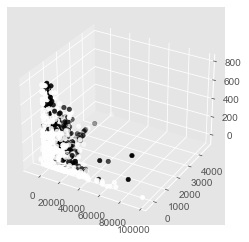

In [38]:
ax = plt.figure().add_subplot(111,projection='3d')
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2],c=y_train_o)

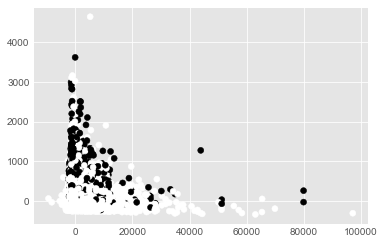

In [39]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_train_o)

In [40]:
# data = X_train_o
# labels = y_train_o
# n_clusters = 2
# random_state=2021

# reduced_data = PCA(n_components=2).fit_transform(data)
# kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
# kmeans.fit(reduced_data)
# # kmeans.predict()

# # Step size of the mesh. Decrease to increase the quality of the VQ.
# h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# # Plot the decision boundary. For that, we will assign a color to each
# x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
# y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# # Obtain labels for each point in mesh. Use last trained model.
# Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# # Put the result into a color plot
# Z = Z.reshape(xx.shape)
# plt.figure(1)
# plt.clf()
# plt.imshow(Z, interpolation="nearest",
#            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#            cmap=plt.cm.Paired, aspect="auto", origin="lower")

# plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# # Plot the centroids as a white X
# centroids = kmeans.cluster_centers_
# plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
#             color="w", zorder=10)
# plt.title("K-means clustering on the digits dataset (PCA-reduced data)\n"
#           "Centroids are marked with white cross")
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())
# plt.show()

## feature cluster (wanting)

In [41]:
def plot_hierarchical_clustering(X=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    corr = spearmanr(X).correlation

    # Ensure the correlation matrix is symmetric
    corr = (corr + corr.T)/2
    np.fill_diagonal(corr, 1)

    # We convert the correlation matrix to a distance matrix before performing
    # hierarchical clustering using Ward's linkage.
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    dendro = hierarchy.dendrogram(
        dist_linkage, labels=X.columns.tolist(), ax=ax1, leaf_rotation=90
    )
    dendro_idx = np.arange(0, len(dendro['ivl']))

    ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
    ax2.set_xticks(dendro_idx)
    ax2.set_yticks(dendro_idx)
    ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
    ax2.set_yticklabels(dendro['ivl'])
    fig.tight_layout()
    plt.show()

In [42]:
def cluster_feature_selection(X,t=1, criterion='distance'):
    corr = spearmanr(X).correlation

    corr = (corr + corr.T)/2
    np.fill_diagonal(corr, 1)

    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    
    cluster_ids = hierarchy.fcluster(dist_linkage, t=t, criterion=criterion)
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
#     print(cluster_id_to_feature_ids)
    print('selected_features:',selected_features)
    
    return X.iloc[:, selected_features]

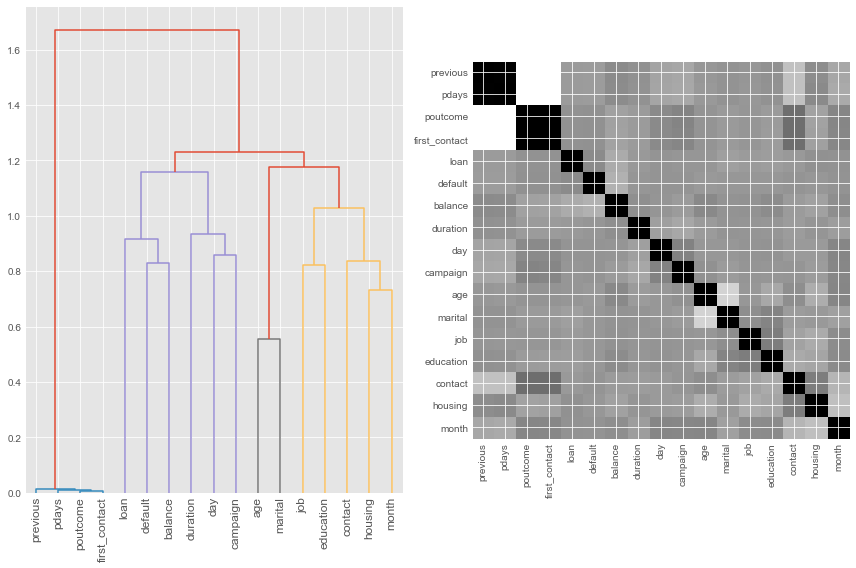

In [43]:
plot_hierarchical_clustering(X_train)

In [44]:
cluster_feature_selection(X_train)

selected_features: [0, 1, 4, 6, 9, 13]


age  job  default  housing  day  pdays
11064   57    1        0        0   17      0
18119   46    5        0        0   30      0
9412    46    9        0        0    6      0
10411   53   10        0        1   12      0
39905   38    9        0        1    2     95
...    ...  ...      ...      ...  ...    ...
9050    56    4        0        0    5      0
37726   42    2        0        1   14    365
27543   55    4        0        1   21    106
17133   41    1        0        1   25      0
1889    37    1        0        1    9      0

[36168 rows x 6 columns]

# Modeling

In [45]:
roc_dic={}

## Stratified K - Fold Cross Validation (K = 5)

In [46]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)

## Logistic regression

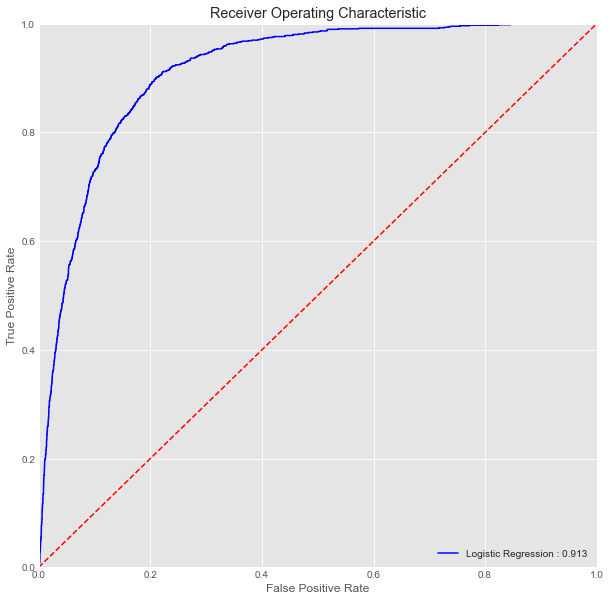

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      7985
           1       0.42      0.83      0.55      1058

    accuracy                           0.84      9043
   macro avg       0.70      0.84      0.73      9043
weighted avg       0.91      0.84      0.86      9043



Model  Recall_score  Precision  f1_score  Area_under_curve  \
0  Logistic Regression         0.829      0.416     0.554             0.913   

   Kappa_metric   MCC  
0         0.472 0.513

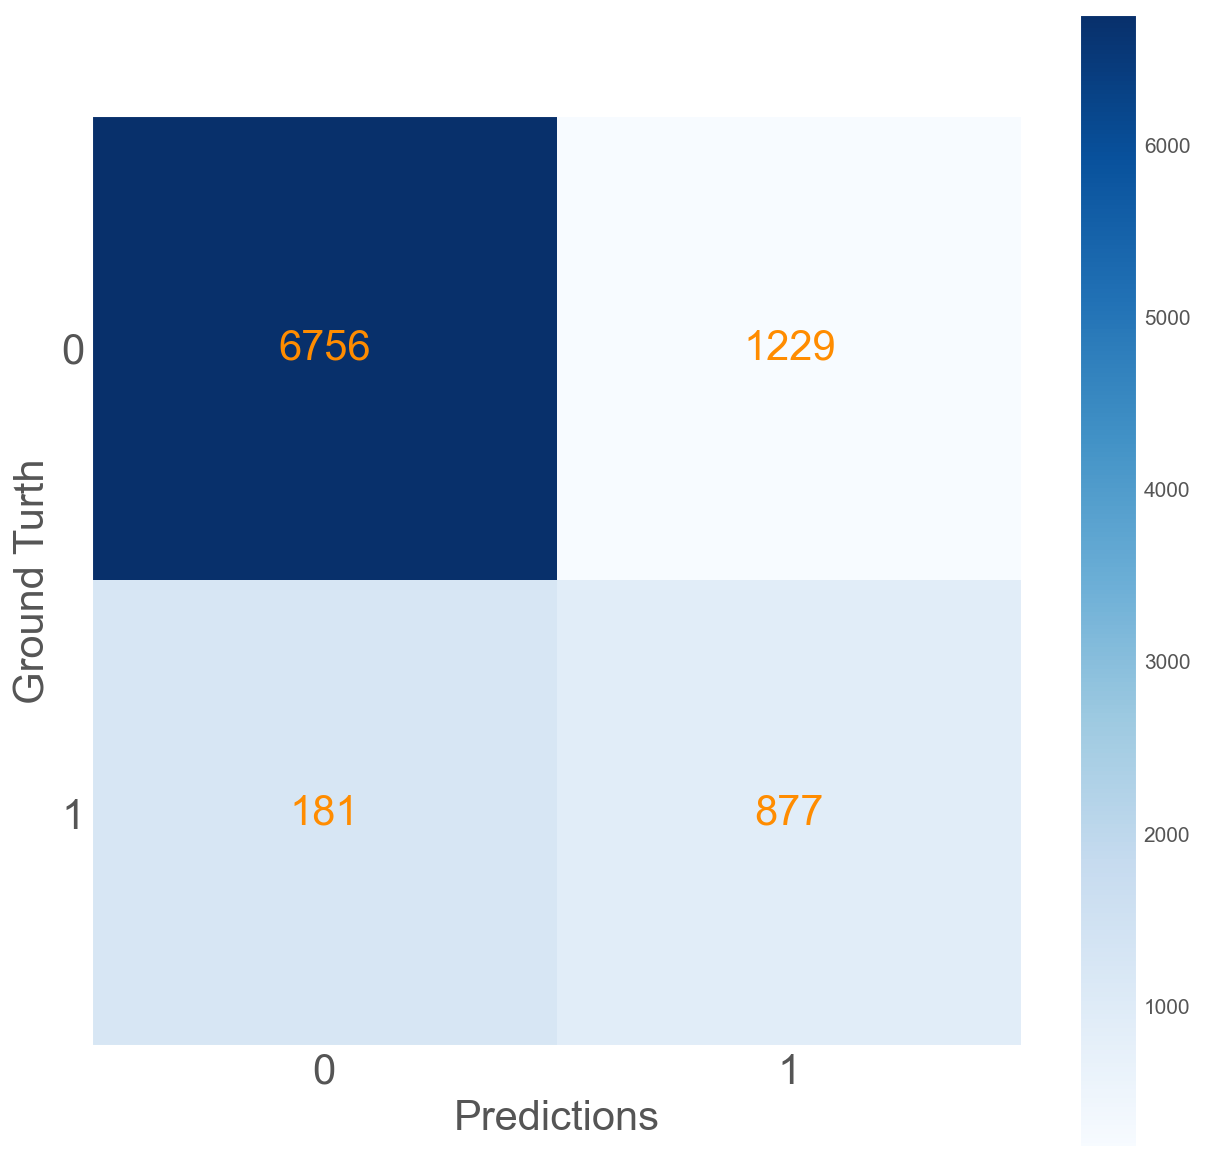

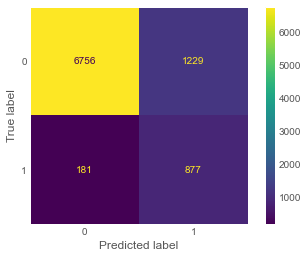

In [47]:
# Logistic Regression on the test set

seed = np.random.seed(2021)

# Use the selected hyperparameters
lr = LogisticRegression(C = 1,
                        max_iter = 100,
                        penalty = 'l1',
                        solver = 'saga',
                        random_state = 2021)



min_max_scaler = MinMaxScaler()

# Feature selection: remove features with low variance (42 -> 40 features)
sel = VarianceThreshold(threshold=0.01)
sel_var=sel.fit_transform(X_train_o)
train_x_lv = X_train_o[X_train_o.columns[sel.get_support(indices=True)]]
test_x_lv = X_test_o[train_x_lv.columns]
#print(train_x_lv.shape)

# Feature selection: remove one of the highly correlated features > 0.8 (40 -> 39 features)
correlation_train = train_x_lv.corr(method="pearson")
columns = np.full((correlation_train.shape[0],), True, dtype=bool)
for i in range(correlation_train.shape[0]):
    for j in range(i+1, correlation_train.shape[0]):
        if abs(correlation_train.iloc[i,j]) >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = train_x_lv.columns[columns]
train_x_cf = train_x_lv[selected_columns]
test_x_cf = test_x_lv[selected_columns]
#print(train_x_cf.shape)

# Undersampling
train_x_os,train_y_os = re_sample(train_x_cf, y_train_o, func='random_under_sample', random_state=2021)

# Data normalisation
train_x_dn = pd.DataFrame(min_max_scaler.fit_transform(train_x_os),columns=train_x_os.columns)
test_x_dn = pd.DataFrame(min_max_scaler.transform(test_x_cf),columns=test_x_cf.columns)


X_tr,  y_tr = train_x_dn, train_y_os
X_t,  y_t = test_x_dn, y_test_o
# Train the model
lr.fit(X_tr,  y_tr)
# lr_predict = lr.predict(test_x_dn)
# lr_predict_prob = lr.predict_proba(test_x_dn)

fpr_lr, tpr_lr, auc_lr= compute_and_plot_roc_curve(lr,X_t,  y_t,"Logistic Regression")

model_lr = model_report(lr,X_t,  y_t,"Logistic Regression")
model_lr

In [48]:
predict_prob = lr.predict_proba(X_t)
fpr, tpr, threshold = metrics.roc_curve(y_t, predict_prob[:,1])

In [49]:
fpr

array([0.00000000e+00, 1.25234815e-04, 1.25234815e-04, ...,
       8.82154039e-01, 8.82154039e-01, 1.00000000e+00])

In [50]:
tpr

array([0.00000000e+00, 0.00000000e+00, 9.45179584e-04, ...,
       9.99054820e-01, 1.00000000e+00, 1.00000000e+00])

In [51]:
threshold

array([1.99999999e+00, 9.99999988e-01, 9.99999802e-01, ...,
       3.88930289e-02, 3.88658331e-02, 9.39040060e-04])

In [52]:
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.913327801537145

## KNN

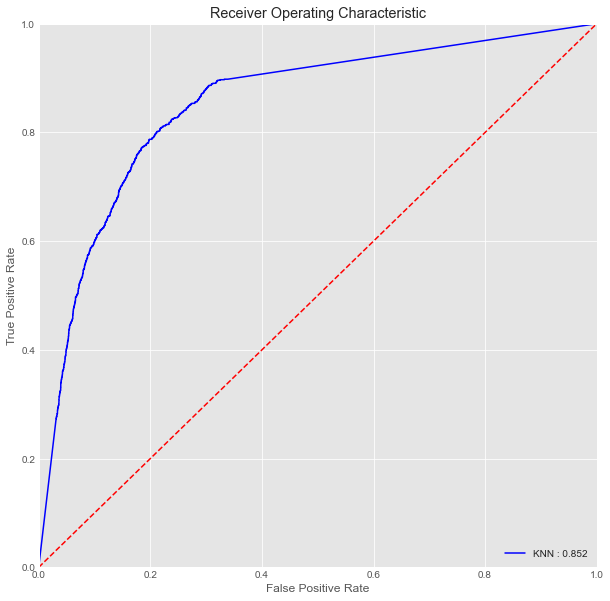

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      7985
           1       0.38      0.71      0.49      1058

    accuracy                           0.83      9043
   macro avg       0.67      0.78      0.70      9043
weighted avg       0.89      0.83      0.85      9043



Model  Recall_score  Precision  f1_score  Area_under_curve  Kappa_metric  \
0   KNN         0.713      0.379     0.495             0.852         0.403   

    MCC  
0 0.433

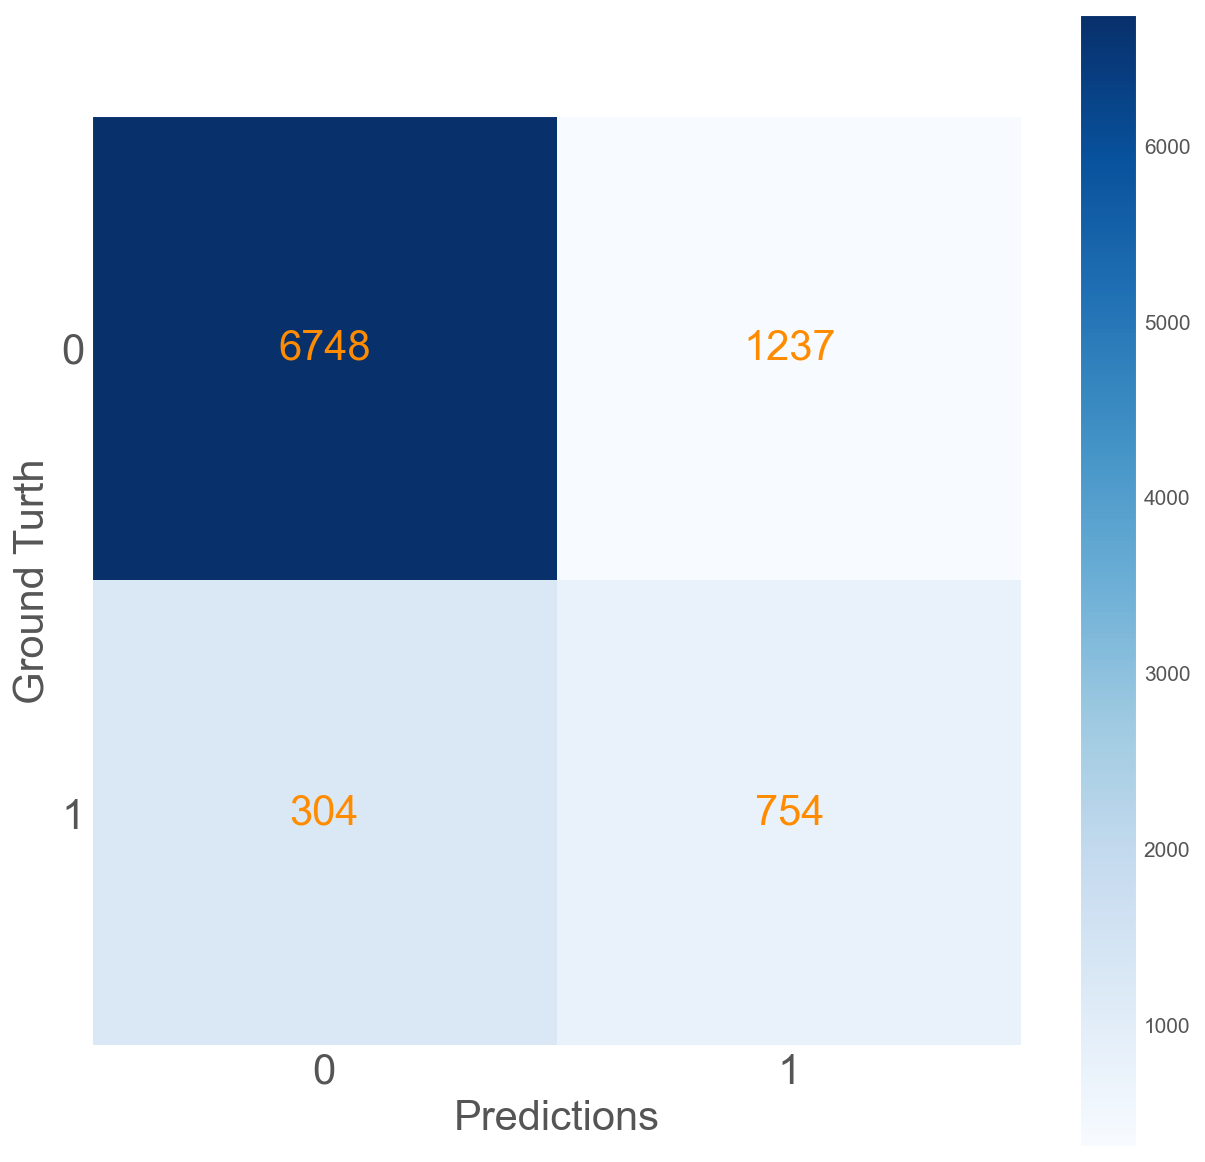

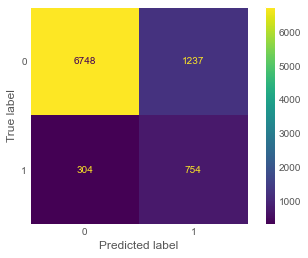

In [53]:
weights= 'distance'
n_neighbors= 9
func= 'SMOTE'

knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, n_jobs=-1)


# normalization
scaler = StandardScaler()
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train_o)
# X_test_scaled = scaler.transform(X_test_o)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_o),columns=X_train_o.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_o),columns=X_test_o.columns)


# # feature selection: remove features with low variance
# sel = VarianceThreshold(threshold=0.01)
# sel_var=sel.fit_transform(X_train_scaled)
# X_TR = X_train_scaled[X_train_scaled.columns[sel.get_support(indices=True)]]
# X_T = X_test_scaled[X_TR.columns]
    
# # feature selection: remove one of the highly correlated features
# correlation_train = X_TR.corr(method="pearson")
# columns = np.full((correlation_train.shape[0],), True, dtype=bool)
# for i in range(correlation_train.shape[0]):
#     for j in range(i+1, correlation_train.shape[0]):
#         if abs(correlation_train.iloc[i,j]) >= 0.8:
#             if columns[j]:
#                 columns[j] = False

# selected_columns = X_TR.columns[columns]
# X_TRF = X_TR[selected_columns]
# X_TF = X_T[selected_columns]

# resample
X_train_re, y_train_re = re_sample(X_train_scaled, y_train_o, func=func)



# X_tr,  y_tr = re_sample(X_TRF, y_train, func = 'ClusterCentroids')
X_tr,  y_tr = X_train_re, y_train_re
X_t,  y_t = X_test_scaled, y_test

#train on train set
knn.fit(X_tr, y_tr)

# #predict
# predicted = knn.predict(X_t)
# predict_prob = knn.predict_proba(X_t)

fpr_knn, tpr_knn, auc_knn = compute_and_plot_roc_curve(knn,X_t, y_t,"KNN")

model_knn = model_report(knn,X_t, y_t,"KNN")
model_knn

In [54]:
fpr_knn

array([0.        , 0.03043206, 0.03055729, 0.03055729, 0.03068253,
       0.03068253, 0.03080776, 0.03080776, 0.03105823, 0.03105823,
       0.03118347, 0.03118347, 0.03143394, 0.03143394, 0.03180964,
       0.03180964, 0.03206011, 0.03206011, 0.03268629, 0.03268629,
       0.03281152, 0.03281152, 0.03306199, 0.03306199, 0.03356293,
       0.03356293, 0.03368817, 0.03368817, 0.03393863, 0.03393863,
       0.03406387, 0.03406387, 0.0341891 , 0.0341891 , 0.03456481,
       0.03456481, 0.03481528, 0.03481528, 0.03519098, 0.03519098,
       0.03594239, 0.03594239, 0.03619286, 0.03619286, 0.0363181 ,
       0.0363181 , 0.03644333, 0.03644333, 0.03656857, 0.03656857,
       0.0366938 , 0.0366938 , 0.03731997, 0.03731997, 0.03744521,
       0.03744521, 0.03757044, 0.03757044, 0.03769568, 0.03769568,
       0.03782091, 0.03782091, 0.03807138, 0.03807138, 0.03832185,
       0.03832185, 0.03857232, 0.03857232, 0.03932373, 0.03932373,
       0.03944897, 0.03944897, 0.0395742 , 0.0395742 , 0.03982

## Naive Bayes

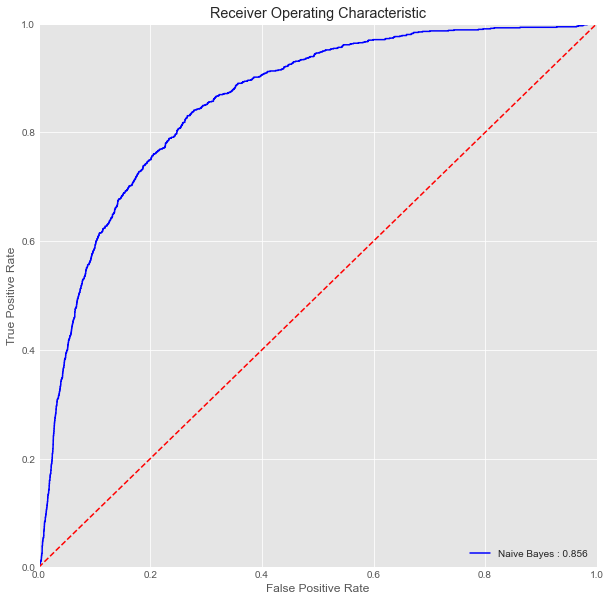

              precision    recall  f1-score   support

           0       0.95      0.86      0.90      7985
           1       0.39      0.67      0.49      1058

    accuracy                           0.84      9043
   macro avg       0.67      0.77      0.70      9043
weighted avg       0.89      0.84      0.85      9043



Model  Recall_score  Precision  f1_score  Area_under_curve  \
0  Naive Bayes         0.675      0.386     0.491             0.856   

   Kappa_metric   MCC  
0         0.402 0.424

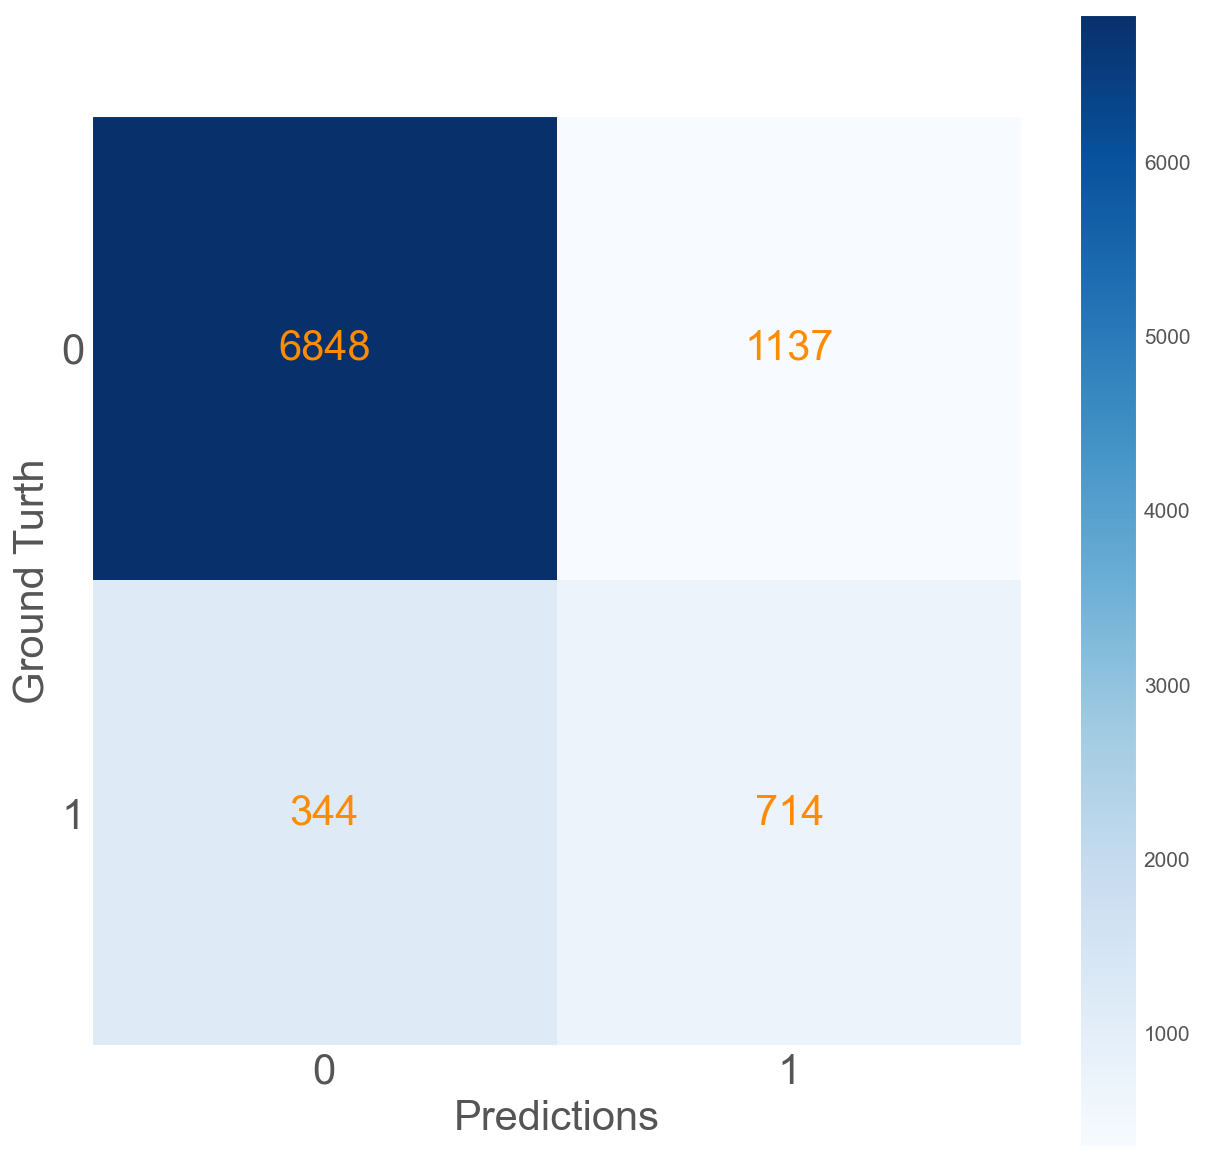

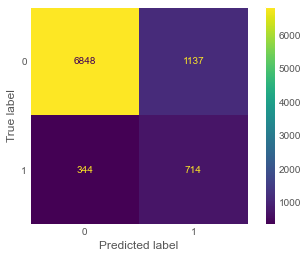

In [55]:
# Naive Bayes on the test set

seed = np.random.seed(4)

# Use the selected hyperparameters
nb = GaussianNB(var_smoothing = 5.336699231206302e-09)



# Feature selection: remove features with low variance (42 -> 40 features)
sel = VarianceThreshold(threshold=0.01)
sel_var=sel.fit_transform(X_train_o)
train_x_lv = X_train_o[X_train_o.columns[sel.get_support(indices=True)]]
test_x_lv = X_test_o[train_x_lv.columns]

# Feature selection: remove one of the highly correlated features > 0.8 (40 -> 39 features)
correlation_train = train_x_lv.corr(method="pearson")
columns = np.full((correlation_train.shape[0],), True, dtype=bool)
for i in range(correlation_train.shape[0]):
    for j in range(i+1, correlation_train.shape[0]):
        if abs(correlation_train.iloc[i,j]) >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = train_x_lv.columns[columns]
train_x_cf = train_x_lv[selected_columns]
test_x_cf = test_x_lv[selected_columns]

# Undersampling
train_x_os,train_y_os = re_sample(train_x_cf, y_train_o, func='random_under_sample', random_state=2021)



X_tr,  y_tr = train_x_os, train_y_os
X_t,  y_t = test_x_cf, y_test_o

# Train the model
nb.fit(X_tr, y_tr)
nb_predict = nb.predict(X_t)
nb_predict_prob = nb.predict_proba(X_t)


fpr_nb, tpr_nb, auc_nb = compute_and_plot_roc_curve(nb,X_t,  y_t,"Naive Bayes")

model_nb = model_report(nb,X_t,  y_t,"Naive Bayes")
model_nb

## SVM

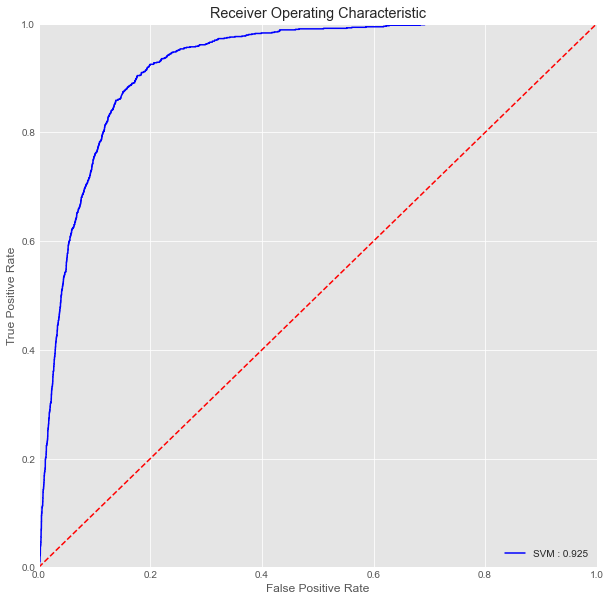

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7985
           1       0.42      0.88      0.57      1058

    accuracy                           0.85      9043
   macro avg       0.70      0.86      0.74      9043
weighted avg       0.92      0.85      0.87      9043



Model  Recall_score  Precision  f1_score  Area_under_curve  Kappa_metric  \
0   SVM         0.880      0.425     0.573             0.925         0.493   

    MCC  
0 0.542

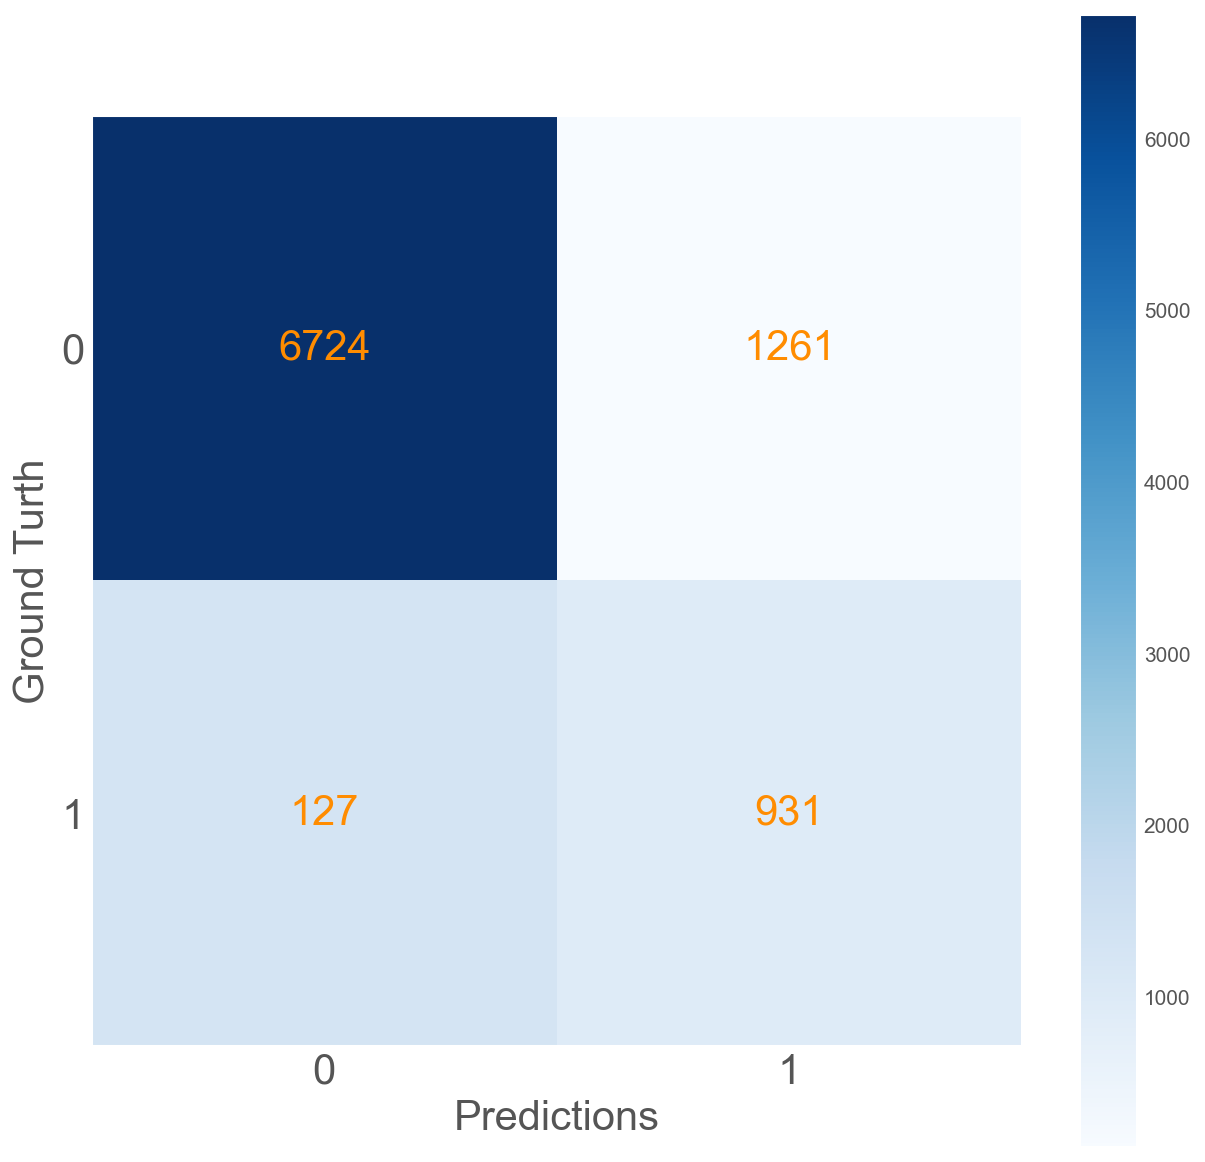

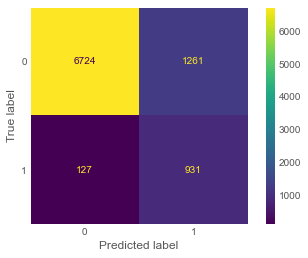

In [56]:
# Test
seed = np.random.seed(2021)
# Feature Scaling
scaler = MinMaxScaler()
train_X_scaled = scaler.fit_transform(X_train_o)
test_X_scaled = scaler.transform(X_test_o)

# resample
X_train_re, y_train_re = re_sample(train_X_scaled, y_train_o, func='random_under_sample')

X_tr,  y_tr = X_train_re, y_train_re
X_t,  y_t = test_X_scaled, y_test_o


svm = SVC(C=1000,gamma=0.01,kernel='rbf',probability=True)
svm.fit(X_tr,  y_tr)
svc_predicted = svm.predict(X_t)
svc_probs = svm.predict_proba(X_t)

fpr_svm, tpr_svm, auc_svm = compute_and_plot_roc_curve(svm, X_t,  y_t,"SVM")

model_svm = model_report(svm, X_t,  y_t,"SVM")
model_svm

## Decision Tree

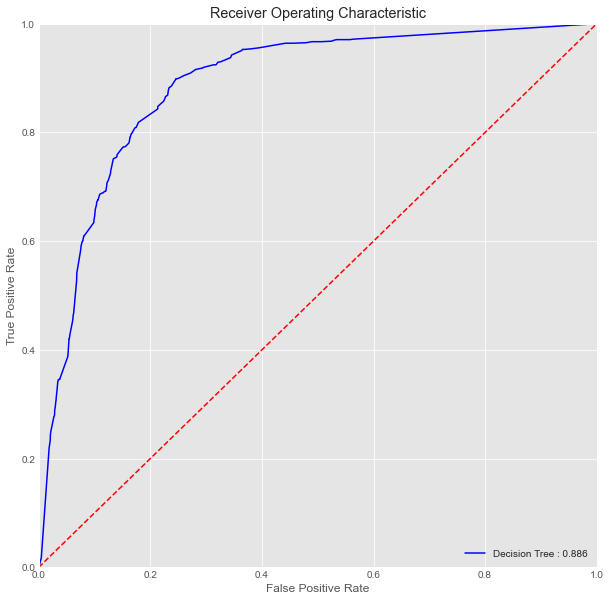

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      7985
           1       0.45      0.68      0.55      1058

    accuracy                           0.87      9043
   macro avg       0.70      0.79      0.73      9043
weighted avg       0.90      0.87      0.88      9043



Model  Recall_score  Precision  f1_score  Area_under_curve  \
0  Decision Tree         0.684      0.454     0.546             0.886   

   Kappa_metric   MCC  
0         0.472 0.486

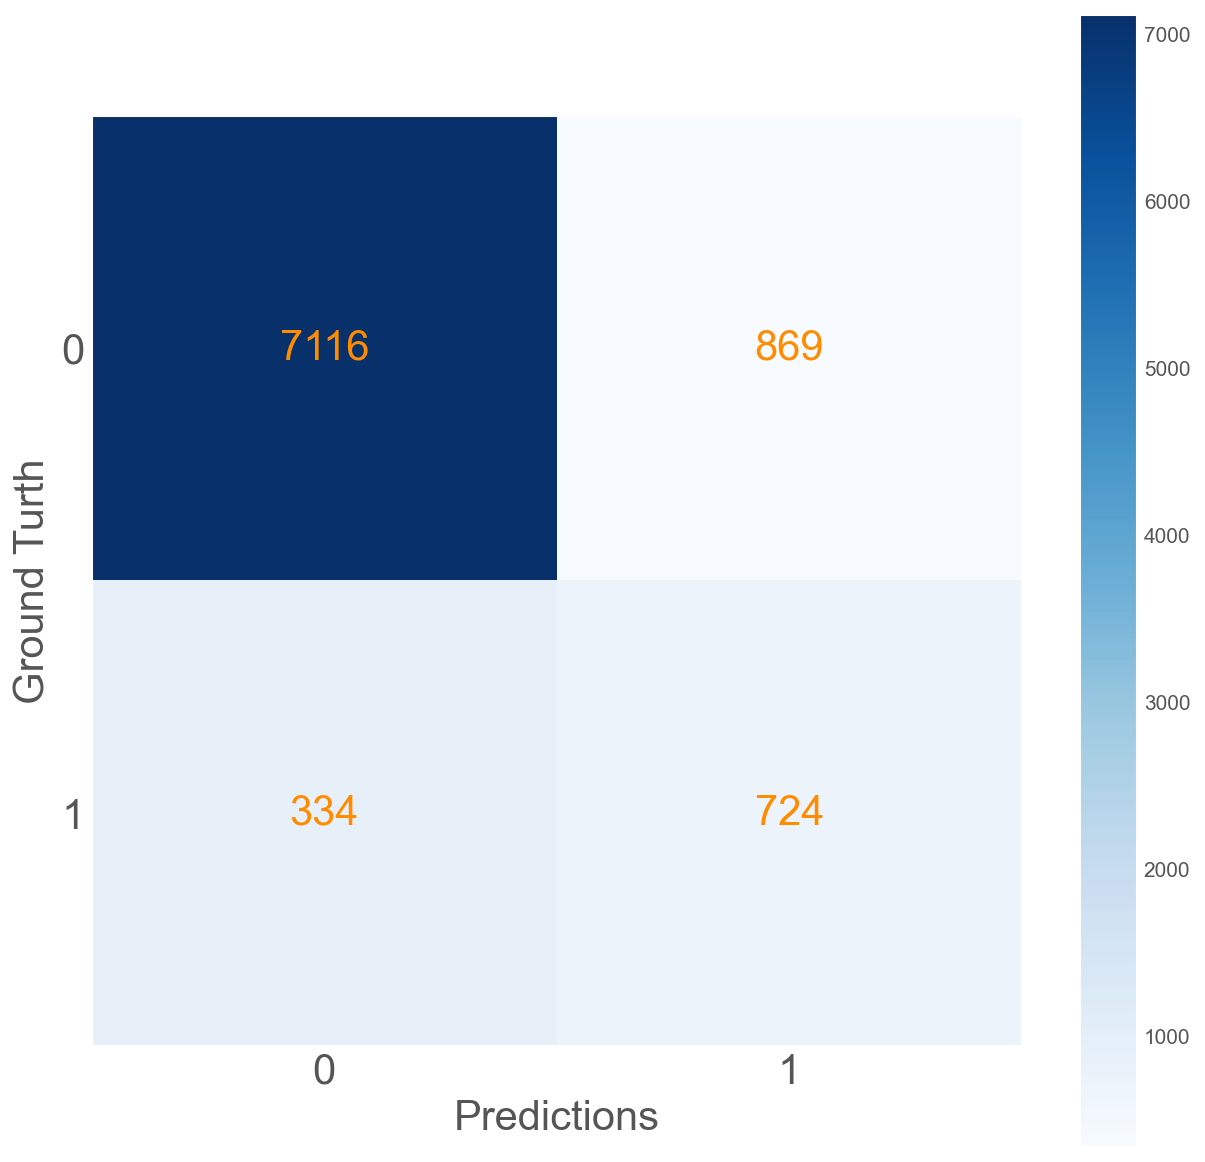

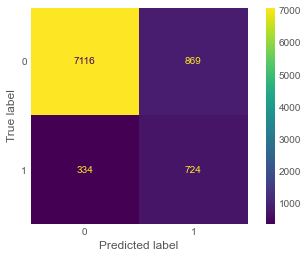

In [57]:
max_depth = 9    
func      = 'SMOTE'
criterion = 'entropy'
seed = np.random.seed(2021)

# resample
X_train_re, y_train_re = re_sample(X_train_o, y_train_o, func=func)

X_tr,  y_tr = X_train_re, y_train_re
X_t,  y_t = X_test_o, y_test_o

# #predict
# predicted = knn.predict(X_t)

tree = DecisionTreeClassifier(max_depth=max_depth,criterion=criterion)

model = tree.fit(X_train_re, y_train_re)

val_pred = model.predict(X_t)
predict_prob = tree.predict_proba(X_t)

fpr_tree, tpr_tree,auc_tree = compute_and_plot_roc_curve(model, X_t, y_t,"Decision Tree")

model_tree = model_report(model, X_t, y_t,"Decision Tree")
model_tree

## Neural network

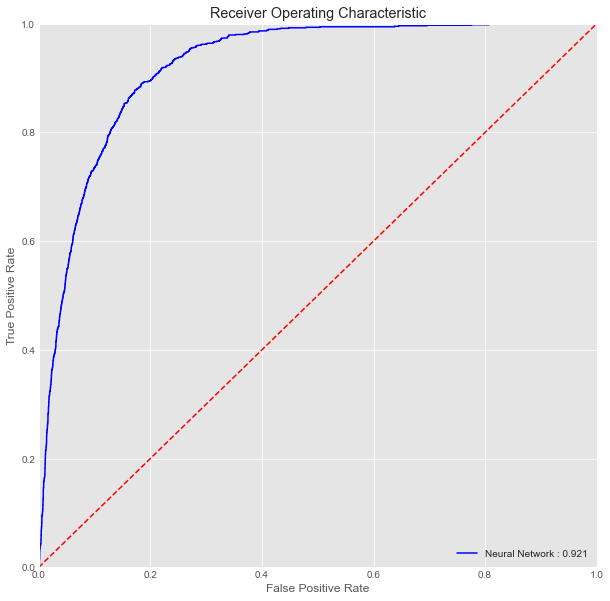

              precision    recall  f1-score   support

           0       0.97      0.89      0.92      7985
           1       0.47      0.76      0.58      1058

    accuracy                           0.87      9043
   macro avg       0.72      0.83      0.75      9043
weighted avg       0.91      0.87      0.88      9043



Model  Recall_score  Precision  f1_score  Area_under_curve  \
0  Neural Network         0.765      0.472     0.584             0.921   

   Kappa_metric   MCC  
0         0.514 0.534

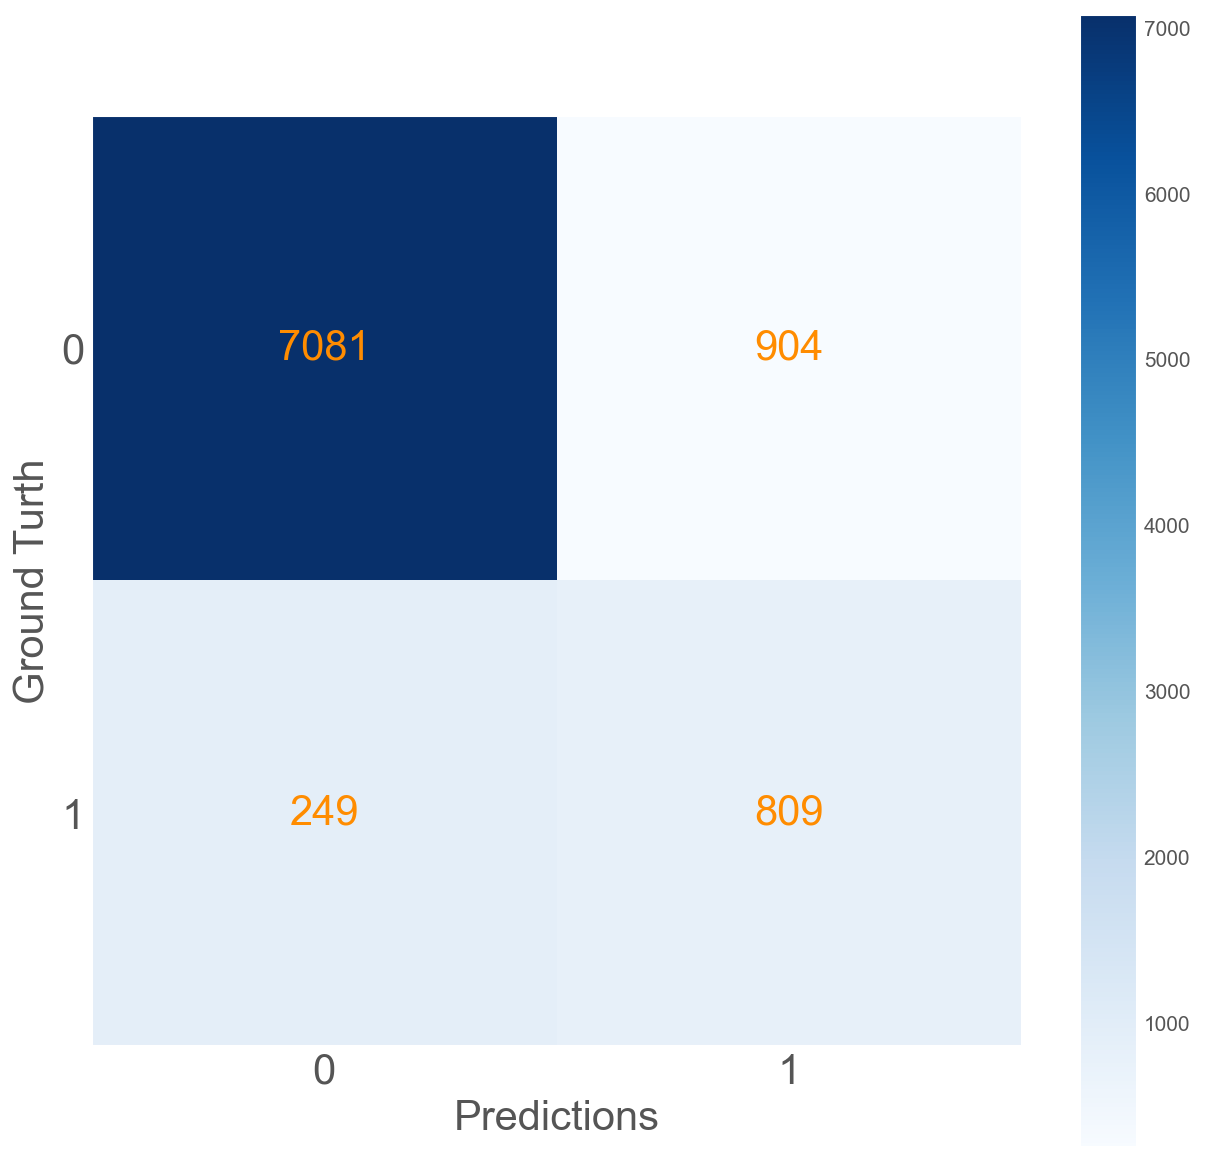

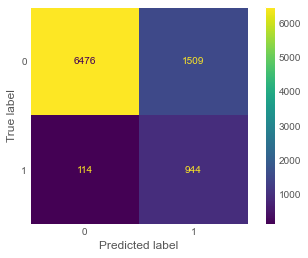

In [58]:


mp= MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5,2), random_state=1)
ann = MLPClassifier(
    activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
                   beta_2=0.999, early_stopping=False, epsilon=1e-08,
                   hidden_layer_sizes=(5, 2), learning_rate='constant',
                   learning_rate_init=0.001, max_iter=200, momentum=0.9,
                   nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
                   solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
                   warm_start=False
)


# normalization
scaler = StandardScaler()
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train_o)
# X_test_scaled = scaler.transform(X_test_o)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_o),columns=X_train_o.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_o),columns=X_test_o.columns)


# resample
X_train_re, y_train_re = re_sample(X_train_scaled, y_train_o, func=func)



# X_tr,  y_tr = re_sample(X_TRF, y_train, func = 'ClusterCentroids')
X_tr,  y_tr = X_train_re, y_train_re
X_t,  y_t = X_test_scaled, y_test


ann.fit(X_tr,  y_tr)

fpr_ann, tpr_ann, auc_ann = compute_and_plot_roc_curve(ann, X_t, y_t,"Neural Network")

model_ann = model_report(ann, X_t, y_t,"Neural Network", 
                         customerized_threshold=True,
                         threshold=0.7
                        )
model_ann


## Random Forest

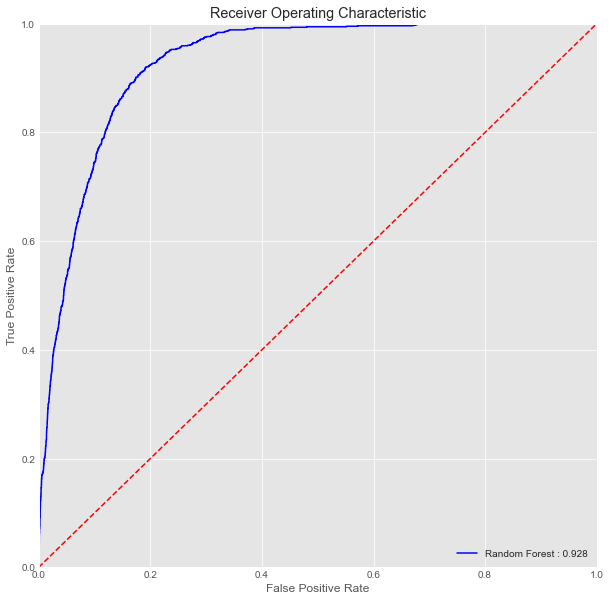

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      7985
           1       0.49      0.76      0.60      1058

    accuracy                           0.88      9043
   macro avg       0.73      0.83      0.76      9043
weighted avg       0.91      0.88      0.89      9043



Model  Recall_score  Precision  f1_score  Area_under_curve  \
0  Random Forest         0.758      0.494     0.598             0.928   

   Kappa_metric   MCC  
0         0.531 0.548

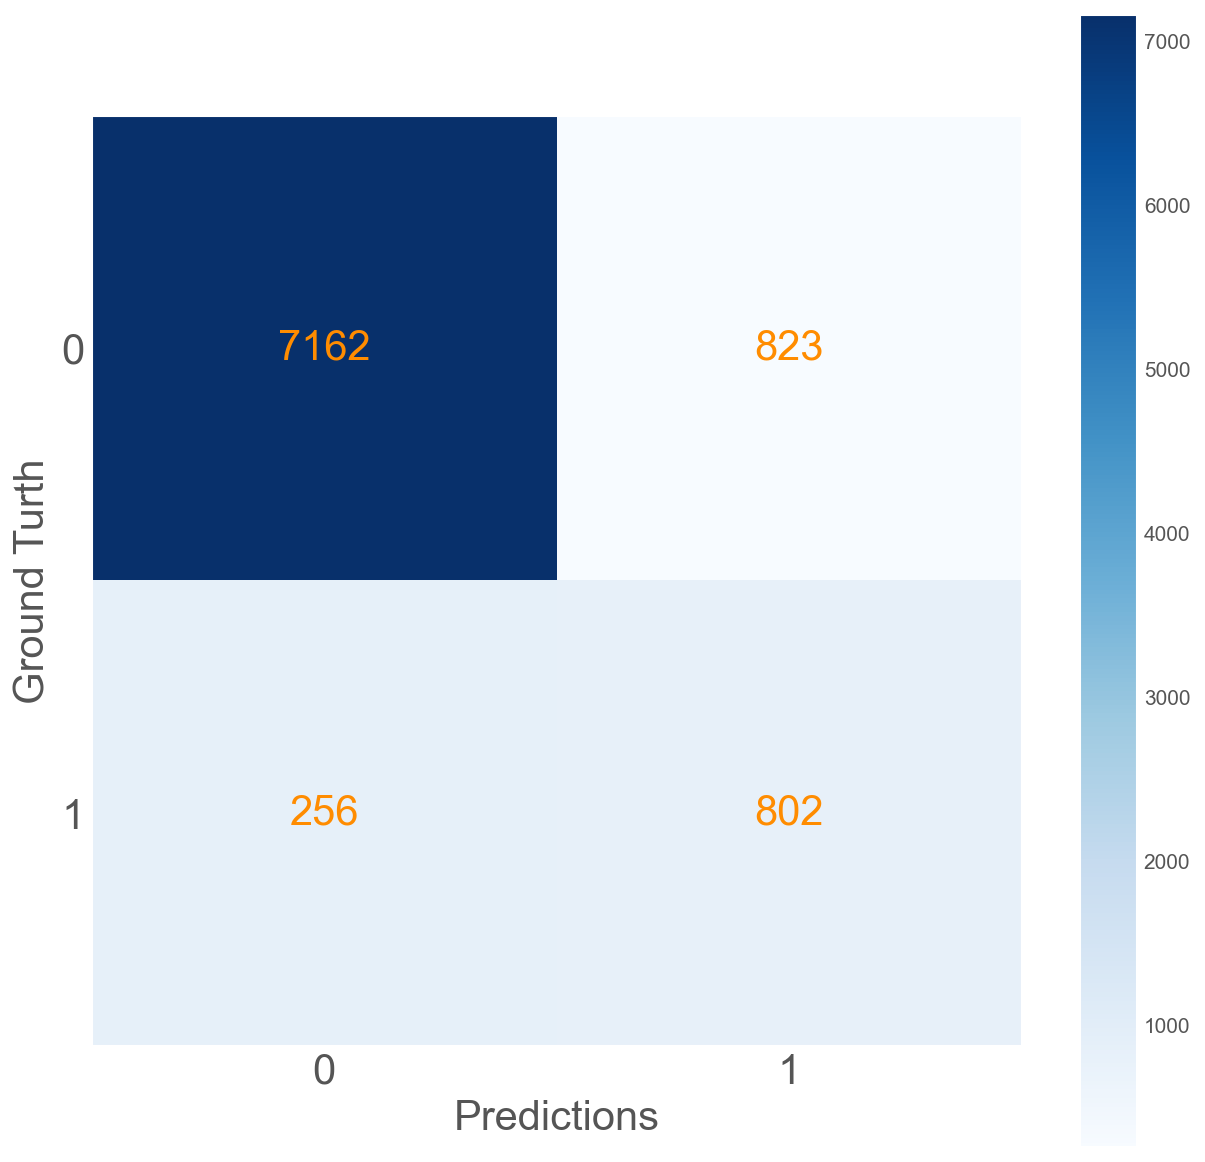

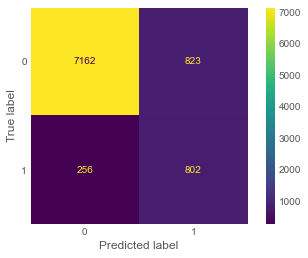

In [59]:
# Random Forest on the test set

seed = np.random.seed(2021)

# Use the selected hyperparameters
rf = RandomForestClassifier(criterion = 'entropy',
                            max_depth = 15,
                            max_features = 'sqrt',
                            n_estimators = 300,
                            class_weight = 'balanced',
                            random_state=2021)


# Feature selection: remove features with low variance (42 -> 40 features)
sel = VarianceThreshold(threshold=0.01)
sel_var=sel.fit_transform(X_train_o)
train_x_lv = X_train_o[X_train_o.columns[sel.get_support(indices=True)]]
test_x_lv = X_test_o[train_x_lv.columns]
#print(train_x_lv.shape)

# Feature selection: remove one of the highly correlated features > 0.8 (40 -> 39 features)
correlation_train = train_x_lv.corr(method="pearson")
columns = np.full((correlation_train.shape[0],), True, dtype=bool)
for i in range(correlation_train.shape[0]):
    for j in range(i+1, correlation_train.shape[0]):
        if abs(correlation_train.iloc[i,j]) >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = train_x_lv.columns[columns]
train_x_cf = train_x_lv[selected_columns]
test_x_cf = test_x_lv[selected_columns]
#print(train_x_cf.shape)

X_tr,  y_tr = train_x_cf, y_train_o
X_t,  y_t = test_x_cf, y_test_o


# Train the model
rf.fit(X_tr,  y_tr)
# rf_predict = rf.predict(test_x_cf)
rf_predict_prob = rf.predict_proba(test_x_cf)

fpr_rf, tpr_rf, auc_rf = compute_and_plot_roc_curve(rf, X_t, y_t,"Random Forest")

model_rf = model_report(rf, X_t, y_t,"Random Forest")
model_rf


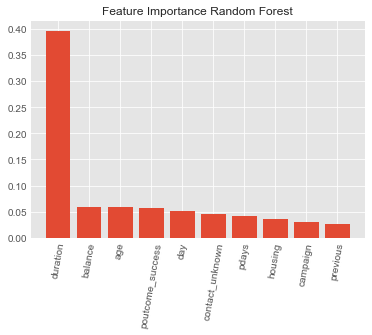

In [60]:
# Feature importance
ranking = rf.feature_importances_
features = np.argsort(ranking)[::-1][:10]
columns = train_x_os.columns
plt.title("Feature Importance Random Forest", y = 1, size = 12)
plt.bar(range(len(features)), ranking[features], align="center")
plt.xticks(range(len(features)), columns[features], rotation=80)
plt.show()

## AdaBoost

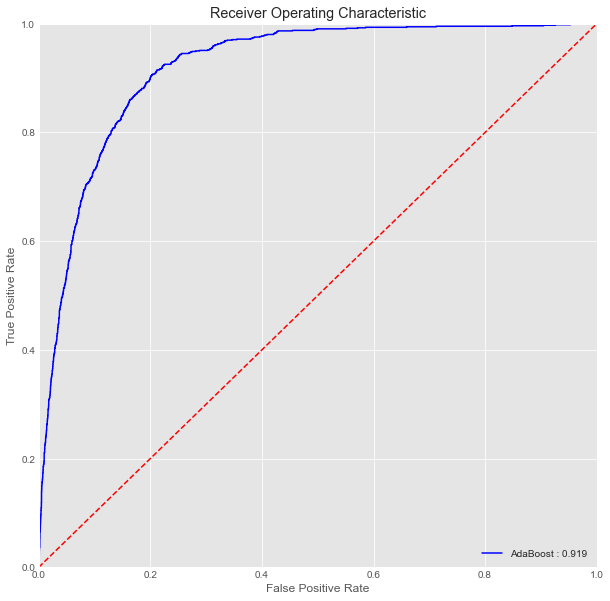

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7985
           1       0.63      0.41      0.50      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.69      0.72      9043
weighted avg       0.89      0.90      0.89      9043



Model  Recall_score  Precision  f1_score  Area_under_curve  \
0  AdaBoost         0.414      0.635     0.501             0.919   

   Kappa_metric   MCC  
0         0.450 0.463

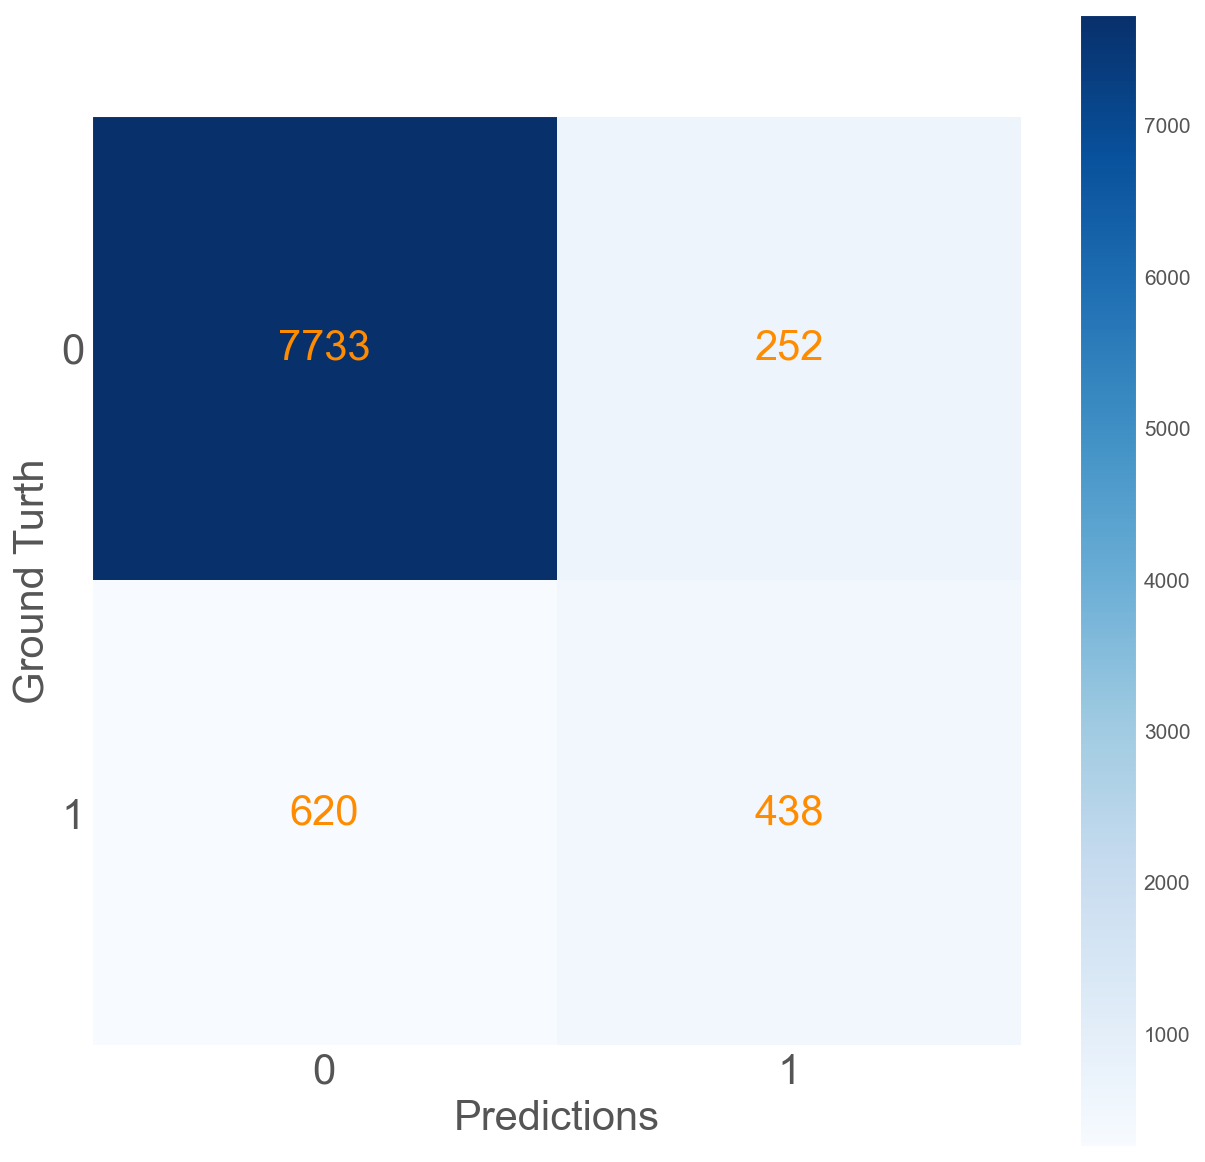

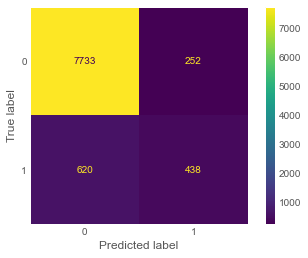

In [61]:
# Test

seed = np.random.seed(2021)
# Outliers detection
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train_o)
mask = yhat != -1

train_x, train_y = X_train_o.iloc[mask], y_train_o[mask]

X_tr,  y_tr = train_x, train_y
X_t,  y_t = X_test_o, y_test_o

adab_ro = AdaBoostClassifier(n_estimators=2000,learning_rate=0.1)
adab_ro.fit(train_x,train_y)
adab_predicted = adab_ro.predict(X_test_o)
adab_probs = adab_ro.predict_proba(X_test_o)
adab_preds_probs = adab_probs[:,1]

fpr_adaboost, tpr_adaboost, auc_adaboost = compute_and_plot_roc_curve(adab_ro, X_t, y_t,"AdaBoost")

model_adaboost = model_report(adab_ro, X_t, y_t,"AdaBoost")
model_adaboost

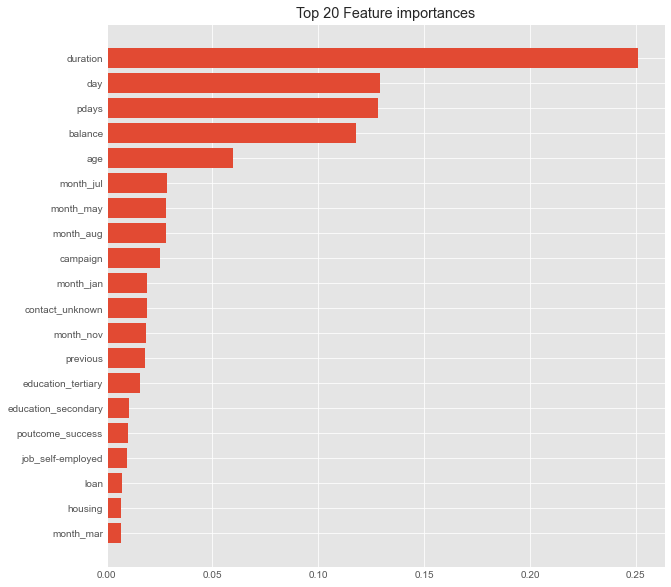

In [62]:
# Feature Importance
importances = adab_ro.feature_importances_
indices = np.argsort(-importances)[::-1][-20:]
n_features = X_train_o.shape[1]

# Plot the impurity-based feature importances
plt.figure(figsize=(10,10))
plt.title("Top 20 Feature importances")
plt.barh(range(20), importances[indices], align="center")
plt.yticks(range(20), train_x.columns.values[indices])
plt.show()

## CatBoost

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

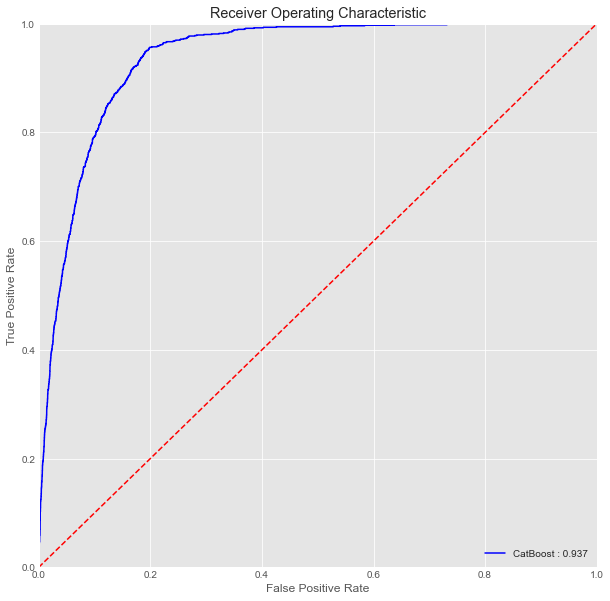

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7985
           1       0.46      0.86      0.60      1058

    accuracy                           0.87      9043
   macro avg       0.72      0.87      0.76      9043
weighted avg       0.92      0.87      0.88      9043



Model  Recall_score  Precision  f1_score  Area_under_curve  \
0  CatBoost         0.865      0.462     0.602             0.937   

   Kappa_metric   MCC  
0         0.531 0.568

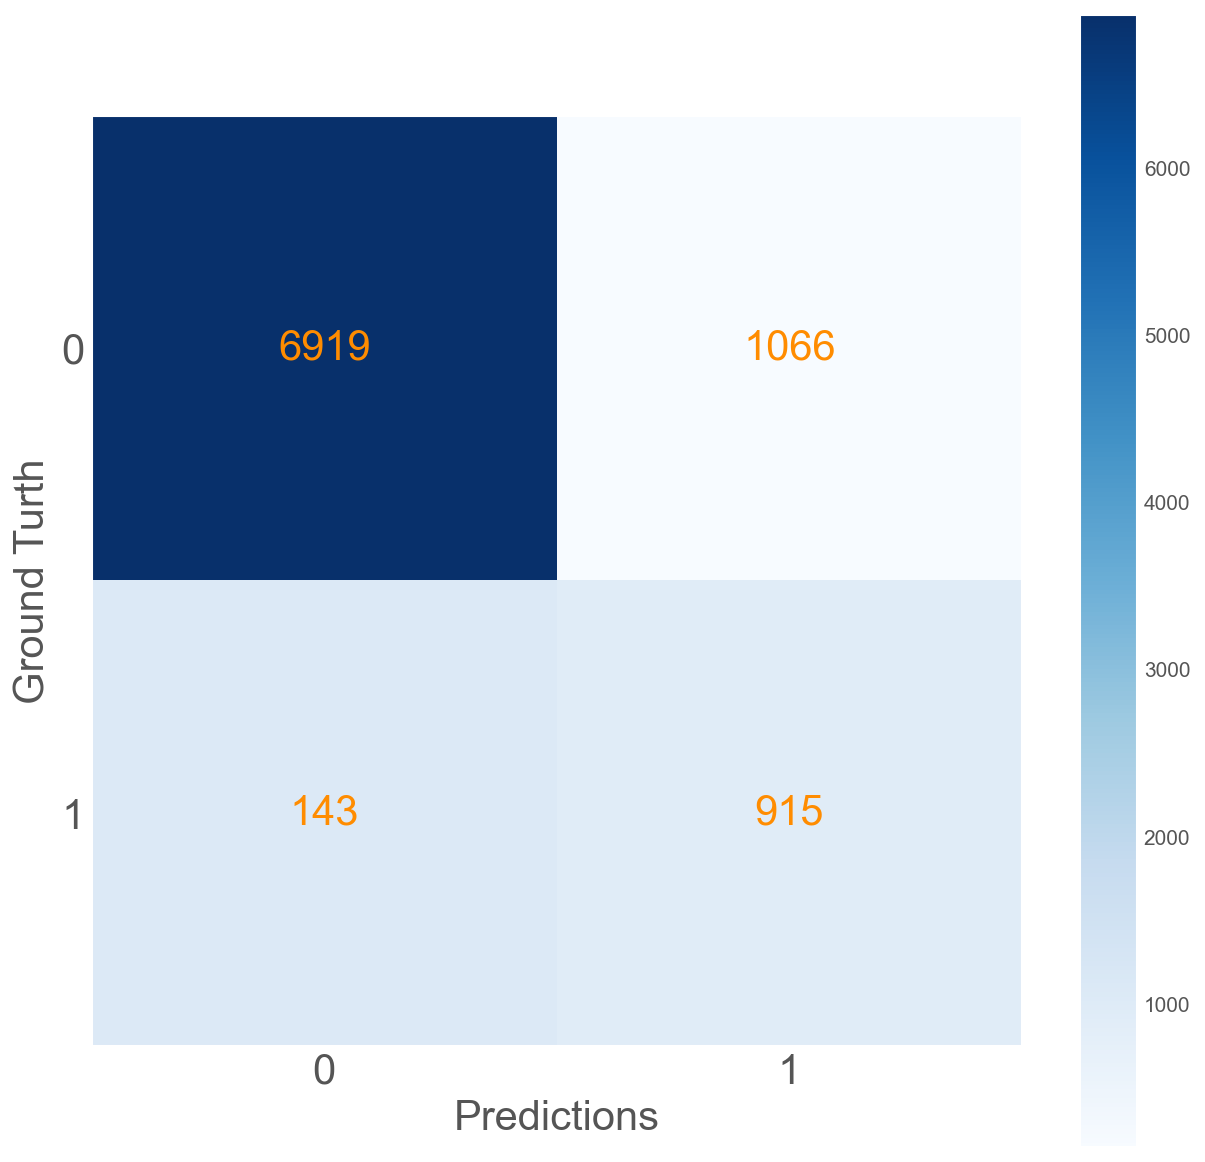

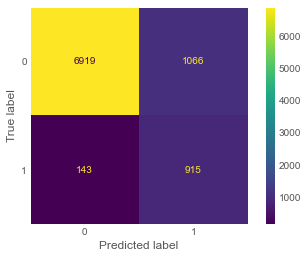

In [63]:
#'random_over_sample','SMOTE','ADASYN','BorderlineSMOTE','KMeansSMOTE', 'ClusterCentroids','random_under_sample'
mcc_scorer = make_scorer(matthews_corrcoef)
X_train_re, y_train_re = re_sample(X_train, y_train, func='random_over_sample')

X_tr,  y_tr = X_train_re, y_train_re
X_t,  y_t = X_test, y_test


# bank_use = ['job',
#              'marital',
#              'education',
#              'default',
#              'housing',
#              'loan',
#              'contact',
#              'month',
#              'poutcome',
#              'day'
#            ]
# categorical_features_indices = [i for i in bank_use if i in X_tr.columns.tolist()]

cat = CatBoostClassifier(
                         iterations=200, 
#                          depth=5,
#                          cat_features=categorical_features_indices,
#                          learning_rate=0.5, 
                         loss_function='Logloss',
                         logging_level='Silent')


cat.fit(X_tr,  y_tr,
        plot=True, 
        eval_set=(X_t,  y_t))


# fpr_catboost, tpr_catboost, auc_catboost = compute_and_plot_roc_curve(cat, X_t, y_t,"CatBoost",
#                                                                       customerized_threshold=True,threshold=threshold)

fpr_catboost, tpr_catboost, auc_catboost = compute_and_plot_roc_curve(cat, X_t, y_t,"CatBoost")


model_catboost = model_report(cat, X_t, y_t,"CatBoost")
# model_catboost = model_report(cat, X_t, y_t,"CatBoost",customerized_threshold=True,threshold=threshold)
model_catboost
# default + ros =0.574

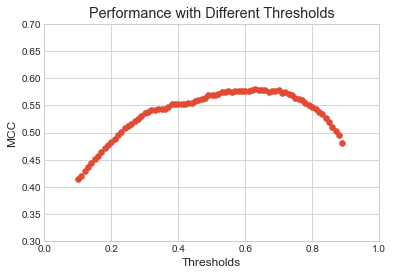

0.6299999999999997

In [64]:
find_best_threshold(0.1, 0.9, cat,X_t, y_t)

<BarContainer object of 17 artists>

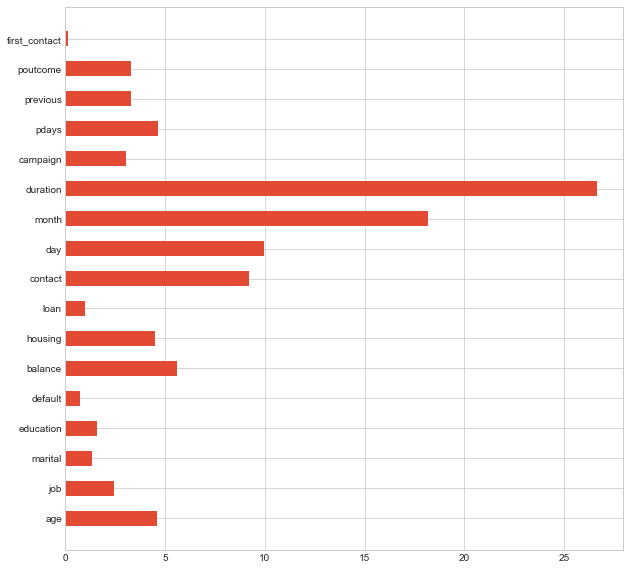

In [65]:
fea_ = cat.feature_importances_
fea_name = cat.feature_names_
plt.figure(figsize=(10, 10))
plt.barh(fea_name,fea_,height =0.5)

## XGBoost

[12:07:16] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:07:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


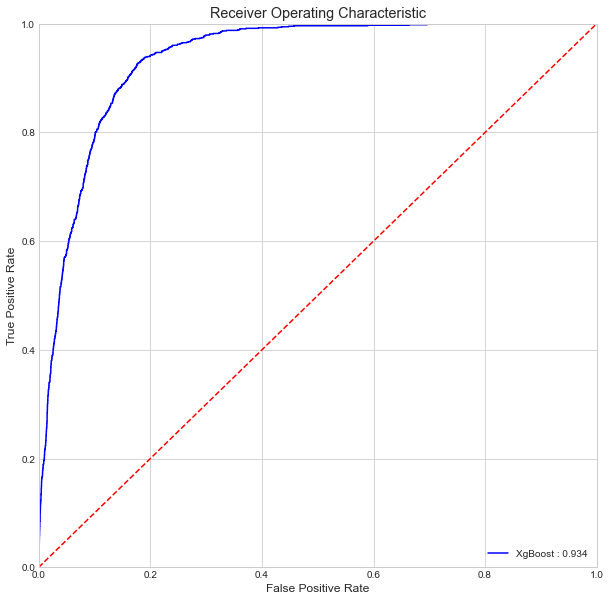

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      7985
           1       0.51      0.80      0.62      1058

    accuracy                           0.89      9043
   macro avg       0.74      0.85      0.78      9043
weighted avg       0.92      0.89      0.90      9043



Model  Recall_score  Precision  f1_score  Area_under_curve  Kappa_metric  \
0  XgBoost         0.802      0.507     0.621             0.934         0.558   

    MCC  
0 0.578

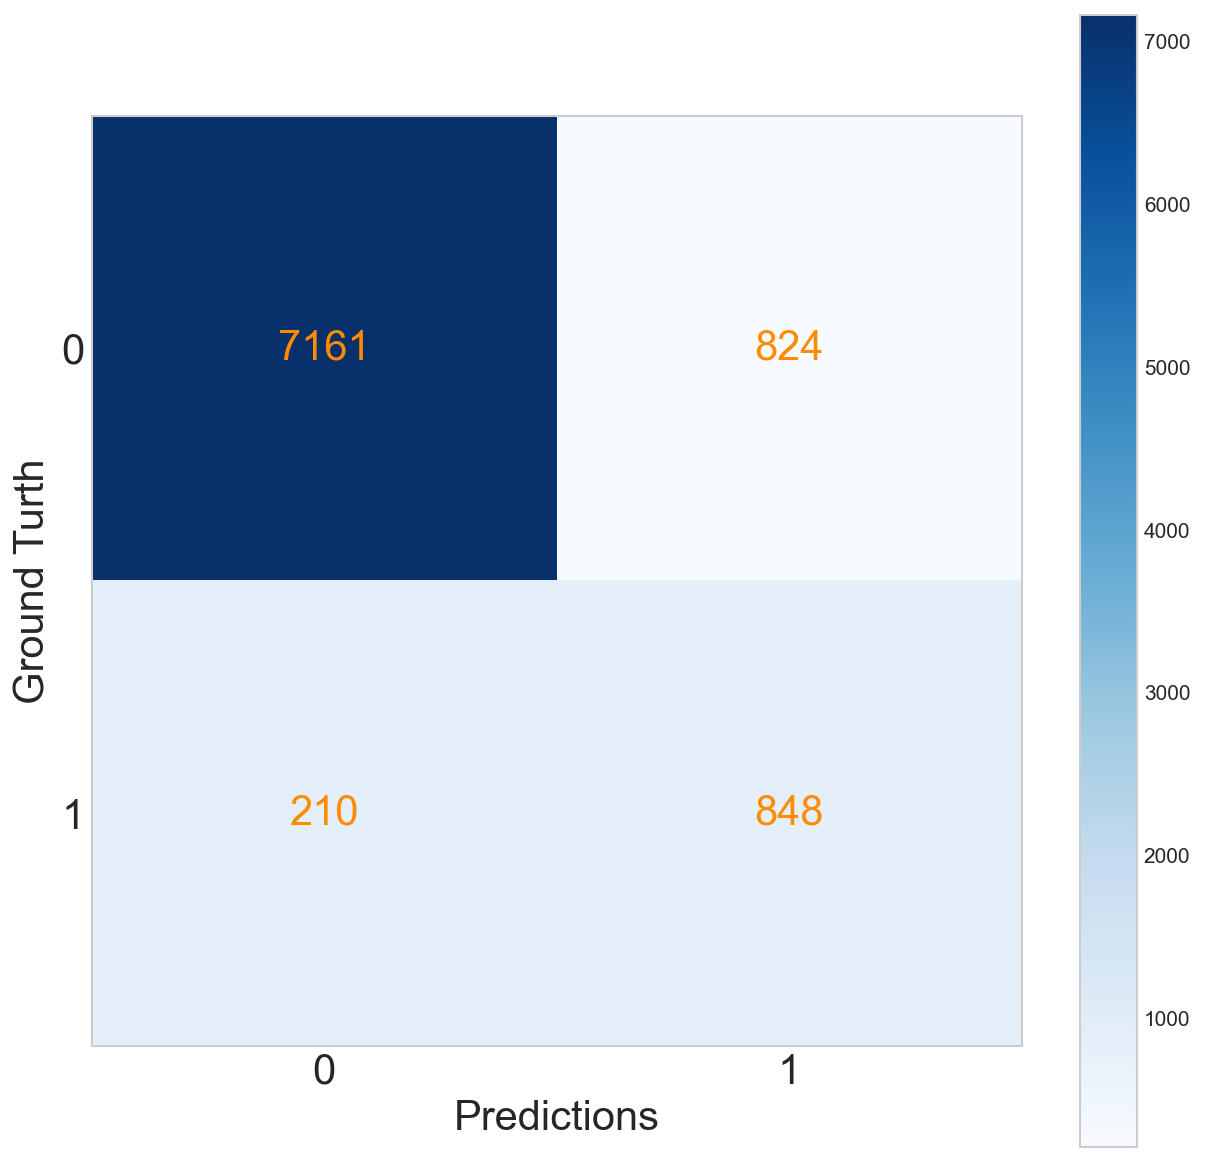

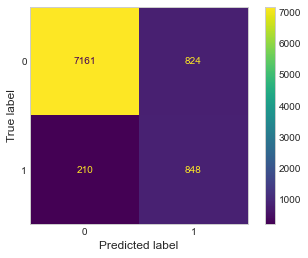

In [66]:
params={
        'scale_pos_weight':9,
        'booster':'gbtree',
        'n_estimators':400,
        'gamma':0.1, 
        'max_depth':8, 
        'lambda':2,  
        'subsample':0.8, 
        'colsample_bytree':0.9,
        'min_child_weight':4, 
        'silent':1 ,
        'eta': 0.07, 
        'seed':0,
        'alpha':1,
            }

xgboost = xgb.XGBClassifier(**params)



X_tr,  y_tr = X_train_o, y_train_o
X_t,  y_t = X_test_o, y_test_o

# Train the model
xgboost.fit(X_tr,  y_tr)


fpr_xgboost, tpr_xgboost, auc_xgboost = compute_and_plot_roc_curve(xgboost, X_t, y_t,"XgBoost")

model_xgboost = model_report(xgboost, X_t, y_t,"XgBoost")
model_xgboost

## LightGBM

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


<Figure size 864x432 with 0 Axes>

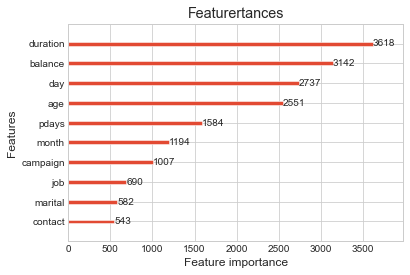

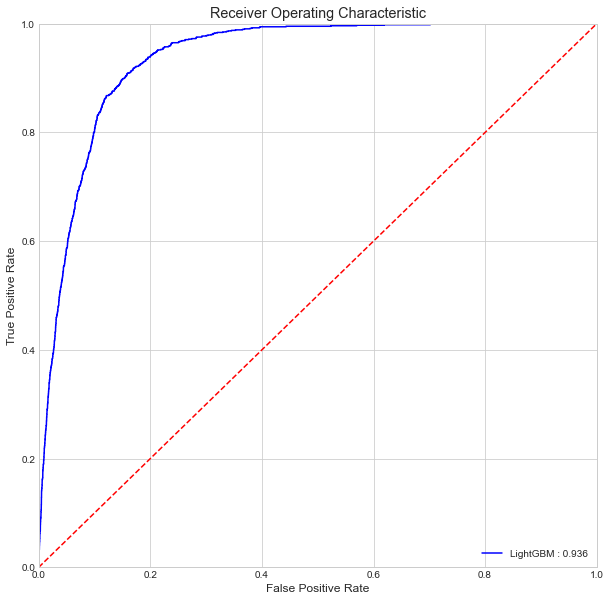

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      7985
           1       0.51      0.83      0.63      1058

    accuracy                           0.89      9043
   macro avg       0.74      0.86      0.78      9043
weighted avg       0.92      0.89      0.90      9043



Model  Recall_score  Precision  f1_score  Area_under_curve  \
0  LightGBM         0.832      0.508     0.631             0.936   

   Kappa_metric   MCC  
0         0.568 0.592

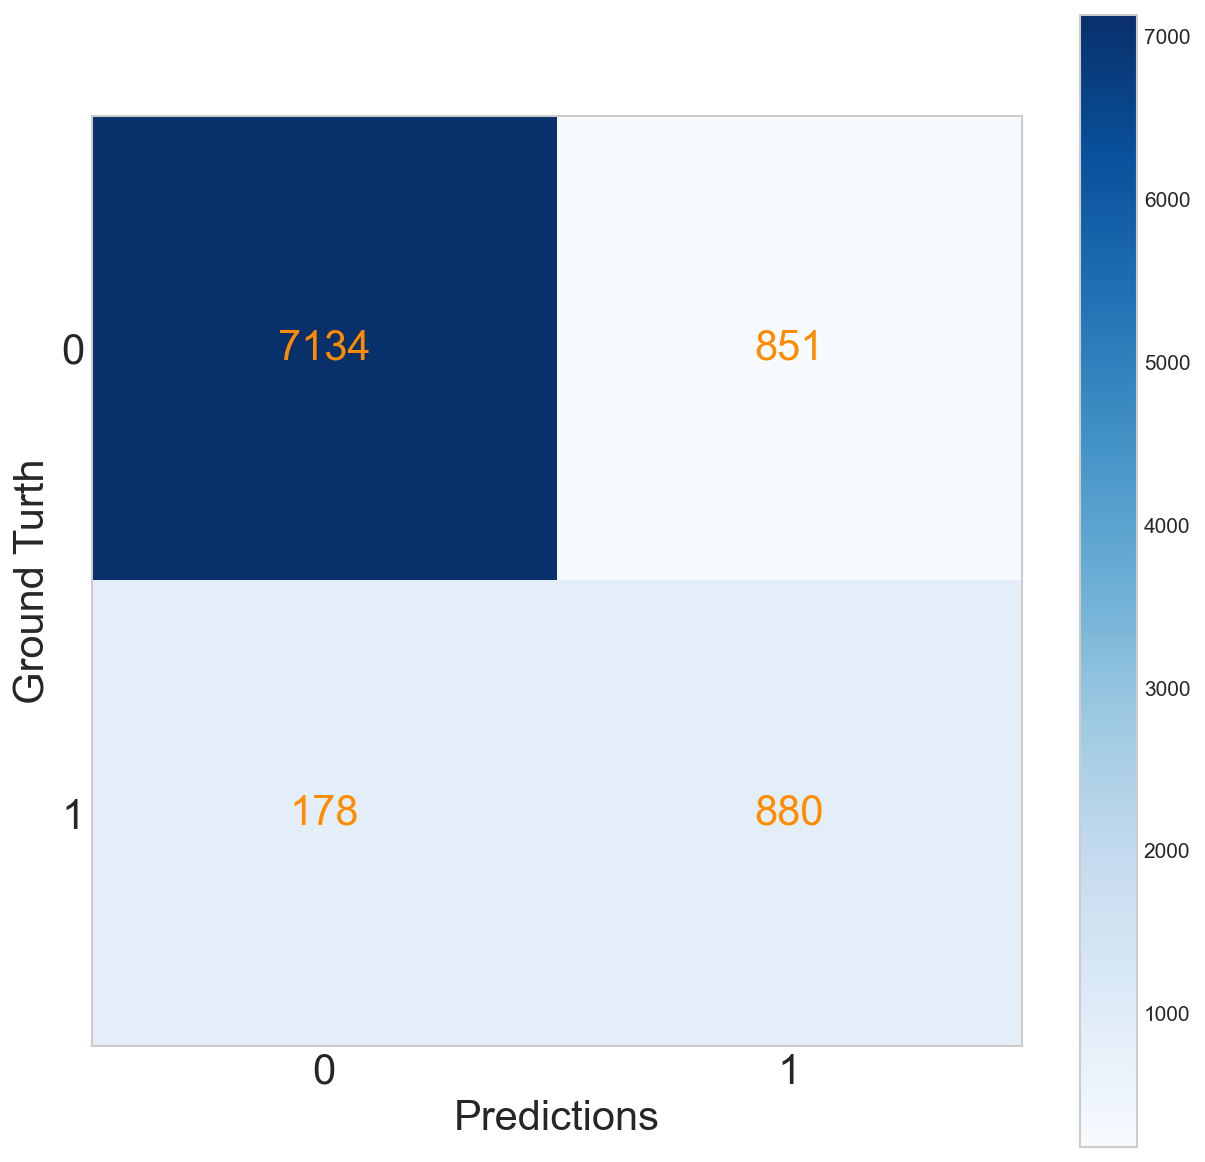

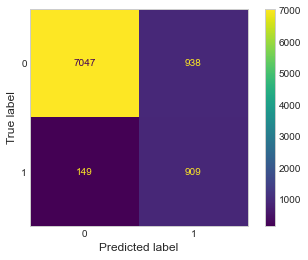

In [108]:
#Predict
params_best = {
    'task': 'train',
    'boosting_type': 'gbdt',  
    'objective': 'binary',  
    'metric': 'mcc',
    'learning_rate': 0.05,
    'num_leaves': 100,  
    'max_depth':8,  
    'feature_fraction': 0.9,  # prevent from overfitting
    'bagging_freq':2,  # prevent from overfitting
    'bagging_fraction': 0.8,  # prevent from overfitting
    'min_child_samples': 20,  # prevent from overfitting
    'min_child_weight':0.001,
    #'reg_alpha' : 0.001,
    #'reg_lambda': 6,
    'nthread': -1, #use all
    'header': True,
    'is_unbalance': True,
    'verbose': -1,
    'num_iterations' : 200, 
    'random_state': 2021
}


lightgbm = lgb.LGBMClassifier(**params_best)

# feature selection: remove features with low variance
sel = VarianceThreshold(threshold=0.01)
sel_var=sel.fit_transform(X_train)
X_TR = X_train[X_train.columns[sel.get_support(indices=True)]]
X_T = X_test[X_TR.columns]
    
# feature selection: remove one of the highly correlated features
correlation_train = X_TR.corr(method="pearson")
columns = np.full((correlation_train.shape[0],), True, dtype=bool)
for i in range(correlation_train.shape[0]):
    for j in range(i+1, correlation_train.shape[0]):
        if abs(correlation_train.iloc[i,j]) >= 0.8:
            if columns[j]:
                columns[j] = False


selected_columns = X_TR.columns[columns]
X_TRF = X_TR[selected_columns]
X_TF = X_T[selected_columns]


X_tr,  y_tr = X_TRF, y_train
X_t,  y_t = X_TF, y_test
#train on train set
lightgbm.fit(X_tr, y_tr,categorical_feature = [i for i in bank_str if i in selected_columns.tolist()])

#predict
# lgb_predicted = model.predict(X_t)
lgb_predicted_prob = lightgbm.predict_proba(X_t)   


#feature importance
plt.figure(figsize=(12,6))
lgb.plot_importance(lightgbm, max_num_features=10)
plt.title("Featurertances")
plt.show()

# print(pd.DataFrame([[lgb_f1[0],lgb_recall[0],lgb_precision[0],lgb_mcc[0],lgb_auc[0]]],row,col)) 

fpr_lightgbm, tpr_lightgbm, auc_lightgbm = compute_and_plot_roc_curve(lightgbm,X_t, y_t,"LightGBM")

threshold = 0.55
# threshold = 0.3535
model_lightgbm = model_report(lightgbm,X_t, y_t,"LightGBM",customerized_threshold=True,threshold=threshold)
model_lightgbm

threshold:0.100 --->MCC:0.455
threshold:0.110 --->MCC:0.462
threshold:0.120 --->MCC:0.470
threshold:0.130 --->MCC:0.478
threshold:0.140 --->MCC:0.484
threshold:0.150 --->MCC:0.489
threshold:0.160 --->MCC:0.495
threshold:0.170 --->MCC:0.499
threshold:0.180 --->MCC:0.505
threshold:0.190 --->MCC:0.508
threshold:0.200 --->MCC:0.511
threshold:0.210 --->MCC:0.515
threshold:0.220 --->MCC:0.518
threshold:0.230 --->MCC:0.521
threshold:0.240 --->MCC:0.524
threshold:0.250 --->MCC:0.526
threshold:0.260 --->MCC:0.530
threshold:0.270 --->MCC:0.531
threshold:0.280 --->MCC:0.535
threshold:0.290 --->MCC:0.538
threshold:0.300 --->MCC:0.540
threshold:0.310 --->MCC:0.543
threshold:0.320 --->MCC:0.548
threshold:0.330 --->MCC:0.551
threshold:0.340 --->MCC:0.553
threshold:0.350 --->MCC:0.558
threshold:0.360 --->MCC:0.559
threshold:0.370 --->MCC:0.560
threshold:0.380 --->MCC:0.565
threshold:0.390 --->MCC:0.566
threshold:0.400 --->MCC:0.567
threshold:0.410 --->MCC:0.569
threshold:0.420 --->MCC:0.572
threshold:

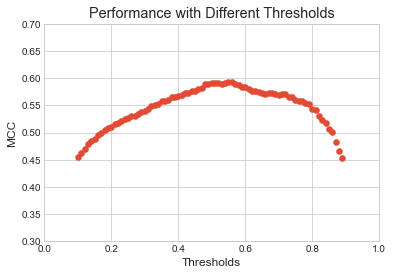

0.5499999999999998

In [111]:
find_best_threshold(0.1, 0.9, lightgbm,X_t, y_t)

In [69]:
predictions = lightgbm.predict_proba(X_t)
predictions[:,1]

array([0.03370577, 0.17613412, 0.91151207, ..., 0.00133515, 0.20930469,
       0.72278974])

(array([688., 586., 483., 360., 297., 226., 193., 181., 150., 144., 128.,
        106.,  85.,  94.,  89.,  84.,  78.,  54.,  62.,  58.,  57.,  60.,
         56.,  41.,  46.,  32.,  41.,  35.,  29.,  35.,  35.,  28.,  35.,
         33.,  22.,  35.,  28.,  18.,  28.,  18.,  25.,  29.,  24.,  17.,
         13.,  26.,  22.,  16.,  21.,  28.,  23.,  13.,  16.,  23.,  13.,
         10.,  16.,  22.,  12.,  16.,  10.,  19.,  19.,   6.,  17.,   6.,
          9.,  18.,   8.,  11.,  18.,  12.,  10.,   5.,   6.,  16.,  14.,
         16.,  13.,  11.,   6.,  16.,   7.,  11.,  14.,   4.,  10.,  13.,
          8.,  13.,  10.,   7.,  13.,  10.,   6.,   7.,   4.,  14.,  13.,
          7.,   4.,  12.,  10.,   2.,   9.,   8.,   5.,   8.,   8.,   8.,
          8.,   9.,   7.,   7.,   5.,   6.,   8.,   9.,   6.,   6.,   8.,
          7.,   7.,   9.,  10.,  10.,   5.,   8.,   7.,   7.,   9.,   7.,
         10.,   7.,   3.,  10.,   9.,   5.,   3.,   5.,   5.,   8.,   6.,
          1.,   3.,   9.,   6.,   7., 

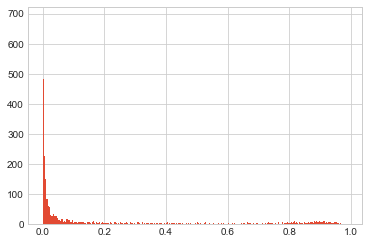

In [70]:
plt.hist(predictions[:,1], 1000)

In [71]:
# plot_target_distribution(lightgbm,X_t)

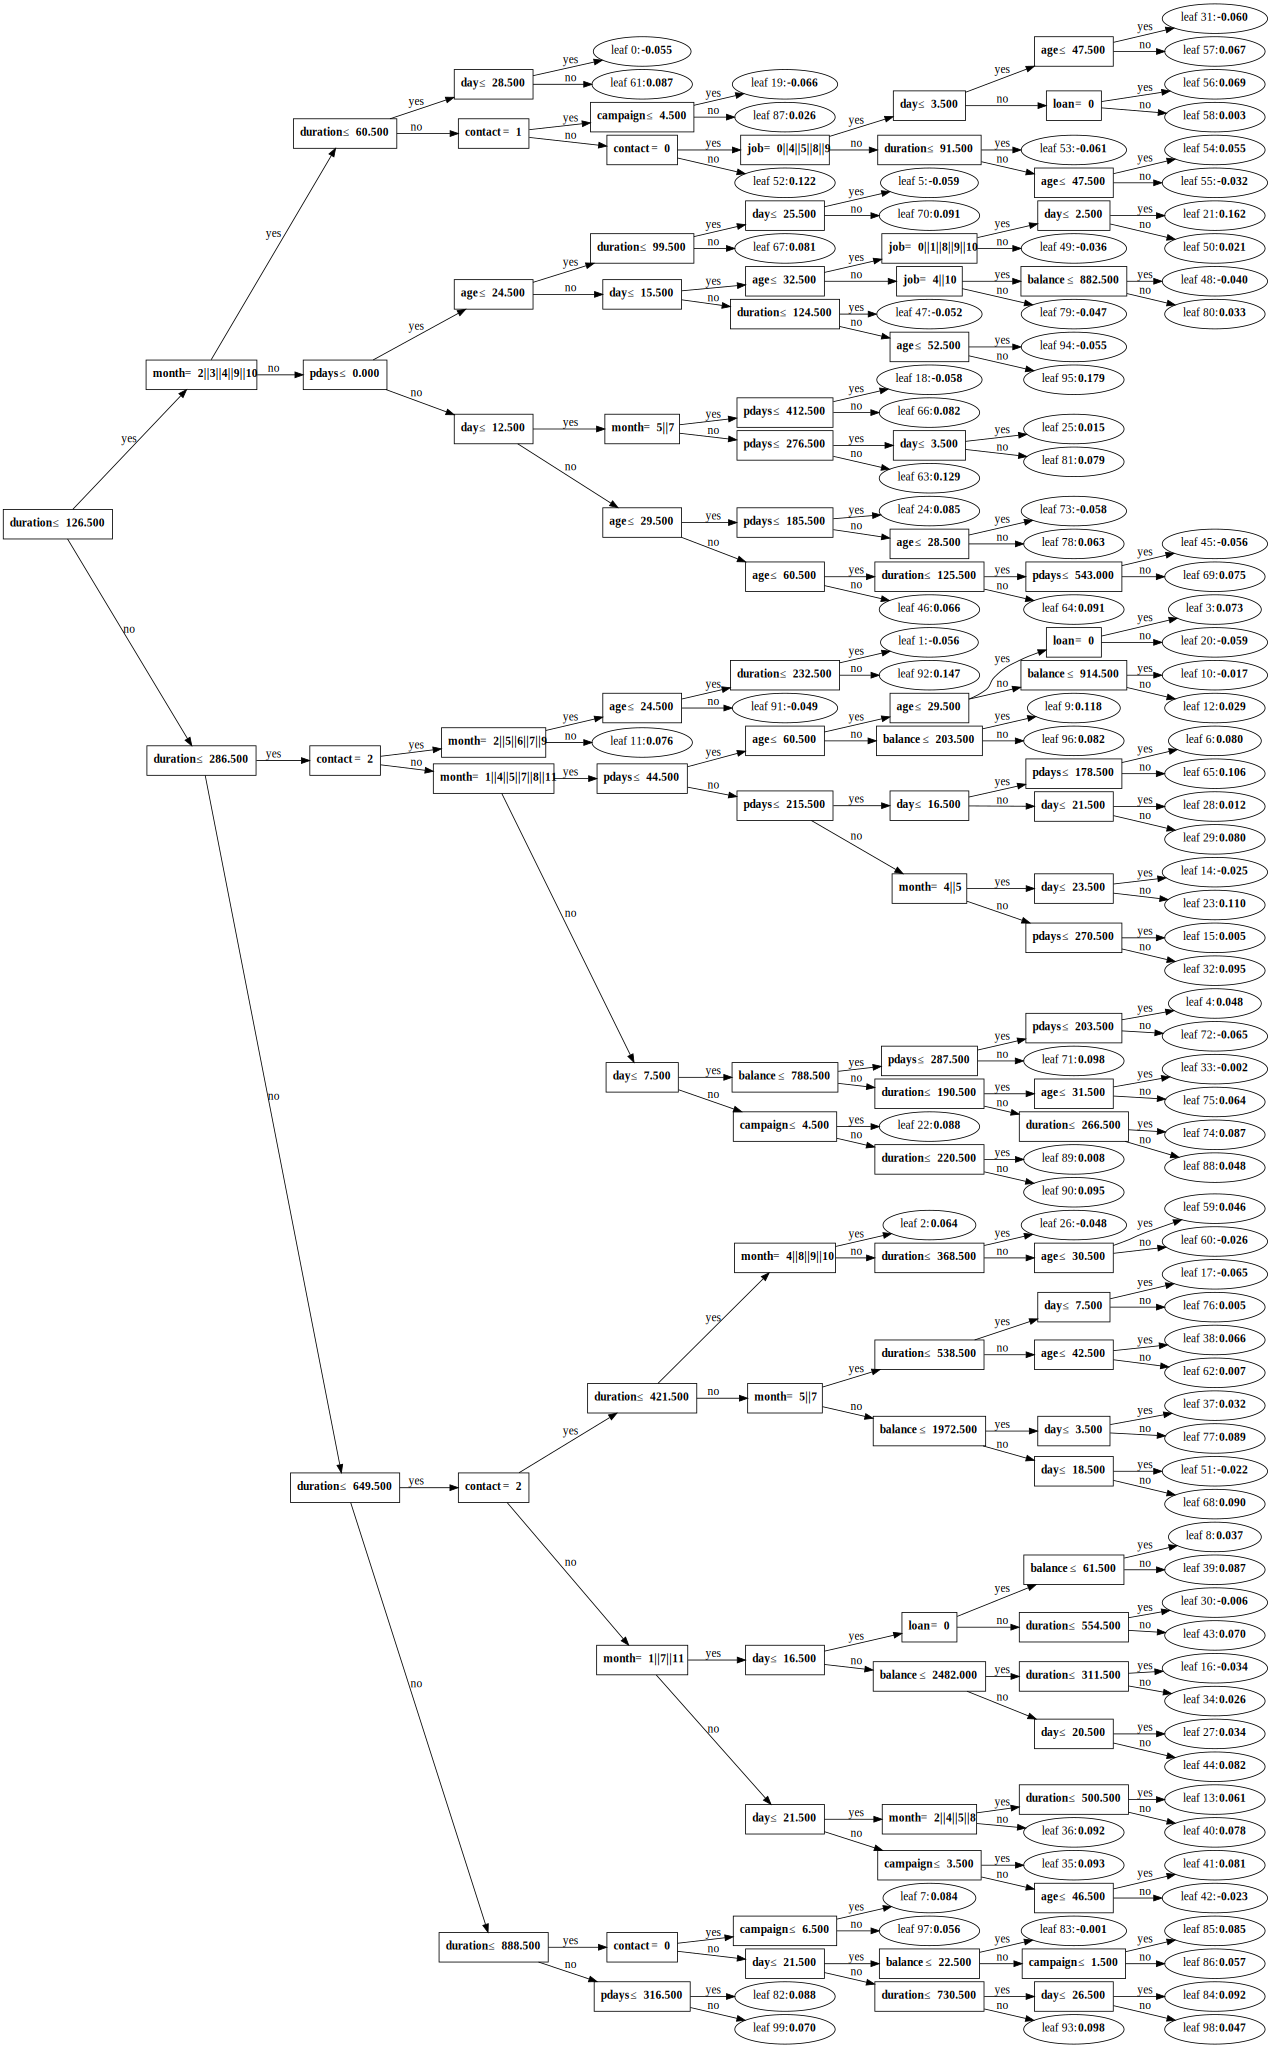

In [72]:
#create tree using graphviz
lgb.create_tree_digraph(lightgbm, tree_index=12)

In [73]:
#roc_curve
fpr, tpr, thresholds = roc_curve(y_t, lgb_predicted_prob[:, 1] )

#Try to find the best threshold, use G-mean and Youden index, both return 0.3535
# G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Best threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

#Youden index
youdenJ = tpr - fpr

# Best threshold
index = np.argmax(youdenJ)
thresholdOpt = round(thresholds[index], ndigits = 4)
youdenJOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt, youdenJOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

#remarks 
#when threshold = 0.3535, recall = 0.91 mcc = 0.56, f1 = 0.58, precision = 0.43
#when threshold = 0.5, recall = 0.86 mcc = 0.59, f1 = 0.63, precision = 0.49

Best Threshold: 0.3535 with G-Mean: 0.8743
FPR: 0.1593, TPR: 0.9093
Best Threshold: 0.3535 with Youden J statistic: 0.8743
FPR: 0.1593, TPR: 0.9093


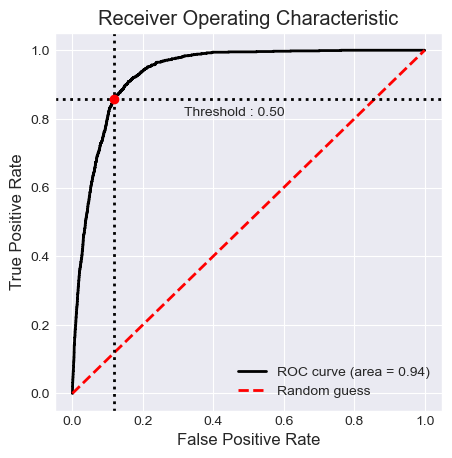

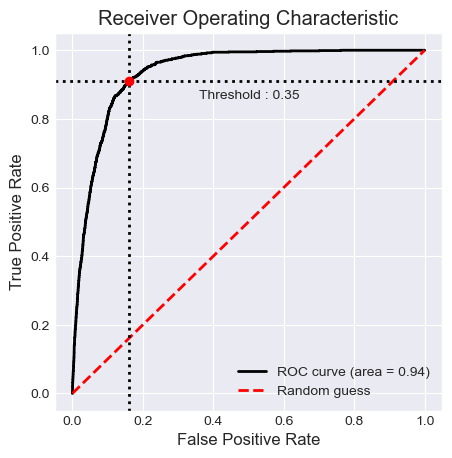

In [74]:
#plot roc curve
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
# threshold = 0.5 (default)
bc = BinaryClassification(y_t, lgb_predicted_prob[:, 1],labels = ["0","1"])
plt.figure(figsize=(5,5),dpi = 100)
bc.plot_roc_curve()
plt.show()
# threshold = 0.3535
bc = BinaryClassification(y_t, lgb_predicted_prob[:, 1],labels = ["0","1"],threshold = 0.3535)
plt.figure(figsize=(5,5),dpi = 100)
bc.plot_roc_curve()
plt.show()

### Feature Construction Result Based on LightGBM

In [ ]:
for i in ['y','loan','housing','default']:
    bankf[i] = bankf[i].map({'yes':1,'no':0})

y = bankf['y'].values
X = bankf.drop(columns = ['y'])
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X, y
                                                    , test_size=0.2
                                                    , random_state=2021
                                                    , stratify=y)
# check whether stratified
print(np.unique(y_train_f, return_counts=True),"\n",np.unique(y_test_f, return_counts=True))

(array([0, 1], dtype=int64), array([31937,  4231], dtype=int64)) 
 (array([0, 1], dtype=int64), array([7985, 1058], dtype=int64))


Correlation Matrix 



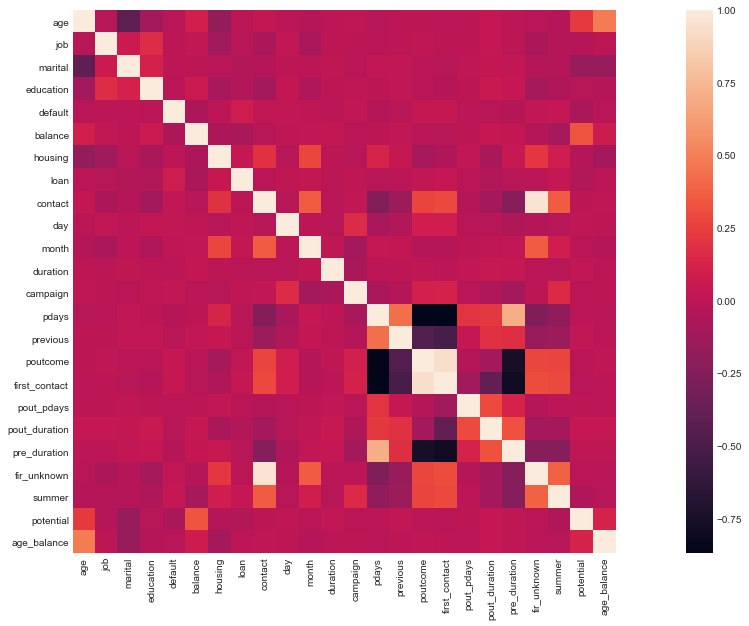

In [ ]:
from sklearn import preprocessing #for label encode

X_train, X_test, y_train, y_test = X_train_f, X_test_f, y_train_f, y_test_f

XC = pd.concat([X_train,X_test])
#XC.drop(columns = ['age','duration'],inplace=True)

lab = preprocessing.LabelEncoder()

for i in bank_strf: #+ ['duration_bins','age_bins']
    XC[i] = lab.fit_transform(XC[i].astype(str))

#trainset: X,y
X = XC[0:len(X_train)]
y = pd.Series(y_train)
X = X.reset_index(drop = True)
#testset: x_T,y_T
x_T = XC[len(X_train): ]
y_T = pd.Series(y_test)
x_T = x_T.reset_index(drop = True)

#Heat map
print("Correlation Matrix","\n")    
correlation=X.corr(method="pearson")
plt.figure(figsize=(25,10))
sns.heatmap(correlation,vmax=1,square=True,annot=False)
plt.show()

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


<Figure size 864x432 with 0 Axes>

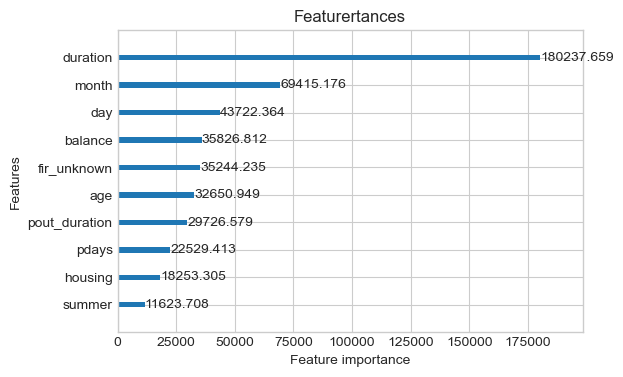

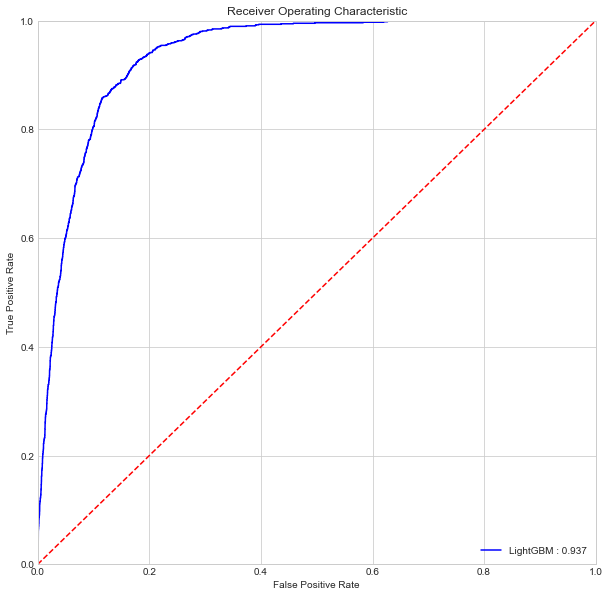

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      7985
           1       0.49      0.86      0.63      1058

    accuracy                           0.88      9043
   macro avg       0.74      0.87      0.78      9043
weighted avg       0.92      0.88      0.89      9043



Model  Recall_score  Precision  f1_score  Area_under_curve  \
0  LightGBM         0.860      0.492     0.626             0.937   

   Kappa_metric   MCC  
0         0.560 0.592

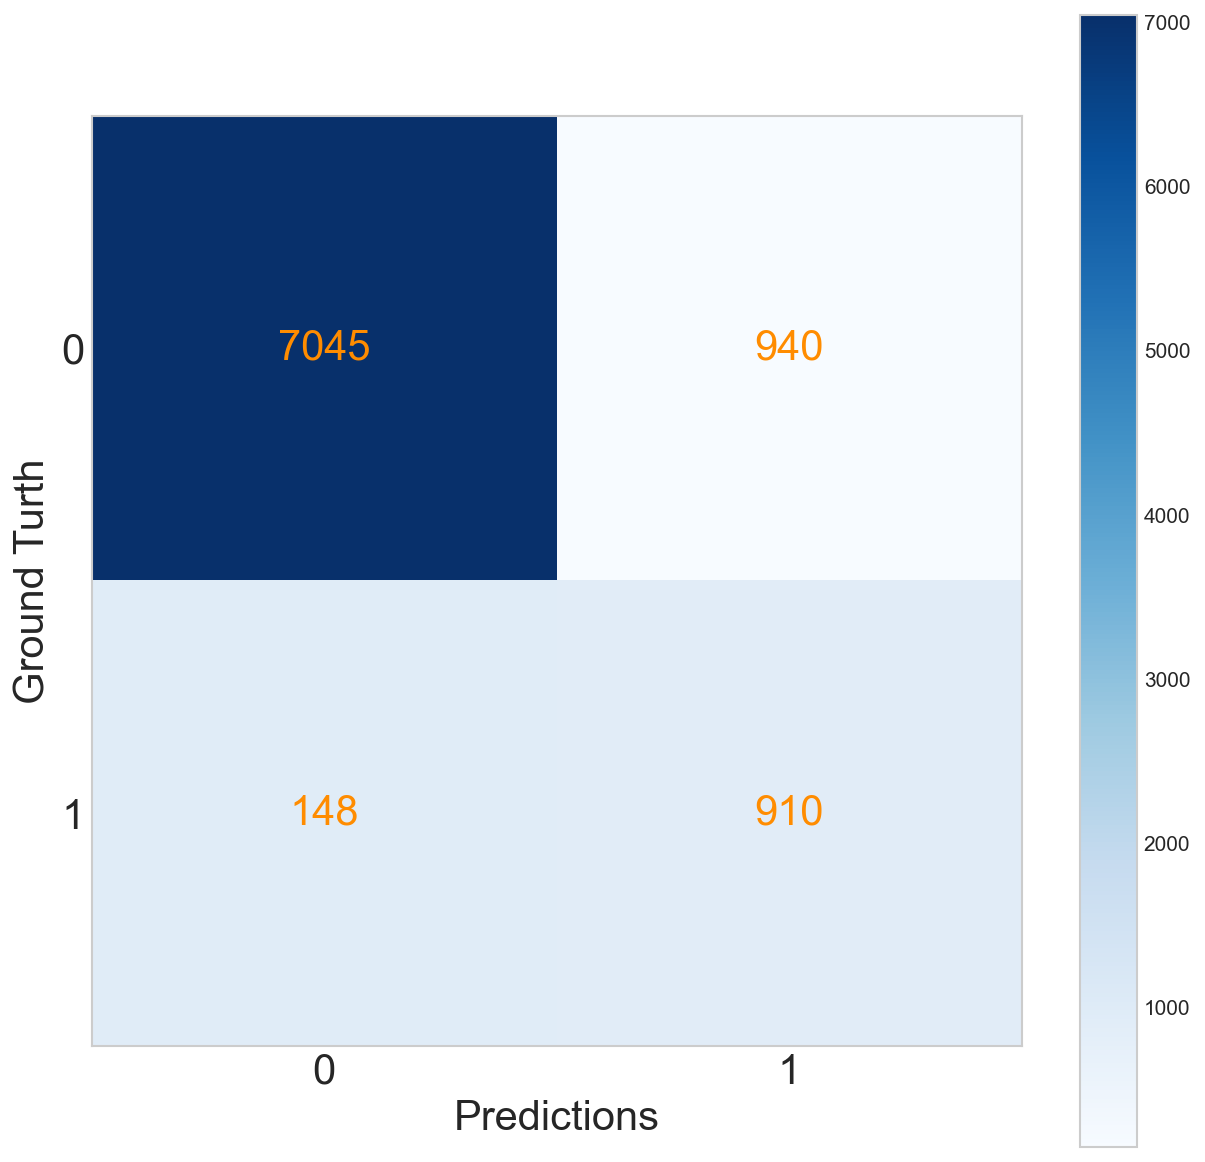

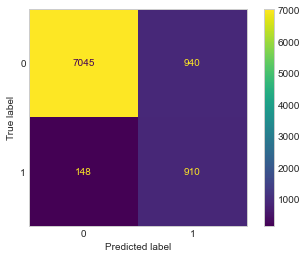

In [ ]:
#Predict
params_best = {
    'task': 'train',
    'boosting_type': 'gbdt',  
    'objective': 'binary',  
    'metric': 'mcc',
    'learning_rate': 0.05,
    'num_leaves': 100,  
    'max_depth':8,  
    'feature_fraction': 0.9,  # prevent from overfitting
    'bagging_freq':2,  # prevent from overfitting
    'bagging_fraction': 0.8,  # prevent from overfitting
    'min_child_samples': 20,  # prevent from overfitting
    'min_child_weight':0.001,
    #'reg_alpha' : 0.001,
    #'reg_lambda': 6,
    'nthread': -1, #use all
    'header': True,
    'is_unbalance': True,
    'verbose': -1,
    'num_iterations' : 200, 
    'random_state': 2
}


model_f = lgb.LGBMClassifier(**params_best)
#train on train set
model_f.fit(X, y,categorical_feature = [i for i in bank_strf])

#predict
# lgb_predicted = model.predict(X_t)
lgb_predicted_prob = model_f.predict_proba(x_T)   


#feature importance
plt.figure(figsize=(12,6))
lgb.plot_importance(model_f, max_num_features=10,importance_type='gain',dpi = 100)
plt.title("Featurertances")
plt.show()

# print(pd.DataFrame([[lgb_f1[0],lgb_recall[0],lgb_precision[0],lgb_mcc[0],lgb_auc[0]]],row,col)) 

fpr_lightgbm, tpr_lightgbm, auc_lightgbm = compute_and_plot_roc_curve(model_f,x_T,y_T,"LightGBM")

threshold = 0.5
# threshold = 0.3535
model_lightgbm = model_report(model_f,x_T, y_T,"LightGBM",customerized_threshold=True,threshold=threshold)
model_lightgbm

## Classifier including inner balancing samplers

### BalancedBaggingClassifier

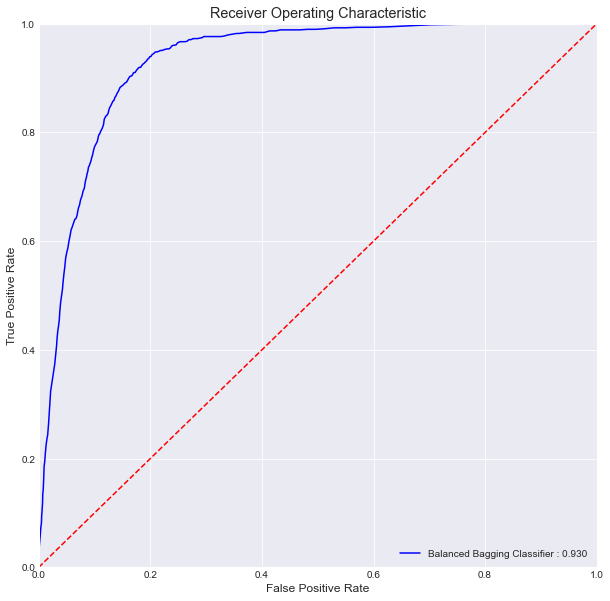

              precision    recall  f1-score   support

           0       0.98      0.88      0.92      7985
           1       0.48      0.83      0.61      1058

    accuracy                           0.87      9043
   macro avg       0.73      0.85      0.77      9043
weighted avg       0.92      0.87      0.89      9043



Model  Recall_score  Precision  f1_score  \
0  Balanced Bagging Classifier         0.830      0.478     0.606   

   Area_under_curve  Kappa_metric   MCC  
0             0.930         0.538 0.567

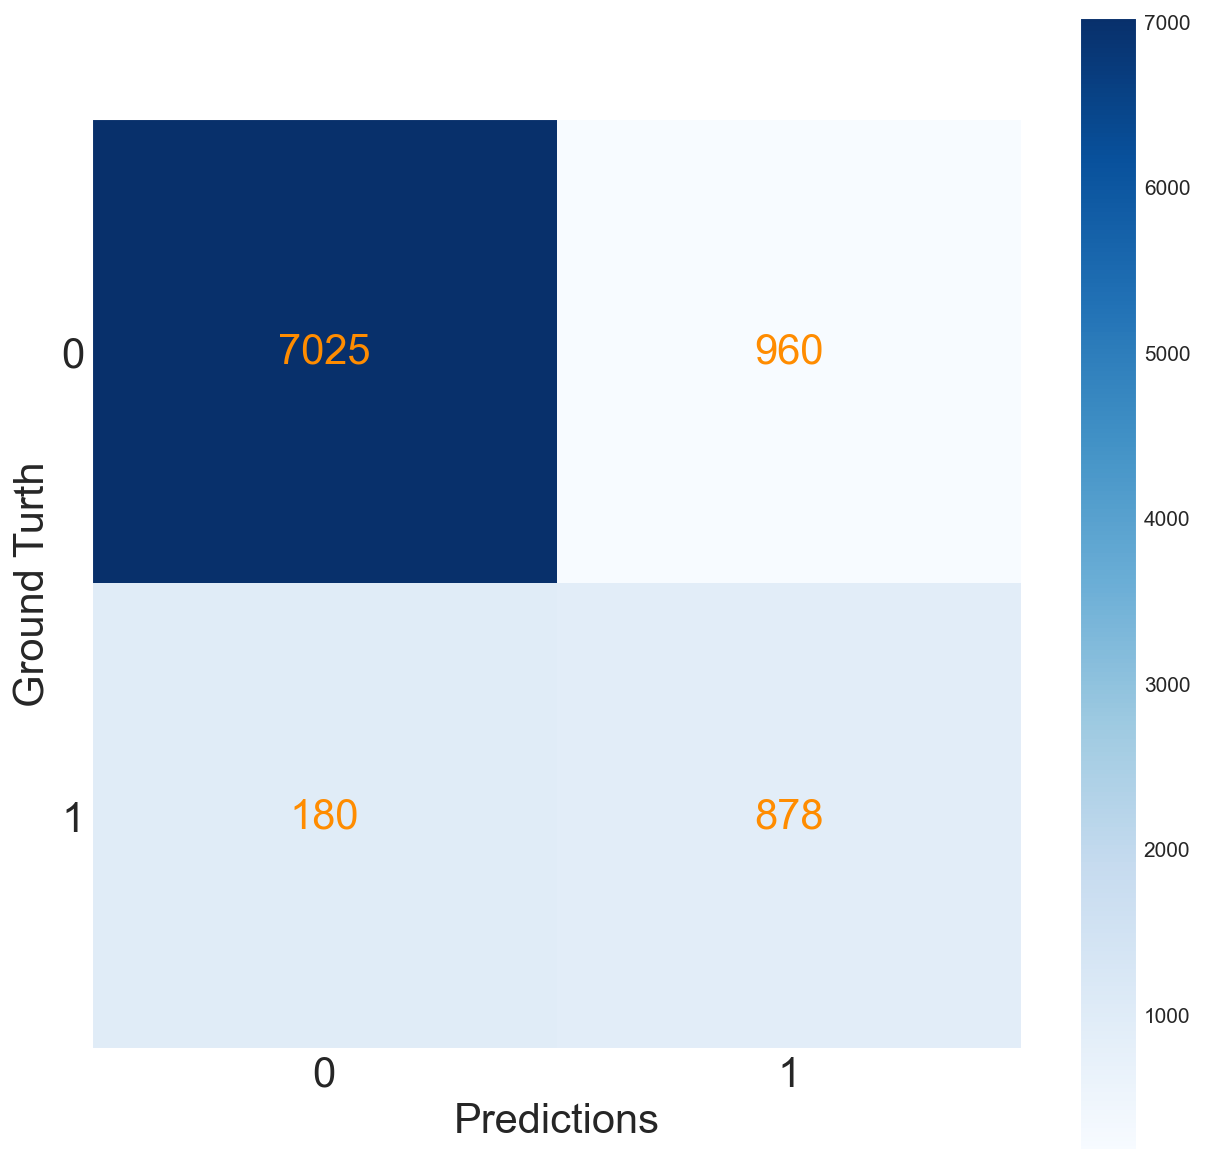

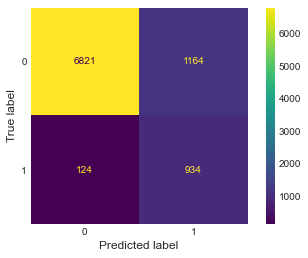

In [75]:
n_estimators=200  
replacement=True
func= 'SMOTE'

bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier()
                                            ,n_estimators=n_estimators
                                            ,replacement=replacement
                                            ,random_state=2021)



# # feature selection: remove features with low variance
# sel = VarianceThreshold(threshold=0.01)
# sel_var=sel.fit_transform(X)
# X_TR = X_train_o[X_train_o.columns[sel.get_support(indices=True)]]
# X_T = X_test_o[X_TR.columns]
    
# # feature selection: remove one of the highly correlated features
# correlation_train = X_TR.corr(method="pearson")
# columns = np.full((correlation_train.shape[0],), True, dtype=bool)
# for i in range(correlation_train.shape[0]):
#     for j in range(i+1, correlation_train.shape[0]):
#         if abs(correlation_train.iloc[i,j]) >= 0.8:
#             if columns[j]:
#                 columns[j] = False

# selected_columns = X_TR.columns[columns]
# X_TRF = X_TR[selected_columns]
# X_TF = X_T[selected_columns]

# X_tr,  y_tr = re_sample(X_TRF, y_train, func = 'ClusterCentroids')
X_tr,  y_tr = X_train_o, y_train_o
X_t,  y_t = X_test_o, y_test_o

#train on train set
bbc.fit(X_tr, y_tr)

# #predict
# predicted = knn.predict(X_t)
# predict_prob = knn.predict_proba(X_t)



fpr_bbc, tpr_bbc, auc_bbc = compute_and_plot_roc_curve(bbc,X_t, y_t,"Balanced Bagging Classifier")


threshold = 0.57
model_bbc = model_report(bbc,X_t, y_t,"Balanced Bagging Classifier",
                                                      customerized_threshold=True,
                                                       threshold=threshold)
model_bbc

### Balanced RandomForest

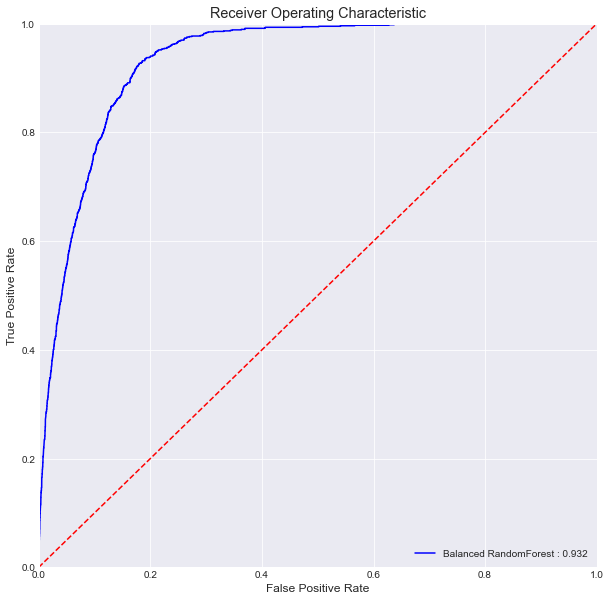

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      7985
           1       0.41      0.92      0.57      1058

    accuracy                           0.84      9043
   macro avg       0.70      0.87      0.73      9043
weighted avg       0.92      0.84      0.86      9043



Model  Recall_score  Precision  f1_score  Area_under_curve  \
0  Balanced RandomForest         0.920      0.410     0.567             0.932   

   Kappa_metric   MCC  
0         0.484 0.544

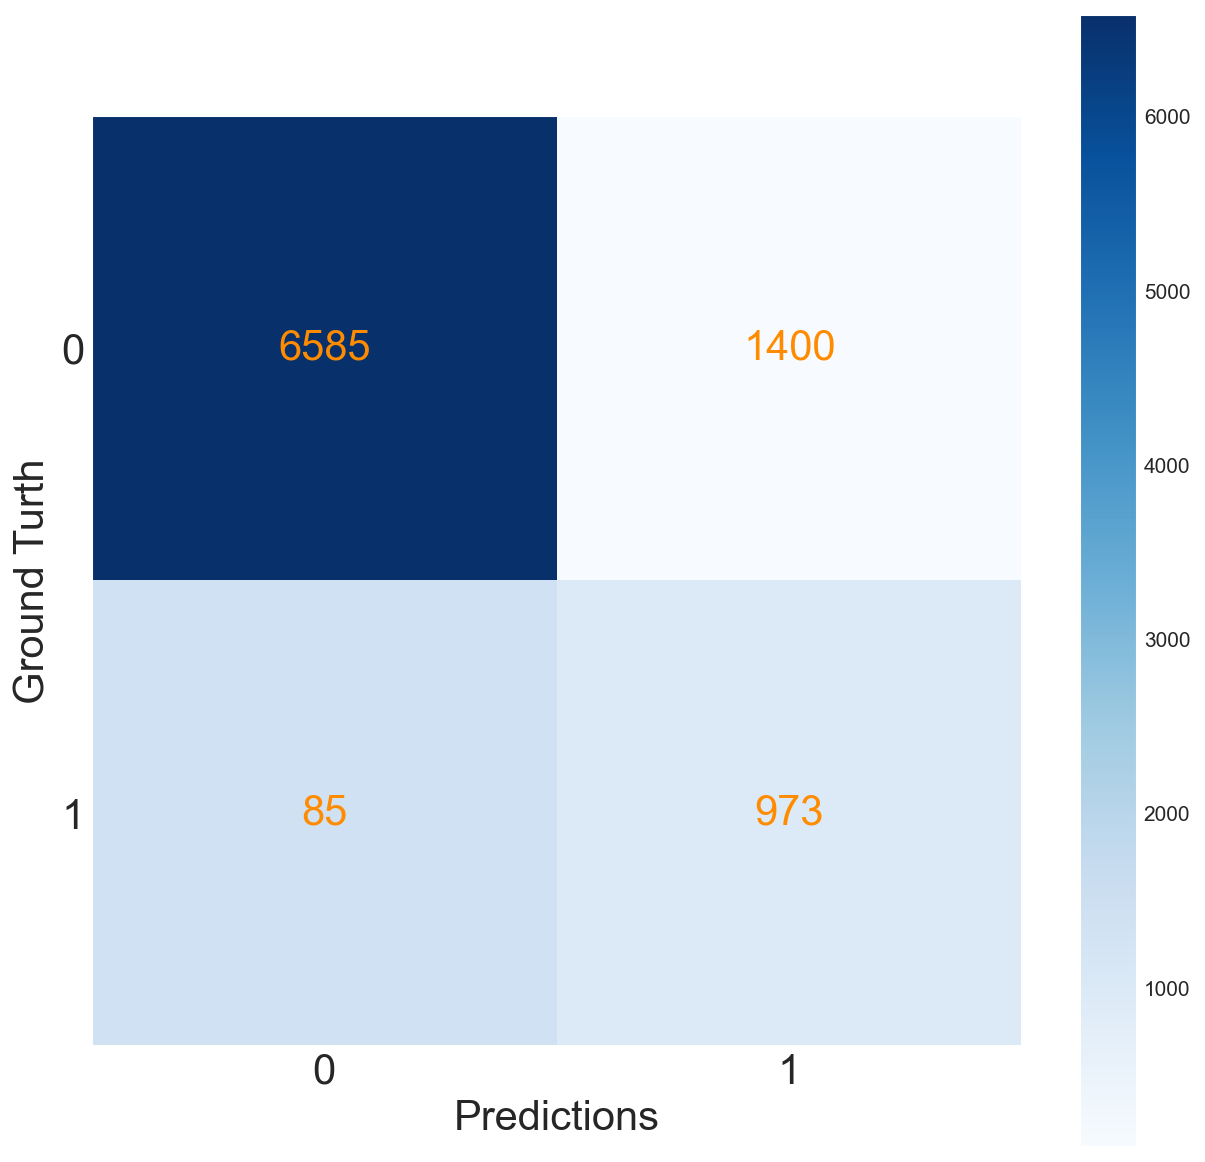

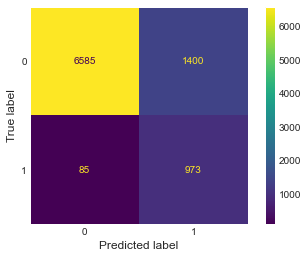

In [76]:
n_estimators=200
max_depth=20
class_weight= 'balanced_subsample'
# class_weight= None

brf = BalancedRandomForestClassifier(n_estimators=n_estimators
                                    ,class_weight=class_weight
                                    ,max_depth=max_depth
                                    ,random_state=2021)

# resample
# X_train_re, y_train_re = re_sample(X_train_o, y_train_o, func=func)



# X_tr,  y_tr = re_sample(X_TRF, y_train, func = 'ClusterCentroids')
X_tr,  y_tr = X_train_o, y_train_o
X_t,  y_t = X_test_o, y_test_o

#train on train set
brf.fit(X_tr, y_tr)

# #predict
# predicted = knn.predict(X_t)
# predict_prob = knn.predict_proba(X_t)

fpr_brf, tpr_brf, auc_brf = compute_and_plot_roc_curve(brf,X_t, y_t,"Balanced RandomForest")

model_brf = model_report(brf,X_t, y_t,"Balanced RandomForest")
model_brf

### Easy Ensemble

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


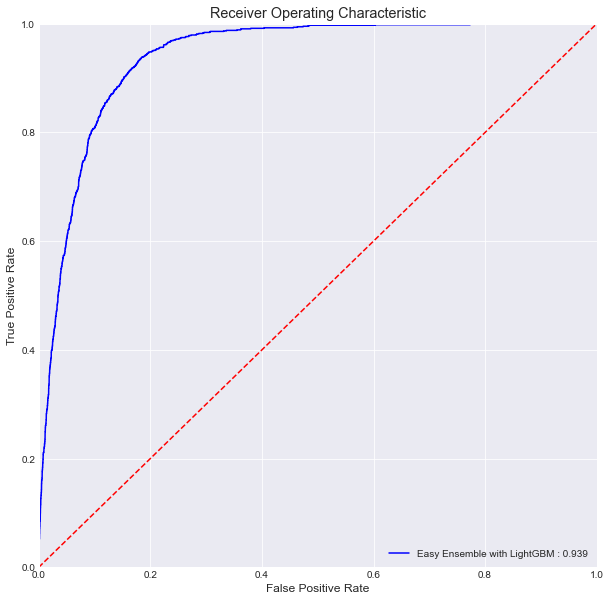

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7985
           1       0.54      0.79      0.64      1058

    accuracy                           0.90      9043
   macro avg       0.75      0.85      0.79      9043
weighted avg       0.92      0.90      0.90      9043



Model  Recall_score  Precision  f1_score  \
0  Easy Ensemble with LightGBM         0.790      0.535     0.638   

   Area_under_curve  Kappa_metric   MCC  
0             0.939         0.580 0.595

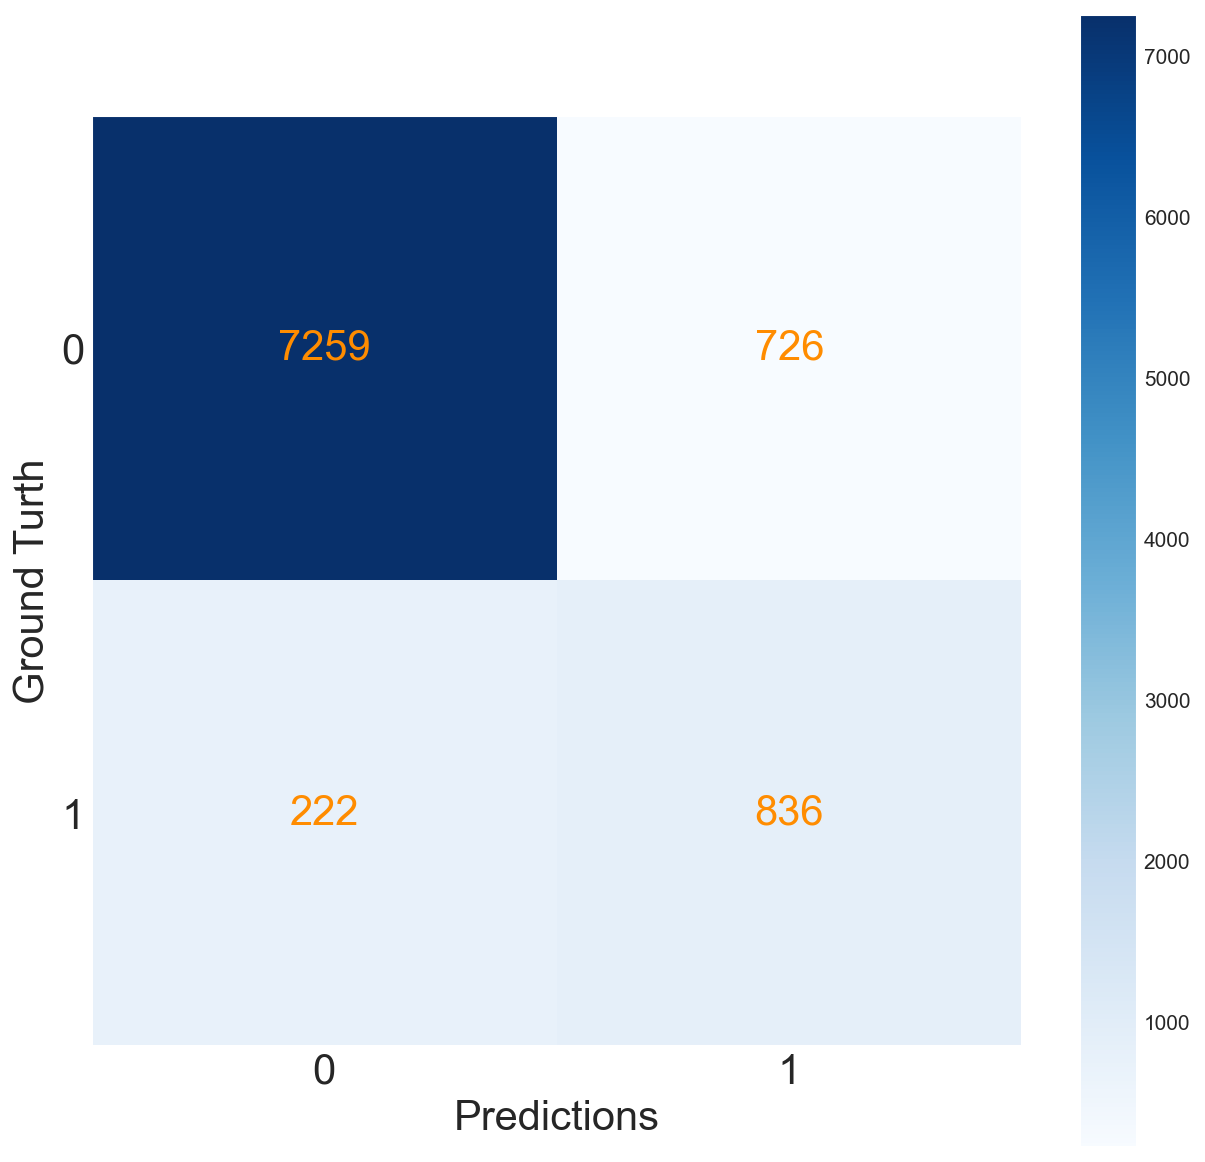

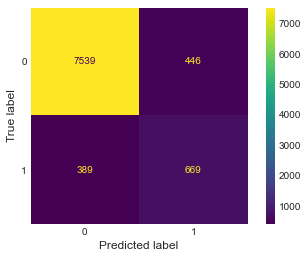

In [78]:
from imblearn.ensemble import EasyEnsembleClassifier


# # feature selection: remove features with low variance
# sel = VarianceThreshold(threshold=0.01)
# sel_var=sel.fit_transform(X_train)
# X_TR = X_train[X_train.columns[sel.get_support(indices=True)]]
# X_T = X_test[X_TR.columns]
    
# # feature selection: remove one of the highly correlated features
# correlation_train = X_TR.corr(method="pearson")
# columns = np.full((correlation_train.shape[0],), True, dtype=bool)
# for i in range(correlation_train.shape[0]):
#     for j in range(i+1, correlation_train.shape[0]):
#         if abs(correlation_train.iloc[i,j]) >= 0.8:
#             if columns[j]:
#                 columns[j] = False
# selected_columns = X_TR.columns[columns]
# X_TRF = X_TR[selected_columns]
# X_TF = X_T[selected_columns]



# X_tr,  y_tr = X_TRF, y_train
# X_t,  y_t = X_TF, y_test


X_tr,  y_tr = X_train, y_train
X_t,  y_t = X_test, y_test


n_estimators= 20
params_best = {
    'task': 'train',
    'boosting_type': 'gbdt',  
    'objective': 'binary',  
    'metric': 'mcc',
    'learning_rate': 0.1,
    'num_leaves': 100,  
    'max_depth':8,  
    'feature_fraction': 0.9,  # prevent from overfitting
#     'bagging_freq':2,  # prevent from overfitting
#     'bagging_fraction': 0.8,  # prevent from overfitting
#     'min_child_samples': 30,  # prevent from overfitting
    #'reg_alpha' : 0.001,
    #'reg_lambda': 6,
    'n_jobs': -1, #use all
    'header': True,
#     'is_unbalance': True,
    'verbose': -1,
    'num_iterations' : 200, 
    'random_state': 2021
}

base_estimator =  lgb.LGBMClassifier(**params_best)

eec_lightgbm = EasyEnsembleClassifier(n_estimators=n_estimators,
                             base_estimator=base_estimator,
                             sampling_strategy = 0.2 ,
                             random_state=2021)

model = eec_lightgbm.fit(X_tr, y_tr)

# y_pred = model.predict(X_t)
# val_pred_proba = model.predict_proba(X_val_scaled)
fpr_eec_lightgbm, tpr_eec_lightgbm, auc_eec_lightgbm = compute_and_plot_roc_curve(eec_lightgbm,X_t, y_t,"Easy Ensemble with LightGBM")


threshold = 0.330
model_eec_lightgbm = model_report(eec_lightgbm,X_t, y_t,"Easy Ensemble with LightGBM",customerized_threshold=True,threshold=threshold)
model_eec_lightgbm

threshold:0.100 --->MCC:0.539
threshold:0.110 --->MCC:0.546
threshold:0.120 --->MCC:0.549
threshold:0.130 --->MCC:0.554
threshold:0.140 --->MCC:0.558
threshold:0.150 --->MCC:0.562
threshold:0.160 --->MCC:0.565
threshold:0.170 --->MCC:0.565
threshold:0.180 --->MCC:0.570
threshold:0.190 --->MCC:0.573
threshold:0.200 --->MCC:0.576
threshold:0.210 --->MCC:0.580
threshold:0.220 --->MCC:0.581
threshold:0.230 --->MCC:0.585
threshold:0.240 --->MCC:0.586
threshold:0.250 --->MCC:0.589
threshold:0.260 --->MCC:0.586
threshold:0.270 --->MCC:0.589
threshold:0.280 --->MCC:0.588
threshold:0.290 --->MCC:0.589
threshold:0.300 --->MCC:0.591
threshold:0.310 --->MCC:0.594
threshold:0.320 --->MCC:0.595
threshold:0.330 --->MCC:0.595
threshold:0.340 --->MCC:0.593
threshold:0.350 --->MCC:0.590
threshold:0.360 --->MCC:0.584
threshold:0.370 --->MCC:0.585
threshold:0.380 --->MCC:0.588
threshold:0.390 --->MCC:0.586
threshold:0.400 --->MCC:0.583
threshold:0.410 --->MCC:0.583
threshold:0.420 --->MCC:0.575
threshold:

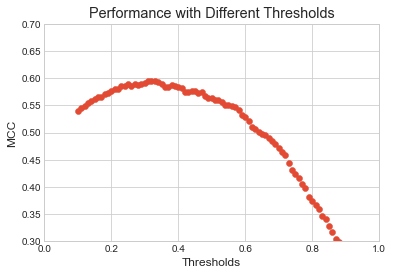

0.3199999999999999

In [112]:
X_tr,  y_tr = X_train, y_train
X_t,  y_t = X_test, y_test
find_best_threshold(0.1, 0.9, eec_lightgbm,X_t, y_t)

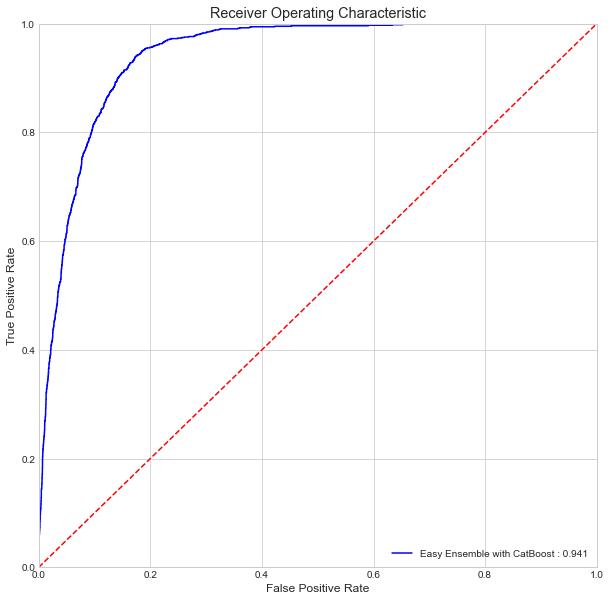

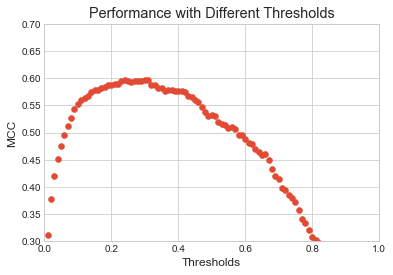

threshold:0.3
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      7985
           1       0.56      0.76      0.64      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.84      0.79      9043
weighted avg       0.92      0.90      0.91      9043



Model  Recall_score  Precision  f1_score  \
0  Easy Ensemble with CatBoost         0.761      0.557     0.643   

   Area_under_curve  Kappa_metric   MCC  
0             0.941         0.588 0.597

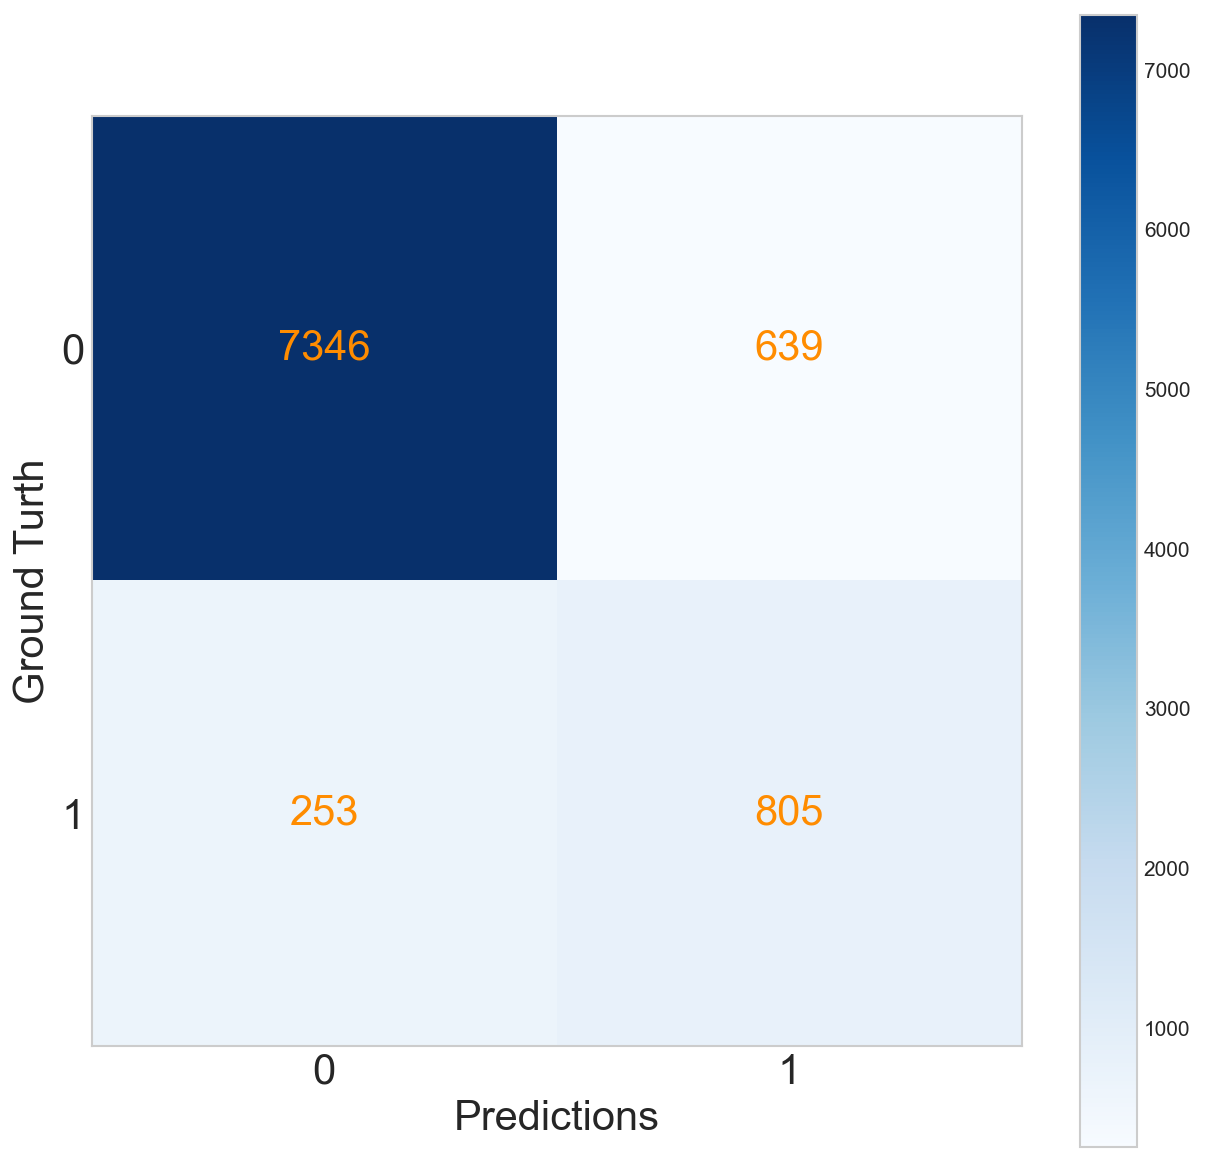

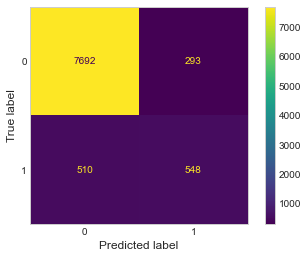

In [80]:
X_tr,  y_tr = X_train, y_train
X_t,  y_t = X_test, y_test


n_estimators= 20

base_estimator = CatBoostClassifier(
                         iterations=200, 
#                          depth=5,
#                          cat_features=categorical_features_indices,
#                          learning_rate=0.5, 
                         loss_function='Logloss',
                         logging_level='Silent')

eec_catboost = EasyEnsembleClassifier(n_estimators=n_estimators,
                             base_estimator=base_estimator,
                             sampling_strategy = 0.14,
                             random_state=2021)

model = eec_catboost.fit(X_tr, y_tr)

# y_pred = model.predict(X_t)
# val_pred_proba = model.predict_proba(X_val_scaled)
fpr_eec_catboost, tpr_eec_catboost, auc_eec_catboost = compute_and_plot_roc_curve(eec_catboost,X_t, y_t,"Easy Ensemble with CatBoost")

threshold = find_best_threshold(0, 1, eec_catboost,X_t, y_t)

print(f'threshold:{threshold}')

model_eec_catboost = model_report(eec_catboost,X_t, y_t,"Easy Ensemble with CatBoost",customerized_threshold=True,threshold=threshold)
model_eec_catboost

In [81]:
#1    0.66 0.586
#0.9  0.7  0.587
#0.8  0.62 0.589
#0.7  0.61 0.592
#0.6  0.58 0.594
#0.5  0.53 0.593
#0.4  0.49 0.591
#0.3  0.47 0.595
#0.2  0.34 0.597
#0.15 0.28 0.602 

In [82]:
# threshold = 0.220
# model_eec_lightgbm = model_report(eec,X_t, y_t,"Easy Ensemble with LightGBM",customerized_threshold=True,threshold=threshold)
# model_eec_lightgbm



#sampling_strategy = 0.9  threshold:0.750 --->MCC:0.585
#sampling_strategy = 0.8  threshold:0.700 --->MCC:0.588
#sampling_strategy = 0.7  threshold:0.640 --->MCC:0.586
#sampling_strategy = 0.6  threshold:0.600 --->MCC:0.591
#sampling_strategy = 0.5  threshold:0.570 --->MCC:0.591
#sampling_strategy = 0.4  threshold:0.460 --->MCC:0.593
#sampling_strategy = 0.3  threshold:0.430 --->MCC:0.591
#sampling_strategy = 0.2  threshold:0.330 --->MCC:0.595
#sampling_strategy = 0.15 threshold:0.220 --->MCC:0.594



#threshold = 0.72 ,n_estimators= 100 ,'num_iterations' : 200, 0.587
#threshold = 0.69 sampling_strategy = 0.9 0.583
#threshold = 0.65 sampling_strategy = 0.8  0.588
#threshold = 0.67 sampling_strategy = 0.7  0.585
#threshold = 0.60 sampling_strategy = 0.6  0.591
#threshold = 0.57 sampling_strategy = 0.5  0.591
#threshold = 0.46 sampling_strategy = 0.4  0.593
#threshold = 0.46 sampling_strategy = 0.3  0.593

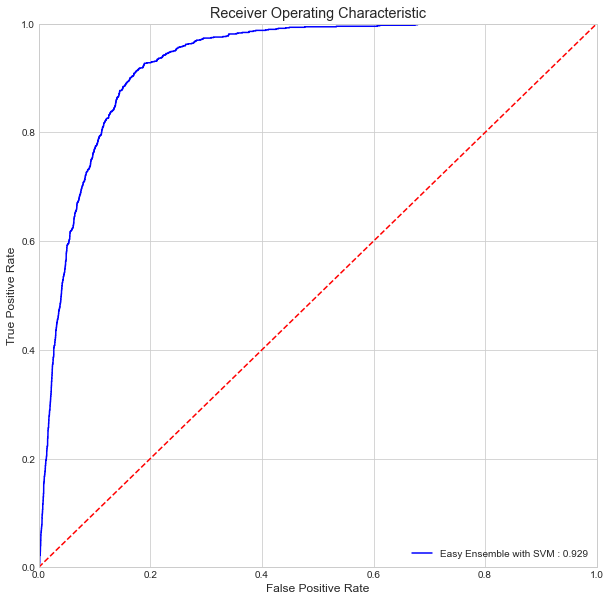

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7985
           1       0.44      0.88      0.58      1058

    accuracy                           0.85      9043
   macro avg       0.71      0.87      0.75      9043
weighted avg       0.92      0.85      0.87      9043



Model  Recall_score  Precision  f1_score  \
0  Easy Ensemble with SVM         0.885      0.435     0.583   

   Area_under_curve  Kappa_metric   MCC  
0             0.929         0.506 0.553

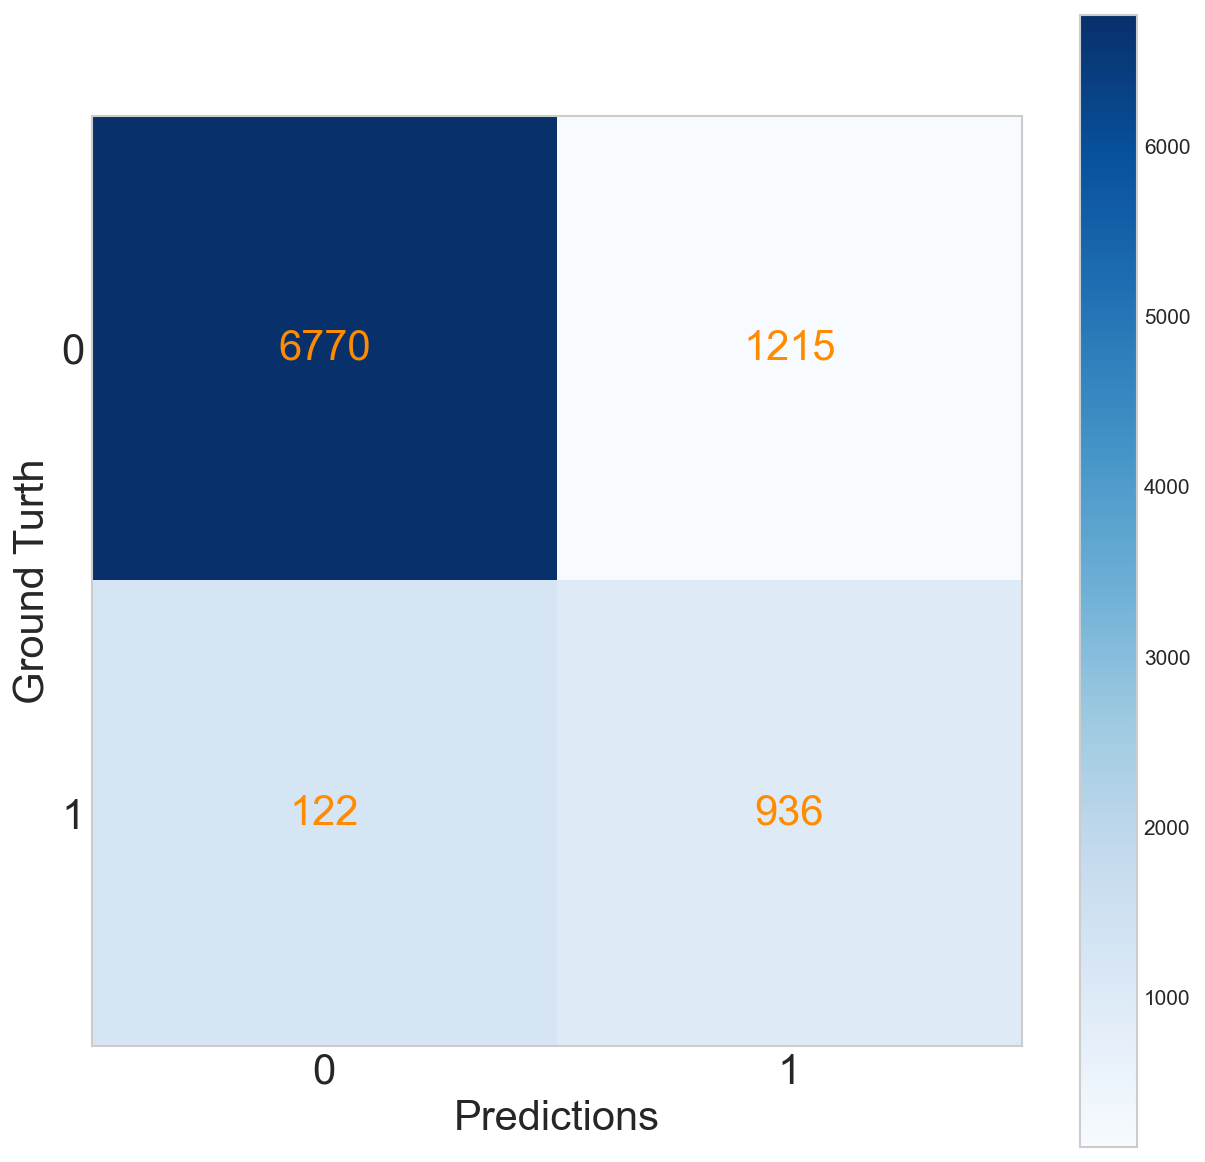

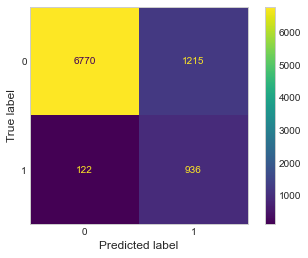

In [83]:
from imblearn.ensemble import EasyEnsembleClassifier


start = time.time()

scaler = MinMaxScaler()
train_X_scaled = scaler.fit_transform(X_train_o)
test_X_scaled = scaler.transform(X_test_o)

X_tr,  y_tr = train_X_scaled, y_train_o
X_t,  y_t = test_X_scaled, y_test_o

n_estimators= 20

base_estimator = SVC(C=1000,gamma=0.01,kernel='rbf',probability=True)

eec = EasyEnsembleClassifier(n_estimators=n_estimators,base_estimator=base_estimator,random_state=2021)

model = eec.fit(X_tr, y_tr)

# y_pred = model.predict(X_t)
# val_pred_proba = model.predict_proba(X_val_scaled)

fpr_eec_svm, tpr_eec_svm, auc_eec_svm = compute_and_plot_roc_curve(eec,X_t, y_t,"Easy Ensemble with SVM")

model_eec_svm = model_report(eec,X_t, y_t,"Easy Ensemble with SVM")
model_eec_svm

## voting machine

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

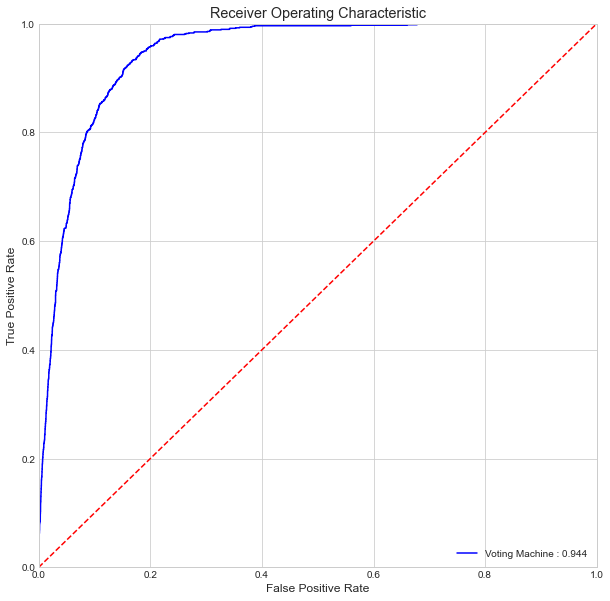

threshold:0.100 --->MCC:0.555
threshold:0.110 --->MCC:0.564
threshold:0.120 --->MCC:0.569
threshold:0.130 --->MCC:0.571
threshold:0.140 --->MCC:0.577
threshold:0.150 --->MCC:0.578
threshold:0.160 --->MCC:0.581
threshold:0.170 --->MCC:0.587
threshold:0.180 --->MCC:0.590
threshold:0.190 --->MCC:0.595
threshold:0.200 --->MCC:0.598
threshold:0.210 --->MCC:0.599
threshold:0.220 --->MCC:0.599
threshold:0.230 --->MCC:0.600
threshold:0.240 --->MCC:0.601
threshold:0.250 --->MCC:0.603
threshold:0.260 --->MCC:0.610
threshold:0.270 --->MCC:0.611
threshold:0.280 --->MCC:0.611
threshold:0.290 --->MCC:0.609
threshold:0.300 --->MCC:0.607
threshold:0.310 --->MCC:0.605
threshold:0.320 --->MCC:0.603
threshold:0.330 --->MCC:0.606
threshold:0.340 --->MCC:0.600
threshold:0.350 --->MCC:0.599
threshold:0.360 --->MCC:0.598
threshold:0.370 --->MCC:0.597
threshold:0.380 --->MCC:0.595
threshold:0.390 --->MCC:0.586
threshold:0.400 --->MCC:0.582
threshold:0.410 --->MCC:0.580
threshold:0.420 --->MCC:0.579
threshold:

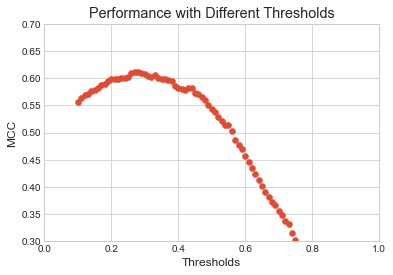

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      7985
           1       0.55      0.80      0.65      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.86      0.80      9043
weighted avg       0.92      0.90      0.91      9043



Model  Recall_score  Precision  f1_score  Area_under_curve  \
0  Voting Machine         0.796      0.554     0.653             0.944   

   Kappa_metric   MCC  
0         0.598 0.611

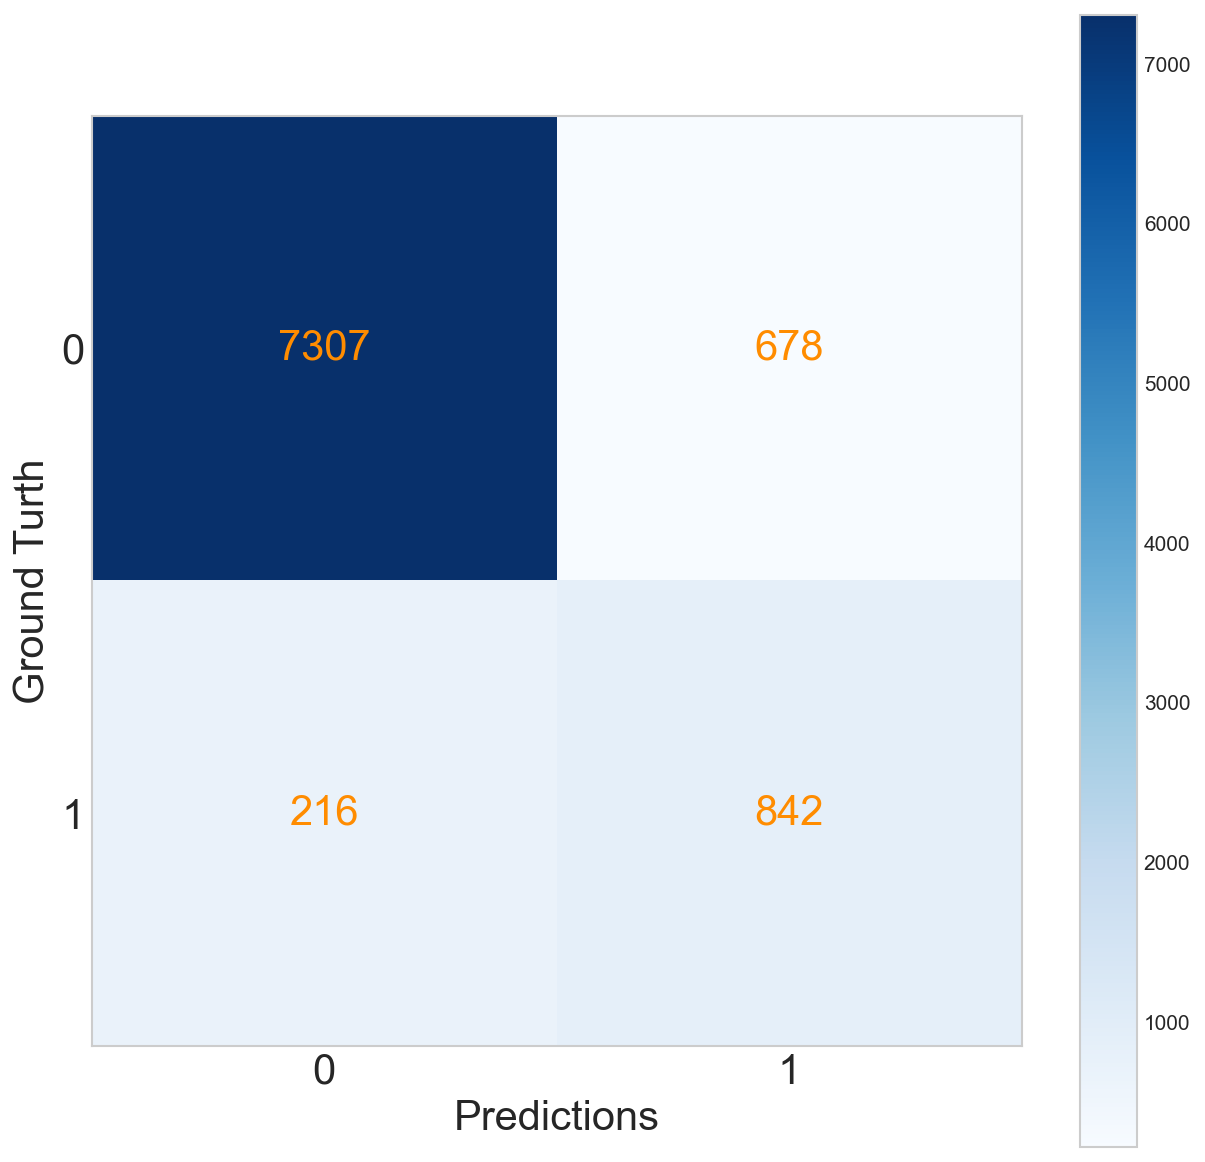

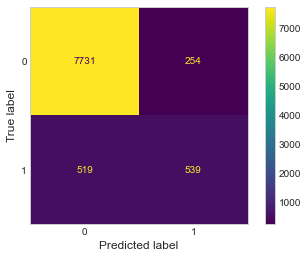

In [123]:
#'random_over_sample','SMOTE','ADASYN','BorderlineSMOTE','KMeansSMOTE', 'ClusterCentroids','random_under_sample'
mcc_scorer = make_scorer(matthews_corrcoef)
X_train_re, y_train_re = re_sample(X_train, y_train, func='random_over_sample')

X_tr,  y_tr = X_train_re, y_train_re
X_t,  y_t = X_test, y_test


bank_use = ['job',
             'marital',
             'education',
             'default',
             'housing',
             'loan',
             'contact',
             'month',
             'poutcome',
             'day'
           ]
categorical_features_indices = [i for i in bank_use if i in X_tr.columns.tolist()]

cat_ = CatBoostClassifier(
#                          iterations=100, 
#                          depth=5,
                         cat_features=categorical_features_indices,
#                          learning_rate=0.5, 
                         loss_function='Logloss',
                         logging_level='Silent')


cat_.fit(X_tr,  y_tr,
        plot=True, 
        eval_set=(X_t,  y_t))

# # threshold= 0.55
# # fpr_catboost, tpr_catboost, auc_catboost = compute_and_plot_roc_curve(cat, X_t, y_t,"CatBoost",
# #                                                                       customerized_threshold=True,threshold=threshold)

# fpr_catboost, tpr_catboost, auc_catboost = compute_and_plot_roc_curve(cat, X_t, y_t,"CatBoost")

# model_catboost = model_report(cat, X_t, y_t,"CatBoost")
# model_catboost
# # default + ros =0.574





voting = VotingClassifier(estimators=[
#                                      ("LightGBM", lightgbm), 
                                     ("LightGBM", lgb.LGBMClassifier()),
#                                      ("XgBOOST",xgboost),
#                                      ('KNN',knn),
#                                      ('SVM',svm),
#                                      ("Balanced Bagging Classifier",bbc),
#                                      ("Easy Ensemble with LightGBM", eec_lightgbm), 
                                     ("CatBoost",cat_)], voting='soft',n_jobs=-1)
voting.fit(X_train,y_train)


fpr_voting, tpr_voting, auc_voting = compute_and_plot_roc_curve(voting, X_t, y_t,"Voting Machine")

voting_machine = model_report(voting,X_t, y_t,"Voting Machine",customerized_threshold=True,
                              threshold=find_best_threshold(0.1, 0.9, voting, X_t, y_t))
voting_machine

threshold:0.100 --->MCC:0.551
threshold:0.110 --->MCC:0.556
threshold:0.120 --->MCC:0.561
threshold:0.130 --->MCC:0.567
threshold:0.140 --->MCC:0.574
threshold:0.150 --->MCC:0.576
threshold:0.160 --->MCC:0.580
threshold:0.170 --->MCC:0.584
threshold:0.180 --->MCC:0.590
threshold:0.190 --->MCC:0.594
threshold:0.200 --->MCC:0.597
threshold:0.210 --->MCC:0.595
threshold:0.220 --->MCC:0.597
threshold:0.230 --->MCC:0.600
threshold:0.240 --->MCC:0.601
threshold:0.250 --->MCC:0.599
threshold:0.260 --->MCC:0.601
threshold:0.270 --->MCC:0.600
threshold:0.280 --->MCC:0.603
threshold:0.290 --->MCC:0.602
threshold:0.300 --->MCC:0.601
threshold:0.310 --->MCC:0.603
threshold:0.320 --->MCC:0.600
threshold:0.330 --->MCC:0.597
threshold:0.340 --->MCC:0.591
threshold:0.350 --->MCC:0.592
threshold:0.360 --->MCC:0.592
threshold:0.370 --->MCC:0.593
threshold:0.380 --->MCC:0.591
threshold:0.390 --->MCC:0.592
threshold:0.400 --->MCC:0.588
threshold:0.410 --->MCC:0.586
threshold:0.420 --->MCC:0.587
threshold:

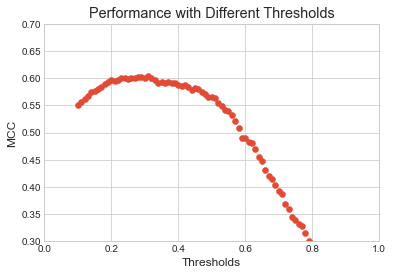

0.30999999999999994

In [115]:
find_best_threshold(0.1, 0.9, voting, X_t, y_t)

In [86]:
# #'random_over_sample','SMOTE','ADASYN','BorderlineSMOTE','KMeansSMOTE', 'ClusterCentroids','random_under_sample'
# mcc_scorer = make_scorer(matthews_corrcoef)
# X_train_re, y_train_re = re_sample(X_train, y_train, func='random_over_sample')

# X_tr,  y_tr = X_train_re, y_train_re
# X_t,  y_t = X_test, y_test


# bank_use = ['job',
#              'marital',
#              'education',
#              'default',
#              'housing',
#              'loan',
#              'contact',
#              'month',
#              'poutcome',
#              'day'
#            ]
# # categorical_features_indices = [i for i in bank_use if i in X_tr.columns.tolist()]

# cat = CatBoostClassifier(
# #                          iterations=100, 
# #                          depth=5,
# #                          cat_features=categorical_features_indices,
# #                          learning_rate=0.5, 
#                          loss_function='Logloss',
#                          logging_level='Silent')


# cat.fit(X_tr,  y_tr,
#         plot=True, 
#         eval_set=(X_t,  y_t))

# # # threshold= 0.55
# # # fpr_catboost, tpr_catboost, auc_catboost = compute_and_plot_roc_curve(cat, X_t, y_t,"CatBoost",
# # #                                                                       customerized_threshold=True,threshold=threshold)

# # fpr_catboost, tpr_catboost, auc_catboost = compute_and_plot_roc_curve(cat, X_t, y_t,"CatBoost")

# # model_catboost = model_report(cat, X_t, y_t,"CatBoost")
# # model_catboost
# # # default + ros =0.574





# voting_ = VotingClassifier(estimators=[("LightGBM", lightgbm), 
#                                      ("Easy Ensemble with LightGBM", eec_lightgbm), 
#                                      ("CatBoost",cat)], voting='soft',n_jobs=-1)
# voting_.fit(X_train,y_train)


# fpr_voting_, tpr_voting_, auc_voting_ = compute_and_plot_roc_curve(voting_, X_t, y_t,"Voting Machine")

# voting_machine_ = model_report(voting_,X_t, y_t,"Voting Machine",customerized_threshold=True,threshold=threshold)
# voting_machine_

In [87]:
# find_best_threshold(0.1, 0.9, voting_, X_t, y_t)

# Model performance

## performance table

In [117]:
#outputs for every model


model_performances = pd.concat([model_lr,
                                model_knn,
                                model_nb,
                                model_svm,
                                model_tree,
                                model_ann,
                                model_rf,
                                model_adaboost,
                                model_xgboost,
                                model_catboost,
                                model_lightgbm,
                                model_bbc,
                                model_brf,
                                model_eec_lightgbm,
                                model_eec_catboost,
                                model_eec_svm,
                                voting_machine
                                ],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

table  = ff.create_table(np.round(model_performances,4))

py.iplot(table)

## performance chart

In [118]:
model_performances
def output_tracer(metric,color) :
    tracer = go.Bar(y = model_performances["Model"] ,
                    x = model_performances[metric],
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color)
                   )
    return tracer

layout = go.Layout(dict(title = "Model performances",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "metric",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        height = 780
                       )
                  )


trace1  = output_tracer("MCC","#6699FF")
trace2  = output_tracer('Recall_score',"red")
trace3  = output_tracer('Precision',"#33CC99")
trace4  = output_tracer('f1_score',"lightgrey")
trace5  = output_tracer('Kappa_metric',"#FFCC99")
trace6  = output_tracer('Area_under_curve',"blue")

data = [trace1,trace2,trace3,trace4,trace5,trace6]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

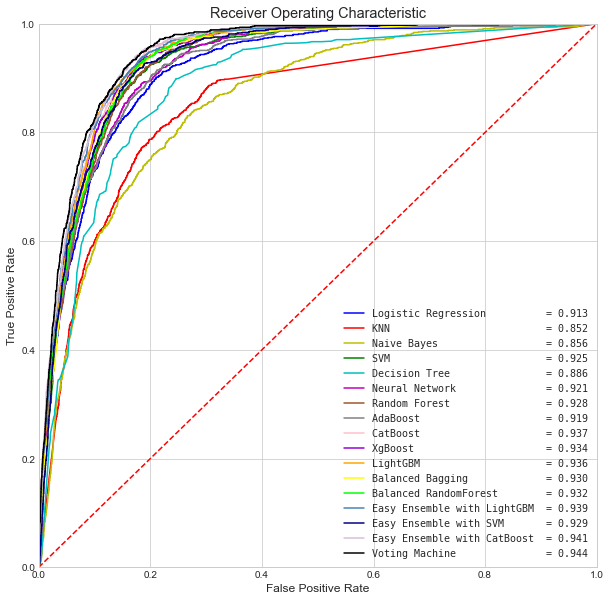

In [120]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')


plt.plot(fpr_lr, tpr_lr, 'b', label = '{:<28} = {:0.3f}'.format("Logistic Regression",auc_lr))
plt.plot(fpr_knn, tpr_knn, 'r', label = '{:<28} = {:0.3f}'.format("KNN",auc_knn))
plt.plot(fpr_nb, tpr_nb, 'y', label = '{:<28} = {:0.3f}'.format("Naive Bayes",auc_nb))
plt.plot(fpr_svm, tpr_svm, 'g', label = '{:<28} = {:0.3f}'.format("SVM",auc_svm))
plt.plot(fpr_tree, tpr_tree, 'c', label = '{:<28} = {:0.3f}'.format("Decision Tree",auc_tree))
plt.plot(fpr_ann, tpr_ann, 'm', label = '{:<28} = {:0.3f}'.format("Neural Network",auc_ann))
plt.plot(fpr_rf, tpr_rf, 'sienna', label = '{:<28} = {:0.3f}'.format("Random Forest",auc_rf))
plt.plot(fpr_adaboost, tpr_adaboost, 'gray', label = '{:<28} = {:0.3f}'.format("AdaBoost",auc_adaboost))
plt.plot(fpr_catboost, tpr_catboost, 'pink', label = '{:<28} = {:0.3f}'.format("CatBoost",auc_catboost))
plt.plot(fpr_xgboost, tpr_xgboost, 'darkviolet', label = '{:<28} = {:0.3f}'.format("XgBoost",auc_xgboost))
plt.plot(fpr_lightgbm, tpr_lightgbm, 'orange', label = '{:<28} = {:0.3f}'.format("LightGBM",auc_lightgbm))
plt.plot(fpr_bbc, tpr_bbc, 'yellow', label = '{:<28} = {:0.3f}'.format("Balanced Bagging",auc_bbc))
plt.plot(fpr_brf, tpr_brf, 'lime', label = '{:<28} = {:0.3f}'.format("Balanced RandomForest",auc_brf))
plt.plot(fpr_eec_lightgbm, tpr_eec_lightgbm, 'steelblue', label = '{:<28} = {:0.3f}'.format("Easy Ensemble with LightGBM",auc_eec_lightgbm))
plt.plot(fpr_eec_svm, tpr_eec_svm, 'navy', label = '{:<28} = {:0.3f}'.format("Easy Ensemble with SVM",auc_eec_svm))
plt.plot(fpr_eec_catboost, tpr_eec_catboost, 'thistle', label = '{:<28} = {:0.3f}'.format("Easy Ensemble with CatBoost",auc_eec_catboost))
plt.plot(fpr_voting, tpr_voting, 'black', label = '{:<28} = {:0.3f}'.format("Voting Machine",auc_voting))

# plt.plot(fpr_svm, tpr_svm, 'pink', label = 'SVM = {8:0.2f}'.format(svm_roc_auc))
# plt.plot(fpr_svm, tpr_svm, 'darkviolet', label = 'SVM = {8:0.2f}'.format(svm_roc_auc))

# fpr_ann, tpr_ann, auc_ann = compute_and_plot_roc_curve(ann, X_t, y_t,"Neural Network")
plt.legend(loc = 'lower right',prop={'family': 'monospace'})
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Experiments with clustering method

## [Experiment] Customised Clustering Classification

In [1]:
# NOTE:
# Use kmeans to find the centroids for the training data
# Then do a mapping by labeling each clusters wtih class label based on the class ratio between 1 and 0 in each cluster
# Apply this clustering model to the test data and do the "predictions"

In [2]:
def clustering_feature_creation(k,train_x,train_y,test_x):
    
    seed = np.random.seed(2022)
    kmeans = KMeans(n_clusters = k,random_state = 2021)
    kmeans.fit(train_x)
    kmeans_result = kmeans.labels_
    
    df = pd.DataFrame({
        'kmeans_result':kmeans_result,
        'y_train_o':train_y
    })

    predict = {}
    predict_proba = {}

    for i in range(k):

        cluster_y_counts = df[df['kmeans_result']==i].y_train_o.value_counts()
        s = df[df['kmeans_result']==i].y_train_o

        if len(cluster_y_counts) == 1 and int(s.sample(n=1)) == 1:
            predict[i] = 1
            predict_proba[i] = 1
        elif len(cluster_y_counts) == 1 and int(s.sample(n=1)) == 0:
            predict[i] = 0
            predict_proba[i] = 0
        elif cluster_y_counts[0] / cluster_y_counts[1] < 1:
            predict[i] = 1
            predict_proba[i] = cluster_y_counts[1] / (cluster_y_counts[0]+cluster_y_counts[1])
        elif cluster_y_counts[0] / cluster_y_counts[1] > 1:
            predict[i] = 0
            predict_proba[i] = cluster_y_counts[1] / (cluster_y_counts[0]+cluster_y_counts[1])
        elif cluster_y_counts[0] == cluster_y_counts[1]:
            predict[i] = 1
            predict_proba[i] = 0.5

    predict_result = kmeans.predict(test_x)
    train_clustering_label = []
    train_clustering_proba = []
    test_clustering_label = []
    test_clustering_proba = []
    
    for l in kmeans_result:
        train_clustering_label.append(predict[l])
        train_clustering_proba.append(predict_proba[l])
    
    for j in predict_result:
        test_clustering_label.append(predict[j])
        test_clustering_proba.append(predict_proba[j])
    
    return (train_clustering_label,train_clustering_proba,test_clustering_label,test_clustering_proba)

In [ ]:
# Oversampling

seed = np.random.seed(2021)

score_over = [[],[]]

for k in range (100,1000,100):
    
    train_x_os,train_y_os = re_sample(X_train_o, y_train_o, func='random_over_sample', random_state=2021)
    train,train_proba,predict,predict_propa = clustering_feature_creation(k,train_x_os,train_y_os,X_test_o)

    cl_mcc = round(matthews_corrcoef(y_test_o, predict),4)

    score_over[0].append(k)
    score_over[1].append(cl_mcc)

    row = [k]
    col = ['MCC']

    print(pd.DataFrame([[cl_mcc]],row,col))

In [ ]:
# Undersampling

seed = np.random.seed(2021)

score_under = [[],[]]

for k in range (100,1400,100):
    
    train_x_os,train_y_os = re_sample(X_train_o, y_train_o, func='random_under_sample', random_state=2021)
    train,train_proba,predict,predict_propa = clustering_feature_creation(k,train_x_os,train_y_os,X_test_o)

    cl_mcc = round(matthews_corrcoef(y_test_o, predict),4)
    
    score_under[0].append(k)
    score_under[1].append(cl_mcc)

    row = [k]
    col = ['MCC']

    print(pd.DataFrame([[cl_mcc]],row,col))

In [3]:
# Take long time to run oversampling and undersampling, put here as record
score_over = [[100,200,300,400,500,600,700,800,900,1000,1100,1200,1300],
              [0.272,0.311,0.331,0.328,0.343,0.342,0.358,0.351,0.358,0.359,0.355,0.349,0.357]]
score_under = [[100,200,300,400,500,600,700,800,900,1000,1100,1200,1300],
              [0.267,0.314,0.311,0.330,0.337,0.341,0.347,0.340,0.342,0.346,0.349,0.332,0.329]]

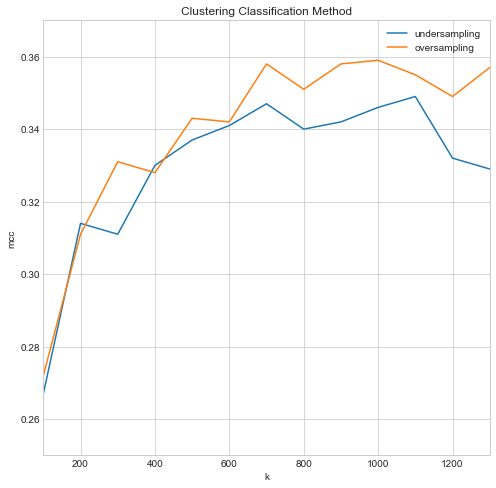

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(score_under[0], score_under[1],label='undersampling')
ax.plot(score_over[0], score_over[1],label='oversampling')
ax.set(xlim=(100, 1300), ylim=(0.25, 0.37),
       xlabel='k', ylabel='mcc',
       title='Clustering Classification Method');
plt.legend();

## [Implication] Clustering Feature Engineering

In [7]:
# NOTE:
# The performance of the pure clustering classification seems not so good
# Instead, maybe can use the result as new features to improve other classification models 
# Since k = 700 performs well in the pure clustering classification, k = 700 will be used for the feature engineering

In [40]:
# Random Forest on the test set with oversampling (no clustering feature engineering)

seed = np.random.seed(2021)
min_max_scaler = MinMaxScaler()

# Use the selected hyperparameters
rf = RandomForestClassifier(criterion = 'entropy',
                            max_depth = 15,
                            max_features = 'sqrt',
                            n_estimators = 300,
                            random_state=2021)

# Feature selection: remove features with low variance (42 -> 40 features)
sel = VarianceThreshold(threshold=0.01)
sel_var=sel.fit_transform(X_train_o)
train_x_lv = X_train_o[X_train_o.columns[sel.get_support(indices=True)]]
test_x_lv = X_test_o[train_x_lv.columns]
#print(train_x_lv.shape)

# Feature selection: remove one of the highly correlated features > 0.8 (40 -> 39 features)
correlation_train = train_x_lv.corr(method="pearson")
columns = np.full((correlation_train.shape[0],), True, dtype=bool)
for i in range(correlation_train.shape[0]):
    for j in range(i+1, correlation_train.shape[0]):
        if abs(correlation_train.iloc[i,j]) >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = train_x_lv.columns[columns]
train_x_cf = train_x_lv[selected_columns]
test_x_cf = test_x_lv[selected_columns]
#print(train_x_cf.shape)

train_x_os,train_y_os = re_sample(train_x_cf, y_train_o, func='SMOTE', random_state=2021)

# Train the model
rf.fit(train_x_os, train_y_os)
rf_predict = rf.predict(test_x_cf)
rf_predict_prob = rf.predict_proba(test_x_cf)

# Metrics
rf_f1 = f1_score(y_test_o, rf_predict,pos_label=1)
rf_recall = recall_score(y_test_o, rf_predict,pos_label=1)
rf_precision = precision_score(y_test_o, rf_predict,pos_label=1)
rf_mcc = matthews_corrcoef(y_test_o, rf_predict)
rf_kappa = cohen_kappa_score(y_test_o, rf_predict)
rf_auc = roc_auc_score(y_test_o, rf_predict_prob[:, 1])

print("Random Forest Test Set Score:","\n")
row = ['Yes']
col = ['F1','Recall','Precision','MCC','Kappa',"AUC"]

print(pd.DataFrame([[round(rf_f1,4),round(rf_recall,4),round(rf_precision,4),
                     round(rf_mcc,4),round(rf_kappa,4),round(rf_auc,4)]],row,col))

Random Forest Test Set Score: 

       F1  Recall  Precision   MCC  Kappa   AUC
Yes 0.559   0.589      0.533 0.499  0.498 0.921


In [41]:
# Random Forest on the test set with oversampling (clustering feature engineering)

seed = np.random.seed(2021)

# Use the selected hyperparameters
rf = RandomForestClassifier(criterion = 'entropy',
                            max_depth = 15,
                            max_features = 'sqrt',
                            n_estimators = 300,
                            random_state=2021)


# Feature selection: remove features with low variance (42 -> 40 features)
sel = VarianceThreshold(threshold=0.01)
sel_var=sel.fit_transform(X_train_o)
train_x_lv = X_train_o[X_train_o.columns[sel.get_support(indices=True)]]
test_x_lv = X_test_o[train_x_lv.columns]
#print(train_x_lv.shape)

# Feature selection: remove one of the highly correlated features > 0.8 (40 -> 39 features)
correlation_train = train_x_lv.corr(method="pearson")
columns = np.full((correlation_train.shape[0],), True, dtype=bool)
for i in range(correlation_train.shape[0]):
    for j in range(i+1, correlation_train.shape[0]):
        if abs(correlation_train.iloc[i,j]) >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = train_x_lv.columns[columns]
train_x_cf = train_x_lv[selected_columns]
test_x_cf = test_x_lv[selected_columns]
#print(train_x_cf.shape)

train_x_os,train_y_os = re_sample(train_x_cf, y_train_o, func='SMOTE', random_state=2021)

# Clustering feature engineering
train,train_proba,predict,predict_propa = clustering_feature_creation(700,train_x_os,train_y_os,test_x_cf)
#train_x_os['cluster_label'] = train
train_x_os['cluster_proba'] = train_proba
#test_x_cf['cluster_label'] = predict
test_x_cf['cluster_proba'] = predict_propa

# Train the model
rf.fit(train_x_os, train_y_os)
rf_predict = rf.predict(test_x_cf)
rf_predict_prob = rf.predict_proba(test_x_cf)

# Metrics
rf_f1 = f1_score(y_test_o, rf_predict,pos_label=1)
rf_recall = recall_score(y_test_o, rf_predict,pos_label=1)
rf_precision = precision_score(y_test_o, rf_predict,pos_label=1)
rf_mcc = matthews_corrcoef(y_test_o, rf_predict)
rf_kappa = cohen_kappa_score(y_test_o, rf_predict)
rf_auc = roc_auc_score(y_test_o, rf_predict_prob[:, 1])

print("Random Forest Test Set Score:","\n")
row = ['Yes']
col = ['F1','Recall','Precision','MCC','Kappa',"AUC"]

print(pd.DataFrame([[round(rf_f1,4),round(rf_recall,4),round(rf_precision,4),
                     round(rf_mcc,4),round(rf_kappa,4),round(rf_auc,4)]],row,col))

Random Forest Test Set Score: 

       F1  Recall  Precision   MCC  Kappa   AUC
Yes 0.572   0.627      0.525 0.512  0.509 0.920


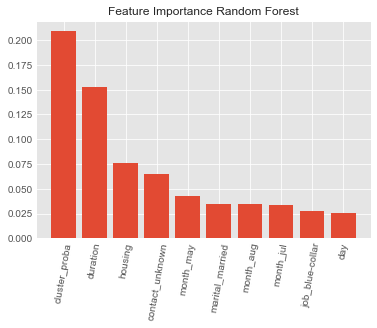

In [43]:
# Feature importance
ranking = rf.feature_importances_
features = np.argsort(ranking)[::-1][:10]
columns = train_x_os.columns
plt.title("Feature Importance Random Forest", y = 1, size = 12)
plt.bar(range(len(features)), ranking[features], align="center")
plt.xticks(range(len(features)), columns[features], rotation=80)
plt.show()

## [Experiment] Clustering Centroids Based Training

In [42]:
# NOTE:
# Another experiment is to use centroids data found by clustering to train the model
# As compared to the model with same setting trained by the same number of randomly selected data

In [ ]:
# Logistic Regression on the test set (random k data)

seed = np.random.seed(2021)
min_max_scaler = MinMaxScaler()

# Use the selected hyperparameters
lr = LogisticRegression(C = 1,
                        max_iter = 100,
                        penalty = 'l1',
                        solver = 'saga',
                        random_state = 2021)


score_randomk = [[],[]]

for k in range(400,3100,100):
    # Feature selection: remove features with low variance (42 -> 40 features)
    sel = VarianceThreshold(threshold=0.01)
    sel_var=sel.fit_transform(X_train_o)
    train_x_lv = X_train_o[X_train_o.columns[sel.get_support(indices=True)]]
    test_x_lv = X_test_o[train_x_lv.columns]
    #print(train_x_lv.shape)

    # Feature selection: remove one of the highly correlated features > 0.8 (40 -> 39 features)
    correlation_train = train_x_lv.corr(method="pearson")
    columns = np.full((correlation_train.shape[0],), True, dtype=bool)
    for i in range(correlation_train.shape[0]):
        for j in range(i+1, correlation_train.shape[0]):
            if abs(correlation_train.iloc[i,j]) >= 0.8:
                if columns[j]:
                    columns[j] = False
    selected_columns = train_x_lv.columns[columns]
    train_x_cf = train_x_lv[selected_columns]
    test_x_cf = test_x_lv[selected_columns]
    #print(train_x_cf.shape)

    # Undersampling
    train_x_os,train_y_os = re_sample(train_x_cf, y_train_o, func='random_under_sample', random_state=2021)

    # Data normalisation
    train_x_dn = pd.DataFrame(min_max_scaler.fit_transform(train_x_os),columns=train_x_os.columns)
    test_x_dn = pd.DataFrame(min_max_scaler.transform(test_x_cf),columns=test_x_cf.columns)


    # Random select number of k data to train
    xx = train_x_dn.sample(n=k, random_state=2021)
    #print(xx.shape)
    yy = pd.DataFrame(train_y_os).loc[xx.index]
    #print(yy)
    y_t = pd.Series(yy[0].values)
    #print(y_t)
    x_t = xx.reset_index()
    x_t = x_t.drop(x_t.columns[[0]], axis=1)
    #print(x_t,x_t.shape)

    # Train the model
    lr.fit(x_t, y_t)
    lr_predict = lr.predict(test_x_dn)
    lr_predict_prob = lr.predict_proba(test_x_dn)

    # Metrics
    lr_mcc = round(matthews_corrcoef(y_test_o, lr_predict),4)

    score_randomk[0].append(k)
    score_randomk[1].append(lr_mcc)         

    row = [k]
    col = ['MCC']

    print(pd.DataFrame([[lr_mcc]],row,col))

In [ ]:
# Logistic Regression on the test set (trained based on centroids data)

seed = np.random.seed(2021)
min_max_scaler = MinMaxScaler()

# Use the selected hyperparameters
lr = LogisticRegression(C = 1,
                        max_iter = 100,
                        penalty = 'l1',
                        solver = 'saga',
                        random_state = 2021)


score_centroids = [[],[]]

for k in range(400,3100,100):
    # Feature selection: remove features with low variance (42 -> 40 features)
    sel = VarianceThreshold(threshold=0.01)
    sel_var=sel.fit_transform(X_train_o)
    train_x_lv = X_train_o[X_train_o.columns[sel.get_support(indices=True)]]
    test_x_lv = X_test_o[train_x_lv.columns]
    #print(train_x_lv.shape)

    # Feature selection: remove one of the highly correlated features > 0.8 (40 -> 39 features)
    correlation_train = train_x_lv.corr(method="pearson")
    columns = np.full((correlation_train.shape[0],), True, dtype=bool)
    for i in range(correlation_train.shape[0]):
        for j in range(i+1, correlation_train.shape[0]):
            if abs(correlation_train.iloc[i,j]) >= 0.8:
                if columns[j]:
                    columns[j] = False
    selected_columns = train_x_lv.columns[columns]
    train_x_cf = train_x_lv[selected_columns]
    test_x_cf = test_x_lv[selected_columns]
    #print(train_x_cf.shape)

    # Undersampling
    train_x_os,train_y_os = re_sample(train_x_cf, y_train_o, func='random_under_sample', random_state=2021)

    # Data normalisation
    train_x_dn = pd.DataFrame(min_max_scaler.fit_transform(train_x_os),columns=train_x_os.columns)
    test_x_dn = pd.DataFrame(min_max_scaler.transform(test_x_cf),columns=test_x_cf.columns)


    # Select centroids data to train
    kmeans = KMeans(n_clusters=k,random_state = 2021)
    X_dist = kmeans.fit_transform(train_x_dn)
    representative_idx = np.argmin(X_dist, axis=0)
    X_representative = train_x_dn.iloc[representative_idx]
    y_representative = [list(train_y_os)[x] for x in representative_idx]

    # Train the model
    lr.fit(X_representative, y_representative)
    lr_predict = lr.predict(test_x_dn)
    lr_predict_prob = lr.predict_proba(test_x_dn)

    # Metrics
    lr_mcc = round(matthews_corrcoef(y_test_o, lr_predict),4)

    score_centroids[0].append(k)
    score_centroids[1].append(lr_mcc)         

    row = [k]
    col = ['MCC']

    print(pd.DataFrame([[lr_mcc]],row,col))

In [44]:
# Take long time to run two tests above, put here as record
score_randomk = [[400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000],
              [0.440,0.467,0.483,0.483,0.491,0.488,0.488,0.493,0.495,0.484,0.496,0.505,0.508,0.506,0.505,0.505,0.506,0.503,0.498,0.503,0.501,0.510,0.507,0.502,0.509,0.502,0.505]]
score_centroids = [[400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000],
              [0.504,0.509,0.502,0.500,0.516,0.525,0.497,0.502,0.510,0.509,0.511,0.503,0.502,0.510,0.511,0.498,0.499,0.500,0.491,0.507,0.493,0.512,0.503,0.498,0.486,0.500,0.509]]

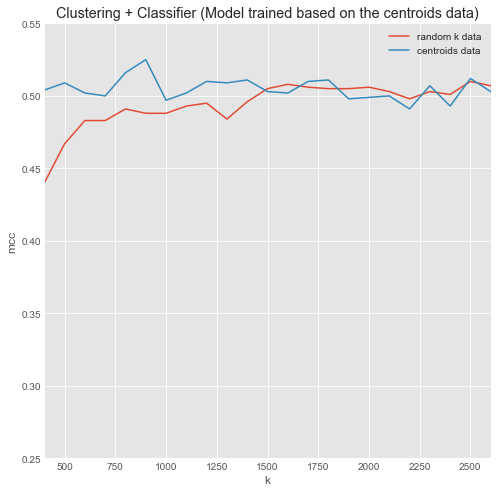

In [45]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(score_randomk[0], score_randomk[1],label='random k data')
ax.plot(score_centroids[0], score_centroids[1],label='centroids data')
ax.set(xlim=(400, 2600), ylim=(0.25, 0.55),
       xlabel='k', ylabel='mcc',
       title='Clustering + Classifier (Model trained based on the centroids data)');
plt.legend();

## [Implication] Centroids Based Undersampling

In [47]:
# Comparison between random undersampling and centroids based undersampling

Logistic Regression Random Undersampling Test Set Score: 

       F1  Recall  Precision   MCC  Kappa   AUC
Yes 0.554   0.829      0.416 0.513  0.472 0.913


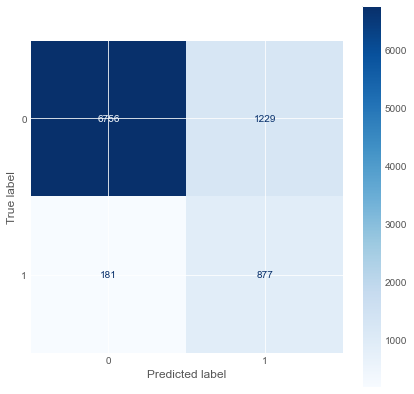

In [46]:
# Logistic Regression on the test set (random undersampling)

seed = np.random.seed(2021)
min_max_scaler = MinMaxScaler()

# Use the selected hyperparameters
lr = LogisticRegression(C = 1,
                        max_iter = 100,
                        penalty = 'l1',
                        solver = 'saga',
                        random_state = 2021)


# Feature selection: remove features with low variance (42 -> 40 features)
sel = VarianceThreshold(threshold=0.01)
sel_var=sel.fit_transform(X_train_o)
train_x_lv = X_train_o[X_train_o.columns[sel.get_support(indices=True)]]
test_x_lv = X_test_o[train_x_lv.columns]
#print(train_x_lv.shape)

# Feature selection: remove one of the highly correlated features > 0.8 (40 -> 39 features)
correlation_train = train_x_lv.corr(method="pearson")
columns = np.full((correlation_train.shape[0],), True, dtype=bool)
for i in range(correlation_train.shape[0]):
    for j in range(i+1, correlation_train.shape[0]):
        if abs(correlation_train.iloc[i,j]) >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = train_x_lv.columns[columns]
train_x_cf = train_x_lv[selected_columns]
test_x_cf = test_x_lv[selected_columns]
#print(train_x_cf.shape)

# Undersampling
train_x_os,train_y_os = re_sample(train_x_cf, y_train_o, func='random_under_sample', random_state=2021)

# Data normalisation
train_x_dn = pd.DataFrame(min_max_scaler.fit_transform(train_x_os),columns=train_x_os.columns)
test_x_dn = pd.DataFrame(min_max_scaler.transform(test_x_cf),columns=test_x_cf.columns)

#print(len(train_y_os))

# Train the model
lr.fit(train_x_dn, train_y_os)
lr_predict = lr.predict(test_x_dn)
lr_predict_prob = lr.predict_proba(test_x_dn)

# Metrics
lr_f1 = f1_score(y_test_o, lr_predict,pos_label=1)
lr_recall = recall_score(y_test_o, lr_predict,pos_label=1)
lr_precision = precision_score(y_test_o, lr_predict,pos_label=1)
lr_mcc = matthews_corrcoef(y_test_o, lr_predict)
lr_kappa = cohen_kappa_score(y_test_o, lr_predict)
lr_auc = roc_auc_score(y_test_o, lr_predict_prob[:, 1])

print("Logistic Regression Random Undersampling Test Set Score:","\n")
row = ['Yes']
col = ['F1','Recall','Precision','MCC','Kappa',"AUC"]

print(pd.DataFrame([[round(lr_f1,4),round(lr_recall,4),round(lr_precision,4),
                     round(lr_mcc,4),round(lr_kappa,4),round(lr_auc,4)]],row,col))

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, test_x_dn, y_test_o,cmap=plt.cm.Blues,ax=ax)

4231
Logistic Regression Clustering centroid based undersampling Test Set Score: 

       F1  Recall  Precision   MCC  Kappa   AUC
Yes 0.483   0.819      0.343 0.438  0.382 0.884


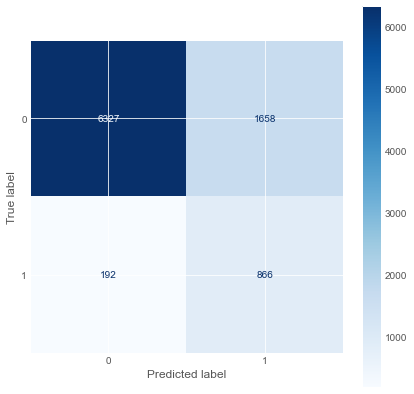

In [48]:
# Logistic Regression on the test set (Application: Clustering centroids based undersampling)

seed = np.random.seed(2021)
min_max_scaler = MinMaxScaler()

# Use the selected hyperparameters
lr = LogisticRegression(C = 1,
                        max_iter = 100,
                        penalty = 'l1',
                        solver = 'saga',
                        random_state = 2021)


# Feature selection: remove features with low variance (42 -> 40 features)
sel = VarianceThreshold(threshold=0.01)
sel_var=sel.fit_transform(X_train_o)
train_x_lv = X_train_o[X_train_o.columns[sel.get_support(indices=True)]]
test_x_lv = X_test_o[train_x_lv.columns]
#print(train_x_lv.shape)

# Feature selection: remove one of the highly correlated features > 0.8 (40 -> 39 features)
correlation_train = train_x_lv.corr(method="pearson")
columns = np.full((correlation_train.shape[0],), True, dtype=bool)
for i in range(correlation_train.shape[0]):
    for j in range(i+1, correlation_train.shape[0]):
        if abs(correlation_train.iloc[i,j]) >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = train_x_lv.columns[columns]
train_x_cf = train_x_lv[selected_columns]
test_x_cf = test_x_lv[selected_columns]
#print(train_x_cf.shape)


# Clustering centroid based undersampling
train_x = train_x_cf.reset_index(drop = True)
train_x['y'] = y_train_o
index_no = train_x[train_x['y'] == 0].index
index_yes = train_x[train_x['y'] == 1].index

train_x_t = pd.DataFrame(min_max_scaler.fit_transform(train_x),columns=train_x.columns)

train_x_no_t = train_x_t.iloc[index_no].reset_index(drop = True)
train_x_yes_t = train_x_t.iloc[index_yes].reset_index(drop = True)

train_x_no_drop_t = train_x_no_t.drop(columns = ['y'])
train_x_yes_drop_t = train_x_yes_t.drop(columns = ['y'])


train_x_no = train_x.iloc[index_no].reset_index(drop = True)
train_x_yes = train_x.iloc[index_yes].reset_index(drop = True)
y_no = train_x_no['y']
y_yes = train_x_yes['y']

train_x_no_drop = train_x_no.drop(columns = ['y'])
train_x_yes_drop = train_x_yes.drop(columns = ['y'])

print(len(y_yes))
#print(y_no,train_x_no_drop)

# Select centroids data to train
kmeans = KMeans(n_clusters=4231,random_state = 2021)
X_dist = kmeans.fit_transform(train_x_no_drop_t)
#print(X_dist.shape)
representative_idx = np.argmin(X_dist, axis=0)
#print(representative_idx)
#print(train_x_no_drop)
train_x_no_select = train_x_no_drop.iloc[representative_idx]
#print(train_x_no_select)
y_no_select = [list(y_no)[x] for x in representative_idx]
#print(y_no_select)


train_x_join = train_x_yes_drop.append(train_x_no_select, ignore_index = True)
train_y_join = pd.concat([y_yes, pd.Series(y_no_select)], axis=0).reset_index(drop = True)
#print(train_x_no_select,train_x_yes_drop)
#print(train_x_join,train_y_join)
#print(np.unique(train_y_join, return_counts=True))

#print(train_x_join)
# Data normalisation
train_x_dn = pd.DataFrame(min_max_scaler.fit_transform(train_x_join),columns=train_x_join.columns)
test_x_dn = pd.DataFrame(min_max_scaler.transform(test_x_cf),columns=test_x_cf.columns)
#print(test_x_dn)


# Train the model
lr.fit(train_x_dn, train_y_join)
lr_predict = lr.predict(test_x_dn)
lr_predict_prob = lr.predict_proba(test_x_dn)

# Metrics
lr_f1 = f1_score(y_test_o, lr_predict,pos_label=1)
lr_recall = recall_score(y_test_o, lr_predict,pos_label=1)
lr_precision = precision_score(y_test_o, lr_predict,pos_label=1)
lr_mcc = matthews_corrcoef(y_test_o, lr_predict)
lr_kappa = cohen_kappa_score(y_test_o, lr_predict)
lr_auc = roc_auc_score(y_test_o, lr_predict_prob[:, 1])

print("Logistic Regression Clustering centroid based undersampling Test Set Score:","\n")
row = ['Yes']
col = ['F1','Recall','Precision','MCC','Kappa',"AUC"]

print(pd.DataFrame([[round(lr_f1,4),round(lr_recall,4),round(lr_precision,4),
                     round(lr_mcc,4),round(lr_kappa,4),round(lr_auc,4)]],row,col))

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, test_x_dn, y_test_o,cmap=plt.cm.Blues,ax=ax)

# appendix(hyperparameter tuning)

## Logistic Regression

In [ ]:
# # Logistic Regression algorithm based modeling
# lr = LogisticRegression(random_state = 2021,class_weight = 'balanced')
# mcc_scorer = make_scorer(matthews_corrcoef)

# lr_accuracy=[[],[]]
# lr_f1=[[],[]]
# lr_recall=[[],[]]
# lr_precision=[[],[]]
# lr_mcc=[[],[]]
# lr_auc=[[],[]]

# x = X_train_o.reset_index()
# x = x.drop(x.columns[0],axis=1)
# y = pd.Series(y_train_o)
# min_max_scaler = MinMaxScaler()

# # Stratified Cross Validation
# for train_index, test_index in skf.split(x, y):
#     train_x, train_y = x.loc[train_index,:],y[train_index]
#     test_x,test_y = x.loc[test_index,:],y[test_index]
    
#     # feature selection: remove features with low variance
#     sel = VarianceThreshold(threshold=0.01)
#     sel_var=sel.fit_transform(train_x)
#     train_x_lv = train_x[train_x.columns[sel.get_support(indices=True)]]
#     test_x_lv = test_x[train_x_lv.columns]
    
#     # feature selection: remove one of the highly correlated features
#     correlation_train = train_x_lv.corr(method="pearson")
#     columns = np.full((correlation_train.shape[0],), True, dtype=bool)
#     for i in range(correlation_train.shape[0]):
#         for j in range(i+1, correlation_train.shape[0]):
#             if abs(correlation_train.iloc[i,j]) >= threshold:
#                 if columns[j]:
#                     columns[j] = False
#     selected_columns = train_x_lv.columns[columns]
#     train_x_cf = train_x_lv[selected_columns]
#     test_x_cf = test_x_lv[selected_columns] 
    
#     # Data rescaling
#     train_x_dn = pd.DataFrame(min_max_scaler.fit_transform(train_x_cf),columns=train_x_cf.columns)
#     test_x_dn = pd.DataFrame(min_max_scaler.transform(test_x_cf),columns=test_x_cf.columns)

#     # grid search
#     cv_gs = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
#     space = dict()
#     space['solver'] = ['newton-cg','lbfgs','liblinear','saga']
#     space['C'] = [0.01, 0.1, 1, 10, 100]
#     space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
#     search = GridSearchCV(lr, space, scoring=mcc_scorer, cv=cv_gs, refit=True,n_jobs=-1)
#     result = search.fit(train_x_dn,train_y)
#     best_model = result.best_estimator_
#     lr_predict = best_model.predict(test_x_dn)
#     lr_predict_prob = best_model.predict_proba(test_x_dn)
#     print('cfg=%s' % (result.best_params_))# vote for the majority out of 5 results
    
#     # Metrics
#     lr_accuracy[0].append(accuracy_score(test_y, lr_predict))
#     lr_accuracy[1].append(accuracy_score(test_y, lr_predict))
    
#     lr_f1[0].append(f1_score(test_y, lr_predict,pos_label=0))
#     lr_f1[1].append(f1_score(test_y, lr_predict,pos_label=1))
    
#     lr_recall[0].append(recall_score(test_y, lr_predict,pos_label=0))
#     lr_recall[1].append(recall_score(test_y, lr_predict,pos_label=1))
    
#     lr_precision[0].append(precision_score(test_y, lr_predict,pos_label=0))
#     lr_precision[1].append(precision_score(test_y, lr_predict,pos_label=1))
    
#     lr_mcc[0].append(matthews_corrcoef(test_y, lr_predict))
#     lr_mcc[1].append(matthews_corrcoef(test_y, lr_predict))
    
#     lr_auc[0].append(roc_auc_score(test_y, lr_predict_prob[:, 0]))
#     lr_auc[1].append(roc_auc_score(test_y, lr_predict_prob[:, 1]))
    
# #     # Confusion Matrix
# #     plot_confusion_matrix(lr, test_x_dn, test_y) 
    
# #     # Important Features
# #     rfe=RFE(lr, n_features_to_select=10)
# #     rfe=rfe.fit(train_x_dn,train_y_os)
# #     print("Feature Selection","\n")
# #     print(train_x_dn[train_x_dn.columns[rfe.ranking_==1].values].columns,"\n")

# print("Algorithm Based Modeling Logistic Regression Average Metric Score:","\n")
# row = ['0', '1']
# col = ['Accuracy','F1','Recall','Precision','MCC',"AUC"]

# pd.DataFrame([[round(mean(lr_accuracy[0]),2),round(mean(lr_f1[0]),2),round(mean(lr_recall[0]),2),
#               round(mean(lr_precision[0]),2),round(mean(lr_mcc[0]),2),round(mean(lr_auc[0]),2)],
#               [round(mean(lr_accuracy[1]),2),round(mean(lr_f1[1]),2),round(mean(lr_recall[1]),2),
#               round(mean(lr_precision[1]),2),round(mean(lr_mcc[1]),2),round(mean(lr_auc[1]),2)]],row,col)

In [ ]:
# # Logistic Regression oversample
# lr = LogisticRegression(random_state = 2021)
# mcc_scorer = make_scorer(matthews_corrcoef)

# lr_accuracy=[[],[]]
# lr_f1=[[],[]]
# lr_recall=[[],[]]
# lr_precision=[[],[]]
# lr_mcc=[[],[]]
# lr_auc=[[],[]]

# x = X_train_o.reset_index()
# x = x.drop(x.columns[0],axis=1)
# y = pd.Series(y_train_o)
# min_max_scaler = MinMaxScaler()

# # Stratified Cross Validation
# for train_index, test_index in skf.split(x, y):
#     train_x, train_y = x.loc[train_index,:],y[train_index]
#     test_x,test_y = x.loc[test_index,:],y[test_index]
    
#     # feature selection: remove features with low variance
#     sel = VarianceThreshold(threshold=0.01)
#     sel_var=sel.fit_transform(train_x)
#     train_x_lv = train_x[train_x.columns[sel.get_support(indices=True)]]
#     test_x_lv = test_x[train_x_lv.columns]
    
#     # feature selection: remove one of the highly correlated features
#     correlation_train = train_x_lv.corr(method="pearson")
#     columns = np.full((correlation_train.shape[0],), True, dtype=bool)
#     for i in range(correlation_train.shape[0]):
#         for j in range(i+1, correlation_train.shape[0]):
#             if abs(correlation_train.iloc[i,j]) >= threshold:
#                 if columns[j]:
#                     columns[j] = False
#     selected_columns = train_x_lv.columns[columns]
#     train_x_cf = train_x_lv[selected_columns]
#     test_x_cf = test_x_lv[selected_columns] 
    
#     # over-sampling with repeated minority class samples
#     #train_x_os,train_y_os = oversample(train_x_cf, train_y)
#     train_x_os,train_y_os = re_sample(train_x_cf, train_y, func='SMOTE', random_state=2021)
    
#     # Data rescaling
#     train_x_dn = pd.DataFrame(min_max_scaler.fit_transform(train_x_os),columns=train_x_os.columns)
#     test_x_dn = pd.DataFrame(min_max_scaler.transform(test_x_cf),columns=test_x_cf.columns)
    
#     # grid search
#     cv_gs = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
#     space = dict()
#     space['solver'] = ['newton-cg','lbfgs','liblinear','saga']
#     space['C'] = [0.01, 0.1, 1, 10, 100]
#     space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
#     search = GridSearchCV(lr, space, scoring=mcc_scorer, cv=cv_gs, refit=True,n_jobs=-1)
#     result = search.fit(train_x_dn,train_y_os)
#     best_model = result.best_estimator_
#     lr_predict = best_model.predict(test_x_dn)
#     lr_predict_prob = best_model.predict_proba(test_x_dn)
#     print('cfg=%s' % (result.best_params_))# vote for the majority out of 5 results
    
#     # Metrics
#     lr_accuracy[0].append(accuracy_score(test_y, lr_predict))
#     lr_accuracy[1].append(accuracy_score(test_y, lr_predict))
    
#     lr_f1[0].append(f1_score(test_y, lr_predict,pos_label=0))
#     lr_f1[1].append(f1_score(test_y, lr_predict,pos_label=1))
    
#     lr_recall[0].append(recall_score(test_y, lr_predict,pos_label=0))
#     lr_recall[1].append(recall_score(test_y, lr_predict,pos_label=1))
    
#     lr_precision[0].append(precision_score(test_y, lr_predict,pos_label=0))
#     lr_precision[1].append(precision_score(test_y, lr_predict,pos_label=1))
    
#     lr_mcc[0].append(matthews_corrcoef(test_y, lr_predict))
#     lr_mcc[1].append(matthews_corrcoef(test_y, lr_predict))
    
#     lr_auc[0].append(roc_auc_score(test_y, lr_predict_prob[:, 0]))
#     lr_auc[1].append(roc_auc_score(test_y, lr_predict_prob[:, 1]))
    
# #     # Confusion Matrix
# #     plot_confusion_matrix(lr, test_x_dn, test_y) 
    
# #     # Important Features
# #     rfe=RFE(lr, n_features_to_select=10)
# #     rfe=rfe.fit(train_x_dn,train_y_os)
# #     print("Feature Selection","\n")
# #     print(train_x_dn[train_x_dn.columns[rfe.ranking_==1].values].columns,"\n")

# print("Over-Sampling Logistic Regression Average Metric Score:","\n")
# row = ['0', '1']
# col = ['Accuracy','F1','Recall','Precision','MCC',"AUC"]

# pd.DataFrame([[round(mean(lr_accuracy[0]),2),round(mean(lr_f1[0]),2),round(mean(lr_recall[0]),2),
#               round(mean(lr_precision[0]),2),round(mean(lr_mcc[0]),2),round(mean(lr_auc[0]),2)],
#               [round(mean(lr_accuracy[1]),2),round(mean(lr_f1[1]),2),round(mean(lr_recall[1]),2),
#               round(mean(lr_precision[1]),2),round(mean(lr_mcc[1]),2),round(mean(lr_auc[1]),2)]],row,col)

## KNN

In [91]:

# start = time.time()
# for n_neighbors in [3,5,7,9]:
#     for weights in ['uniform','distance']:
#         knn_mcc = []
#         knn_auc = []
#         for i, (train_index, valid_index) in enumerate(skf.split(X_train_o, y_train_o)):
#             X_train_split, y_train_split, X_val_split, y_val_split = X_train_o.iloc[train_index], y_train_o[train_index], X_train_o.iloc[valid_index], y_train_o[valid_index]
            
#             #standardization
#             scaler = StandardScaler()
#             X_train_scaled = scaler.fit_transform(X_train_split)
#             X_val_scaled = scaler.transform(X_val_split)
            
#             # resample
#             X_train_re, y_train_re = re_sample(X_train_scaled, y_train_split, func='random_over_sample')
            
            
#             knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, n_jobs=-1)
            
#             model = knn.fit(X_train_re, y_train_re)
            
#             val_pred = model.predict(X_val_scaled)
# #             val_pred_proba = model.predict_proba(X_val_scaled)
            
#             knn_mcc.append(matthews_corrcoef(y_val_split, val_pred))
#             knn_auc.append(roc_auc_score(y_val_split, val_pred))

#         print('/n******** n_neighbors: {} ******** weights: {}***********'.format(n_neighbors,weights))
#         print('mcc:',knn_mcc)
#         print(f"mcc_mean:{np.mean(knn_mcc)}")
#         print(f"mcc_std:{np.std(knn_mcc)}")
#         print('auc:',knn_auc)
#         print(f"acc_mean:{np.mean(knn_auc)}")
#         print(f"acc_std:{np.std(knn_auc)}")

# end = time.time()
# print(f'duration: {end-start}')
# # plot_confusion_matrix(model, X_val_scaled, y_val_split)

In [92]:
# resample_list = ['random_over_sample','SMOTE','ADASYN','BorderlineSMOTE','KMeansSMOTE', 'ClusterCentroids','random_under_sample']
# start = time.time()
# for n_neighbors in [3,5,7,9]:
#     for func in ['random_over_sample','SMOTE','random_under_sample']:#'KMeansSMOTE',
#         knn_mcc = []
#         knn_auc = []
#         for i, (train_index, valid_index) in enumerate(skf.split(X_train_o, y_train_o)):
#             X_train_split, y_train_split, X_val_split, y_val_split = X_train_o.iloc[train_index], y_train_o[train_index], X_train_o.iloc[valid_index], y_train_o[valid_index]
            
#             #standardization
#             scaler = StandardScaler()
#             X_train_scaled = scaler.fit_transform(X_train_split)
#             X_val_scaled = scaler.transform(X_val_split)
            
#             # resample
#             X_train_re, y_train_re = re_sample(X_train_scaled, y_train_split, func=func)
            
            
#             knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance', n_jobs=-1)
            
#             model = knn.fit(X_train_re, y_train_re)
            
#             val_pred = model.predict(X_val_scaled)
# #             val_pred_proba = model.predict_proba(X_val_scaled)
            
#             knn_mcc.append(matthews_corrcoef(y_val_split, val_pred))
#             knn_auc.append(roc_auc_score(y_val_split, val_pred))

#         print('/n******** n_neighbors: {} ******** func: {}***********'.format(n_neighbors,func))
#         print('mcc:',knn_mcc)
#         print(f"mcc_mean:{np.mean(knn_mcc)}")
#         print(f"mcc_std:{np.std(knn_mcc)}")
#         print('auc:',knn_auc)
#         print(f"acc_mean:{np.mean(knn_auc)}")
#         print(f"acc_std:{np.std(knn_auc)}")

# end = time.time()
# print(f'duration: {end-start}')
# # plot_confusion_matrix(model, X_val_scaled, y_val_split)

## Naive Bayes

In [49]:
# # Naive Bayes oversample
# nb = GaussianNB()
# mcc_scorer = make_scorer(matthews_corrcoef)

# nb_accuracy=[[],[]]
# nb_f1=[[],[]]
# nb_recall=[[],[]]
# nb_precision=[[],[]]
# nb_mcc=[[],[]]
# nb_auc=[[],[]]

# x = X_train_o.reset_index()
# x = x.drop(x.columns[0],axis=1)
# y = pd.Series(y_train_o)

# # Stratified Cross Validation
# for train_index, test_index in skf.split(x, y):
#     train_x, train_y = x.loc[train_index,:],y[train_index]
#     test_x,test_y = x.loc[test_index,:],y[test_index]
    
#     # feature selection: remove features with low variance
#     sel = VarianceThreshold(threshold=0.01)
#     sel_var=sel.fit_transform(train_x)
#     train_x_lv = train_x[train_x.columns[sel.get_support(indices=True)]]
#     test_x_lv = test_x[train_x_lv.columns]
    
#     # feature selection: remove one of the highly correlated features
#     correlation_train = train_x_lv.corr(method="pearson")
#     columns = np.full((correlation_train.shape[0],), True, dtype=bool)
#     for i in range(correlation_train.shape[0]):
#         for j in range(i+1, correlation_train.shape[0]):
#             if abs(correlation_train.iloc[i,j]) >= threshold:
#                 if columns[j]:
#                     columns[j] = False
#     selected_columns = train_x_lv.columns[columns]
#     train_x_cf = train_x_lv[selected_columns]
#     test_x_cf = test_x_lv[selected_columns]    

#     # over-sampling with repeated minority class samples
#     #train_x_os,train_y_os = oversample(train_x_cf, train_y)
#     train_x_os,train_y_os = re_sample(train_x_cf, train_y,func='SMOTE', random_state=2021)
    
#     # grid search
#     cv_gs = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
#     space = {'var_smoothing': np.logspace(0,-9, num=100)}
#     search = RandomizedSearchCV(nb, space, scoring=mcc_scorer, cv=cv_gs, refit=True,n_jobs=-1)
#     result = search.fit(train_x_os, train_y_os)
#     best_model = result.best_estimator_
#     nb_predict = best_model.predict(test_x_cf)
#     nb_predict_prob = best_model.predict_proba(test_x_cf)
#     print('cfg=%s' % (result.best_params_))# vote for the majority out of 5 results
    
#     # Metrics
#     nb_accuracy[0].append(accuracy_score(test_y, nb_predict))
#     nb_accuracy[1].append(accuracy_score(test_y, nb_predict))
    
#     nb_f1[0].append(f1_score(test_y, nb_predict,pos_label=0))
#     nb_f1[1].append(f1_score(test_y, nb_predict,pos_label=1))
    
#     nb_recall[0].append(recall_score(test_y, nb_predict,pos_label=0))
#     nb_recall[1].append(recall_score(test_y, nb_predict,pos_label=1))
    
#     nb_precision[0].append(precision_score(test_y, nb_predict,pos_label=0))
#     nb_precision[1].append(precision_score(test_y, nb_predict,pos_label=1))
    
#     nb_mcc[0].append(matthews_corrcoef(test_y, nb_predict))
#     nb_mcc[1].append(matthews_corrcoef(test_y, nb_predict))
    
#     nb_auc[0].append(roc_auc_score(test_y, nb_predict_prob[:, 0]))
#     nb_auc[1].append(roc_auc_score(test_y, nb_predict_prob[:, 1]))
    
# print("Over-Sampling Naive Bayes Average Metrics Score:","\n")
# row = ['0', '1']
# col = ['Accuracy','F1','Recall','Precision','MCC',"AUC"]

# pd.DataFrame([[round(mean(nb_accuracy[0]),2),round(mean(nb_f1[0]),2),round(mean(nb_recall[0]),2),
#               round(mean(nb_precision[0]),2),round(mean(nb_mcc[0]),2),round(mean(nb_auc[0]),2)],
#               [round(mean(nb_accuracy[1]),2),round(mean(nb_f1[1]),2),round(mean(nb_recall[1]),2),
#               round(mean(nb_precision[1]),2),round(mean(nb_mcc[1]),2),round(mean(nb_auc[1]),2)]],row,col)

## Decision Tree

In [93]:
# start = time.time()
# mcc_scorer = make_scorer(matthews_corrcoef)
# param_grid = {
#     "max_depth": range(3, 20)
#      , "criterion": ['gini','entropy']
# }
# X_train_re, y_train_re = re_sample(X_train_split, y_train_split, func=func)

# tree = DecisionTreeClassifier()
# # model = tree.fit(X_train_re, y_train_re)

# grid_search = GridSearchCV(tree, param_grid=param_grid, scoring=mcc_scorer, cv=skf, refit=True,n_jobs=-1,verbose=True)

# result = grid_search.fit(X_train_re, y_train_re)
# best_model = result.best_estimator_
# end = time.time()
# print('best params:{}'.format(grid_search.best_params_))
# print('best score:{}'.format(grid_search.best_score_))
# print(result)
# print(f'duration: {end - start}')

In [94]:
# # feature selection
# # X_train_o=cluster_feature_selection(X_train_o)

# resample_list = ['random_over_sample','SMOTE','ADASYN','BorderlineSMOTE','KMeansSMOTE', 'ClusterCentroids','random_under_sample']
# func = 'random_over_sample'
# start = time.time()
# for max_depth in [7,8,9,10,11,12]:
#     for func in ['random_over_sample','SMOTE','random_under_sample']:#'KMeansSMOTE',
#         mcc = []
#         auc = []
#         for i, (train_index, valid_index) in enumerate(skf.split(X_train_o, y_train_o)):
#             X_train_split, y_train_split, X_val_split, y_val_split = X_train_o.iloc[train_index], y_train_o[train_index], X_train_o.iloc[valid_index], y_train_o[valid_index]



#             # resample
#             X_train_re, y_train_re = re_sample(X_train_split, y_train_split, func=func)


#             tree = DecisionTreeClassifier(max_depth=max_depth,criterion='entropy')

#             model = tree.fit(X_train_re, y_train_re)

#             val_pred = model.predict(X_val_split)
#         #             val_pred_proba = model.predict_proba(X_val_scaled)

#             mcc.append(matthews_corrcoef(y_val_split, val_pred))
#             auc.append(roc_auc_score(y_val_split, val_pred))

#         print('/n******** max_depth: {} ******** func: {}***********'.format(max_depth,func))
# #         print('/n******** {} *******************'.format(i))
# #         print('mcc:',mcc)
#         print(f"mcc_mean:{np.mean(mcc)}"f"+/-{np.std(mcc)}")
# #         print('auc:',auc)
#         print(f"auc_mean:{np.mean(auc)}"f"+/-{np.std(auc)}")

# end = time.time()
# print(f'duration: {end-start}')
# # plot_confusion_matrix(model, X_val_scaled, y_val_split)

## SVM

In [ ]:
# scaler = MinMaxScaler()
# mcc_scorer = make_scorer(matthews_corrcoef)
# param_svm = [{'C': [1, 10, 100,1000], 'gamma': [0.1, 0.01,0.001], 'kernel': ['rbf']},
#             {'C': [1,10,100], 'kernel': ['linear']}]

# svm_acc = []
# svm_mcc = []
# svm_auc = [[],[]]

# for train_index, test_index in skf.split(X_train_o, y_train_o):
#     train_x, train_y = X_train_o.iloc[train_index],y_train_o[train_index]
#     test_x,test_y = X_train_o.iloc[test_index],y_train_o[test_index]
    
#     # Feature Scaling
#     train_X_scaled = scaler.fit_transform(train_x)
#     test_X_scaled = scaler.transform(test_x)
    
#     # resample
#     train_x, train_y = re_sample(train_X_scaled, train_y, func='random_under_sample')

#     svc_grid = GridSearchCV(SVC(probability=True),param_svm,scoring=mcc_scorer,refit=True,cv=3)
#     svc_grid.fit(train_x,np.ravel(train_y))

#     print(svc_grid.best_params_)
    
#     svm_predict = svc_grid.predict(test_X_scaled)
#     svm_predict_prob = svc_grid.predict_proba(test_X_scaled)
    
#     svm_acc.append(accuracy_score(test_y, svm_predict))
#     svm_mcc.append(matthews_corrcoef(test_y, svm_predict))
    
#     svm_auc[0].append(roc_auc_score(test_y, svm_predict_prob[:, 0]))
#     svm_auc[1].append(roc_auc_score(test_y, svm_predict_prob[:, 1]))
    
# # Model Performance
# print('Accuracy: %.2f' % (mean(svm_acc)))
# print('MCC: %.2f' % (mean(svm_mcc)))
# print('AUC:')
# print('0: %.2f' % (mean(svm_auc[0])))
# print('1: %.2f' % (mean(svm_auc[1])))

## AdaBoost

In [ ]:
# param_adab = {'n_estimators': [100, 500, 1000, 2000],'learning_rate': [0.001, 0.01, 0.1, 1.0]}

# adab_acc = []
# adab_mcc = []
# adab_auc = [[],[]]

# for train_index, test_index in skf.split(X_train_o, y_train_o):
#     train_x, train_y = X_train_o.iloc[train_index],y_train_o[train_index]
#     test_x,test_y = X_train_o.iloc[test_index],y_train_o[test_index]
    
#     # Outliers detection
#     iso = IsolationForest(contamination=0.1)
#     yhat = iso.fit_predict(train_x)
#     mask = yhat != -1
    
#     train_x, train_y = train_x.iloc[mask], train_y[mask]
    
#     train_x, train_y = re_sample(train_x, train_y, func='random_under_sample')
    
#     adab_grid = GridSearchCV(AdaBoostClassifier(),param_adab,refit=True,cv=3)
#     adab_grid.fit(train_x,np.ravel(train_y))
    
#     print(adab_grid.best_params_)
    
#     adab_predict = adab_grid.predict(test_x)
#     adab_predict_prob = adab_grid.predict_proba(test_x)
    
#     adab_acc.append(accuracy_score(test_y, adab_predict))
#     adab_mcc.append(matthews_corrcoef(test_y, adab_predict))
    
#     adab_auc[0].append(roc_auc_score(test_y, adab_predict_prob[:, 0]))
#     adab_auc[1].append(roc_auc_score(test_y, adab_predict_prob[:, 1]))
    
# # Model Performance
# print('Accuracy: %.2f' % (mean(adab_acc)))
# print('MCC: %.2f' % (mean(adab_mcc)))
# print('AUC:')
# print('0: %.2f' % (mean(adab_auc[0])))
# print('1: %.2f' % (mean(adab_auc[1])))

In [ ]:
# adab_acc = []
# adab_mcc = []
# adab_auc = [[],[]]

# # SMOTE
# for train_index, test_index in skf.split(X_train_o, y_train_o):
#     train_x, train_y = X_train_o.iloc[train_index],y_train_o[train_index]
#     test_x,test_y = X_train_o.iloc[test_index],y_train_o[test_index]
    
#     # Outliers detection
#     iso = IsolationForest(contamination=0.1)
#     yhat = iso.fit_predict(train_x)
#     mask = yhat != -1
    
#     train_x, train_y = train_x.iloc[mask], train_y[mask]
    
#     train_x, train_y = re_sample(train_x, train_y, func='SMOTE')
    
#     adab_grid = GridSearchCV(AdaBoostClassifier(),param_adab,refit=True,cv=3)
#     adab_grid.fit(train_x,np.ravel(train_y))
    
#     print(adab_grid.best_params_)
    
#     adab_predict = adab_grid.predict(test_x)
#     adab_predict_prob = adab_grid.predict_proba(test_x)
    
#     adab_acc.append(accuracy_score(test_y, adab_predict))
#     adab_mcc.append(matthews_corrcoef(test_y, adab_predict))
    
#     adab_auc[0].append(roc_auc_score(test_y, adab_predict_prob[:, 0]))
#     adab_auc[1].append(roc_auc_score(test_y, adab_predict_prob[:, 1]))
   
# # Model Performance
# print('Accuracy: %.2f' % (mean(adab_acc)))
# print('MCC: %.2f' % (mean(adab_mcc)))
# print('AUC:')
# print('0: %.2f' % (mean(adab_auc[0])))
# print('1: %.2f' % (mean(adab_auc[1])))

## Random Forest

In [ ]:
# # random forest (Scikit-learn RF cannot take categorical variables!) oversample
# rf = RandomForestClassifier(random_state=2021)
# mcc_scorer = make_scorer(matthews_corrcoef)

# rf_accuracy=[[],[]]
# rf_f1=[[],[]]
# rf_recall=[[],[]]
# rf_precision=[[],[]]
# rf_mcc=[[],[]]
# rf_auc=[[],[]]

# x = X_train_o.reset_index()
# x = x.drop(x.columns[0],axis=1)
# y = pd.Series(y_train_o)

# # Stratified Cross Validation
# for train_index, test_index in skf.split(x, y):
#     train_x, train_y = x.loc[train_index,:],y[train_index]
#     test_x,test_y = x.loc[test_index,:],y[test_index]
    
#     # feature selection: remove features with low variance
#     sel = VarianceThreshold(threshold=0.01)
#     sel_var=sel.fit_transform(train_x)
#     train_x_lv = train_x[train_x.columns[sel.get_support(indices=True)]]
#     test_x_lv = test_x[train_x_lv.columns]
    
#     # feature selection: remove one of the highly correlated features
#     correlation_train = train_x_lv.corr(method="pearson")
#     columns = np.full((correlation_train.shape[0],), True, dtype=bool)
#     for i in range(correlation_train.shape[0]):
#         for j in range(i+1, correlation_train.shape[0]):
#             if abs(correlation_train.iloc[i,j]) >= threshold:
#                 if columns[j]:
#                     columns[j] = False
#     selected_columns = train_x_lv.columns[columns]
#     train_x_cf = train_x_lv[selected_columns]
#     test_x_cf = test_x_lv[selected_columns]    

#     # over-sampling with repeated minority class samples
#     #train_x_os,train_y_os = oversample(train_x_cf, train_y)
#     train_x_os,train_y_os = re_sample(train_x_cf, train_y,func='SMOTE', random_state=2021)
    
#     # grid search
#     cv_gs = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
#     space = dict()
#     space['n_estimators'] = [100,200,300]
#     space['max_depth'] = [5, 10, 15]
#     space['max_features'] = ['sqrt','log2']
#     space['criterion'] = ['gini', 'entropy']
#     search = GridSearchCV(rf, space, scoring=mcc_scorer, cv=cv_gs, refit=True, n_jobs=-1)
#     result = search.fit(train_x_os, train_y_os)
#     best_model = result.best_estimator_
#     rf_predict = best_model.predict(test_x_cf)
#     rf_predict_prob = best_model.predict_proba(test_x_cf)
#     print('cfg=%s' % (result.best_params_))# vote for the majority out of 5 results
    
#     # Metrics
#     rf_accuracy[0].append(accuracy_score(test_y, rf_predict))
#     rf_accuracy[1].append(accuracy_score(test_y, rf_predict))
    
#     rf_f1[0].append(f1_score(test_y, rf_predict,pos_label=0))
#     rf_f1[1].append(f1_score(test_y, rf_predict,pos_label=1))
    
#     rf_recall[0].append(recall_score(test_y, rf_predict,pos_label=0))
#     rf_recall[1].append(recall_score(test_y, rf_predict,pos_label=1))
    
#     rf_precision[0].append(precision_score(test_y, rf_predict,pos_label=0))
#     rf_precision[1].append(precision_score(test_y, rf_predict,pos_label=1))
    
#     rf_mcc[0].append(matthews_corrcoef(test_y, rf_predict))
#     rf_mcc[1].append(matthews_corrcoef(test_y, rf_predict))
    
#     rf_auc[0].append(roc_auc_score(test_y, rf_predict_prob[:, 0]))
#     rf_auc[1].append(roc_auc_score(test_y, rf_predict_prob[:, 1]))
    
# #     # Confusion Matrix
# #     plot_confusion_matrix(rf, test_x_cf, test_y) 

# #     ranking = rf.feature_importances_
# #     features = np.argsort(ranking)[::-1][:10]
# #     columns = train_x_os.columns
# #     plt.title("Feature Importance Random Forest", y = 1, size = 12)
# #     plt.bar(range(len(features)), ranking[features], align="center")
# #     plt.xticks(range(len(features)), columns[features], rotation=80)
# #     plt.show()
    

# print("Over-Sampling Random Forest Average Metrics Score:","\n")
# row = ['0', '1']
# col = ['Accuracy','F1','Recall','Precision','MCC',"AUC"]

# pd.DataFrame([[round(mean(rf_accuracy[0]),2),round(mean(rf_f1[0]),2),round(mean(rf_recall[0]),2),
#               round(mean(rf_precision[0]),2),round(mean(rf_mcc[0]),2),round(mean(rf_auc[0]),2)],
#               [round(mean(rf_accuracy[1]),2),round(mean(rf_f1[1]),2),round(mean(rf_recall[1]),2),
#               round(mean(rf_precision[1]),2),round(mean(rf_mcc[1]),2),round(mean(rf_auc[1]),2)]],row,col)

In [ ]:
# # random forest (Scikit-learn RF cannot take categorical variables!) undersample
# rf = RandomForestClassifier(random_state=2021)
# mcc_scorer = make_scorer(matthews_corrcoef)

# rf_accuracy=[[],[]]
# rf_f1=[[],[]]
# rf_recall=[[],[]]
# rf_precision=[[],[]]
# rf_mcc=[[],[]]
# rf_auc=[[],[]]

# x = X_train_o.reset_index()
# x = x.drop(x.columns[0],axis=1)
# y = pd.Series(y_train_o)

# # Stratified Cross Validation
# for train_index, test_index in skf.split(x, y):
#     train_x, train_y = x.loc[train_index,:],y[train_index]
#     test_x,test_y = x.loc[test_index,:],y[test_index]
    
#     # feature selection: remove features with low variance
#     sel = VarianceThreshold(threshold=0.01)
#     sel_var=sel.fit_transform(train_x)
#     train_x_lv = train_x[train_x.columns[sel.get_support(indices=True)]]
#     test_x_lv = test_x[train_x_lv.columns]
    
#     # feature selection: remove one of the highly correlated features
#     correlation_train = train_x_lv.corr(method="pearson")
#     columns = np.full((correlation_train.shape[0],), True, dtype=bool)
#     for i in range(correlation_train.shape[0]):
#         for j in range(i+1, correlation_train.shape[0]):
#             if abs(correlation_train.iloc[i,j]) >= threshold:
#                 if columns[j]:
#                     columns[j] = False
#     selected_columns = train_x_lv.columns[columns]
#     train_x_cf = train_x_lv[selected_columns]
#     test_x_cf = test_x_lv[selected_columns]    

#     # over-sampling with repeated minority class samples
#     #train_x_os,train_y_os = oversample(train_x_cf, train_y)
#     train_x_os,train_y_os = re_sample(train_x_cf, train_y,func='random_under_sample', random_state=2021)
    
#     # grid search
#     cv_gs = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
#     space = dict()
#     space['n_estimators'] = [100,200,300]
#     space['max_depth'] = [5, 10, 15]
#     space['max_features'] = ['sqrt','log2']
#     space['criterion'] = ['gini', 'entropy']
#     search = GridSearchCV(rf, space, scoring=mcc_scorer, cv=cv_gs, refit=True, n_jobs=-1)
#     result = search.fit(train_x_os, train_y_os)
#     best_model = result.best_estimator_
#     rf_predict = best_model.predict(test_x_cf)
#     rf_predict_prob = best_model.predict_proba(test_x_cf)
#     print('cfg=%s' % (result.best_params_))# vote for the majority out of 5 results
    
#     # Metrics
#     rf_accuracy[0].append(accuracy_score(test_y, rf_predict))
#     rf_accuracy[1].append(accuracy_score(test_y, rf_predict))
    
#     rf_f1[0].append(f1_score(test_y, rf_predict,pos_label=0))
#     rf_f1[1].append(f1_score(test_y, rf_predict,pos_label=1))
    
#     rf_recall[0].append(recall_score(test_y, rf_predict,pos_label=0))
#     rf_recall[1].append(recall_score(test_y, rf_predict,pos_label=1))
    
#     rf_precision[0].append(precision_score(test_y, rf_predict,pos_label=0))
#     rf_precision[1].append(precision_score(test_y, rf_predict,pos_label=1))
    
#     rf_mcc[0].append(matthews_corrcoef(test_y, rf_predict))
#     rf_mcc[1].append(matthews_corrcoef(test_y, rf_predict))
    
#     rf_auc[0].append(roc_auc_score(test_y, rf_predict_prob[:, 0]))
#     rf_auc[1].append(roc_auc_score(test_y, rf_predict_prob[:, 1]))
    
# #     # Confusion Matrix
# #     plot_confusion_matrix(rf, test_x_cf, test_y) 

# #     ranking = rf.feature_importances_
# #     features = np.argsort(ranking)[::-1][:10]
# #     columns = train_x_os.columns
# #     plt.title("Feature Importance Random Forest", y = 1, size = 12)
# #     plt.bar(range(len(features)), ranking[features], align="center")
# #     plt.xticks(range(len(features)), columns[features], rotation=80)
# #     plt.show()
    

# print("Over-Sampling Random Forest Average Metrics Score:","\n")
# row = ['0', '1']
# col = ['Accuracy','F1','Recall','Precision','MCC',"AUC"]

# pd.DataFrame([[round(mean(rf_accuracy[0]),2),round(mean(rf_f1[0]),2),round(mean(rf_recall[0]),2),
#               round(mean(rf_precision[0]),2),round(mean(rf_mcc[0]),2),round(mean(rf_auc[0]),2)],
#               [round(mean(rf_accuracy[1]),2),round(mean(rf_f1[1]),2),round(mean(rf_recall[1]),2),
#               round(mean(rf_precision[1]),2),round(mean(rf_mcc[1]),2),round(mean(rf_auc[1]),2)]],row,col)

## Xgboost

In [ ]:
#model = XGBClassifier()
#iterations = 7

#param_grid = {
# "xgbclassifier__learning_rate"    : [0.05, 0.08, 0.1] ,
# "xgbclassifier__max_depth"        : [5, 7, 10, 13],
# "xgbclassifier__gamma"            : [ 0.0, 0.05, 0.08, 0.1]  
#}

#XGBoostRandomSCV = RandomizedSearchCV(estimator = model, 
#                                        param_distributions = param_grid, 
#                                        cv = 5, verbose=1, 
#                                        n_jobs = -1, 
#                                        scoring = 'roc_auc', n_iter = iterations)
#
#XGBoostRandomSCV.fit(X_treino_pca, y_sm_train)

## LightGBM

In [ ]:
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn import preprocessing

# warnings.simplefilter('ignore')
# warnings.warn("deprecated", DeprecationWarning)

# X_train, X_test, y_train, y_test = X_train, X_test, y_train, y_test

# lab = preprocessing.LabelEncoder()
# for i in bank_str:
#     X_train[i] = lab.fit_transform(X_train[i].astype(str))

# X = X_train.reset_index(drop = True)
# y = pd.Series(y_train)
# threshold = 0.8
# params = {
#     'task': 'train',
#     'boosting_type': 'gbdt',  
#     'objective': 'binary',  
#     'metric': 'mcc',
#     'learning_rate': 0.1,
#     'num_leaves': 100,  
#     'max_depth':8,  
#     'feature_fraction': 0.9,  # prevent from overfitting
#     'bagging_freq':2,  # prevent from overfitting
#     'bagging_fraction': 0.8,  # prevent from overfitting
#     'min_child_samples': 20,  # prevent from overfitting
#     'min_child_weight':0.001,
#     'reg_alpha' : 0.001,
#     'reg_lambda': 6,
#     'nthread': -1, #use all
#     'header': True,
#     'is_unbalance': True,
#     'verbose': -1,
#     'num_iterations' : 200, 
#     'random_state': 2021
# }
# lgb_accuracy=[[],[]]
# lgb_f1=[[],[]]
# lgb_recall=[[],[]]
# lgb_precision=[[],[]]
# lgb_mcc=[[],[]]
# lgb_auc=[[],[]]

# best = []
# for train_index, test_index in skf.split(X,y):
#     train_x, train_y = X.loc[train_index,:],y[train_index]
#     valid_x, valid_y = X.loc[test_index,:],y[test_index]
    
#     # feature selection: remove features with low variance
#     sel = VarianceThreshold(threshold=0.01)
#     sel_var=sel.fit_transform(train_x)
#     train_X = train_x[train_x.columns[sel.get_support(indices=True)]]
#     valid_X = valid_x[train_X.columns]
    
#     # feature selection: remove one of the highly correlated features
#     correlation_train = train_X.corr(method="pearson")
#     columns = np.full((correlation_train.shape[0],), True, dtype=bool)
#     for i in range(correlation_train.shape[0]):
#         for j in range(i+1, correlation_train.shape[0]):
#             if abs(correlation_train.iloc[i,j]) >= threshold:
#                 if columns[j]:
#                     columns[j] = False
#     selected_columns = train_X.columns[columns]
#     train_XF = train_X[selected_columns]
#     valid_XF = valid_X[selected_columns]   
    
#     #innercv
#     cv_inner = KFold(n_splits=3, shuffle=True, random_state=2021)
#     model = lgb.LGBMClassifier(**params)
#     #search
#     """adj_params = {'max_depth': [8],
#                   'num_leaves': range(80,120,10)}"""
#     """adj_params =  {'min_child_samples': [18,19,20,21,22],
#                    'min_child_weight':[0.001,0.002]}"""
#     """adj_params = { 'feature_fraction': [0.8, 0.9, 1]}"""
#     """adj_params = {'bagging_fraction': [0.8,0.9,1],
#                   'bagging_freq': [2,3,4]}"""
#     adj_params = {'reg_alpha': [0.001,0.002,0.05],
#                   'reg_lambda': [6,8,10]}
    
#     #search = RandomizedSearchCV(model, adj_params, cv=cv_inner, n_iter = 100,refit = True, random_state=2021)
#     search =GridSearchCV(model, adj_params, cv=cv_inner,refit = True)
    
#     #do not use early stopping when tuning
#     """result = search.fit(train_X,train_y,categorical_feature=bank_str,
#                        early_stopping_rounds=5, eval_set =[(valid_X, valid_y)],verbose = -1)"""
#     result = search.fit(train_XF,train_y,
#                         categorical_feature = [i for i in bank_str if i in selected_columns.tolist()+['previous_bin'] ],
#                         verbose = -1)

#     best_model = result.best_estimator_

#     #predict
#     lgb_predict = best_model.predict(valid_XF)
#     lgb_predict_prob = best_model.predict_proba(valid_XF)

#     # Metrics
#     lgb_accuracy[0].append(accuracy_score(valid_y, lgb_predict))
#     lgb_accuracy[1].append(accuracy_score(valid_y, lgb_predict))
    
#     lgb_f1[0].append(f1_score(valid_y, lgb_predict,pos_label=0))
#     lgb_f1[1].append(f1_score(valid_y, lgb_predict,pos_label=1))
    
#     lgb_recall[0].append(recall_score(valid_y, lgb_predict,pos_label=0))
#     lgb_recall[1].append(recall_score(valid_y, lgb_predict,pos_label=1))
    
#     lgb_precision[0].append(precision_score(valid_y, lgb_predict,pos_label=0))
#     lgb_precision[1].append(precision_score(valid_y, lgb_predict,pos_label=1))
    
#     lgb_mcc[0].append(matthews_corrcoef(valid_y, lgb_predict))
#     lgb_mcc[1].append(matthews_corrcoef(valid_y, lgb_predict))
    
#     lgb_auc[0].append(roc_auc_score(valid_y, lgb_predict_prob[:, 0]))
#     lgb_auc[1].append(roc_auc_score(valid_y, lgb_predict_prob[:, 1]))
    
#     #confusion matrics
#     plot_confusion_matrix(best_model, valid_XF, valid_y)
#     #best params
#     best.append(result.best_params_)

# for i in best:
# print(i,",")
# #confusion matrics
# print("LightGBM Average Metrics Score:","\n")
# row = ['0', '1']
# col = ['Accuracy','F1','Recall','Precision','MCC',"AUC"]

# pd.DataFrame([[round(mean(lgb_accuracy[0]),2),round(mean(lgb_f1[0]),2),round(mean(lgb_recall[0]),2),
#               round(mean(lgb_precision[0]),2),round(mean(lgb_mcc[0]),2),round(mean(lgb_auc[0]),2)],
#               [round(mean(lgb_accuracy[1]),2),round(mean(lgb_f1[1]),2),round(mean(lgb_recall[1]),2),
#               round(mean(lgb_precision[1]),2),round(mean(lgb_mcc[1]),2),round(mean(lgb_auc[1]),2)]],row,col)
    

## BalancedBaggingClassifier

In [95]:


# start = time.time()
# for n_estimators in [50,100,200]:
#     for replacement in [False,True]:
#         mcc = []
#         auc = []
#         for i, (train_index, valid_index) in enumerate(skf.split(X_train_o, y_train_o)):
#             X_train_split, y_train_split, X_val_split, y_val_split = X_train_o.iloc[train_index], y_train_o[train_index], X_train_o.iloc[valid_index], y_train_o[valid_index]

#             bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier()
#                                             ,n_estimators=n_estimators
#                                             ,replacement=replacement
#                                             ,random_state=2021)

#             model = bbc.fit(X_train_split, y_train_split)

#             val_pred = model.predict(X_val_split)
#         #             val_pred_proba = model.predict_proba(X_val_scaled)

#             mcc.append(matthews_corrcoef(y_val_split, val_pred))
#             auc.append(roc_auc_score(y_val_split, val_pred))

#         print('\n******** n_estimators: {} ******** replacement: {}***********'.format(n_estimators,replacement))
#         #         print('/n******** {} *******************'.format(i))
# #         print('mcc:',mcc)
#         print(f"mcc_mean:{np.mean(mcc)}")
# #         print(f"mcc_std:{np.std(mcc)}")
# #         print('auc:',auc)
#         print(f"acc_mean:{np.mean(auc)}")
# #         print(f"acc_std:{np.std(auc)}")

# end = time.time()
# print(f'duration: {end-start}')
# # plot_confusion_matrix(model, X_val_scaled, y_val_split)

## Balanced RandomForest

In [96]:
# start = time.time()
# for n_estimators in [50,100,200]:
#     for max_depth in [5,10,20]:
#         for class_weight in ['balanced','balanced_subsample',None]:
#             mcc = []
#             auc = []
#             for i, (train_index, valid_index) in enumerate(skf.split(X_train_o, y_train_o)):
#                 X_train_split, y_train_split, X_val_split, y_val_split = X_train_o.iloc[train_index], y_train_o[train_index], X_train_o.iloc[valid_index], y_train_o[valid_index]

#                 brf = BalancedRandomForestClassifier(n_estimators=n_estimators
#                                                      ,class_weight=class_weight
#                                                      ,max_depth=max_depth
#                                                      ,random_state=2021)

#                 model = brf.fit(X_train_split, y_train_split)

#                 val_pred = model.predict(X_val_split)
#             #             val_pred_proba = model.predict_proba(X_val_scaled)

#                 mcc.append(matthews_corrcoef(y_val_split, val_pred))
#                 auc.append(roc_auc_score(y_val_split, val_pred))

#             print('\n******** n_estimators: {} ******** max_depth: {}******class_weight: {}*****'.format(n_estimators,max_depth,class_weight))
#             #         print('/n******** {} *******************'.format(i))
#     #         print('mcc:',mcc)
#             print(f"mcc_mean:{np.mean(mcc)}")
#     #         print(f"mcc_std:{np.std(mcc)}")
#     #         print('auc:',auc)
#     #         print(f"acc_mean:{np.mean(auc)}")
#     #         print(f"acc_std:{np.std(auc)}")

# end = time.time()
# print(f'duration: {end-start}')
# # plot_confusion_matrix(model, X_val_scaled, y_val_split)


## EasyEnsemble

In [97]:
# start = time.time()
# for n_estimators in [50,100,200]:
#     for base_estimator in [AdaBoostClassifier(),RandomForestClassifier(max_depth= 20,n_estimators=400)]:

#         mcc = []
#         auc = []
#         for i, (train_index, valid_index) in enumerate(skf.split(X_train_o, y_train_o)):
#             X_train_split, y_train_split, X_val_split, y_val_split = X_train_o.iloc[train_index], y_train_o[train_index], X_train_o.iloc[valid_index], y_train_o[valid_index]

#             eec = EasyEnsembleClassifier(n_estimators=n_estimators,base_estimator=base_estimator,random_state=2021)

#             model = eec.fit(X_train_split, y_train_split)

#             val_pred = model.predict(X_val_split)
#         #             val_pred_proba = model.predict_proba(X_val_scaled)

#             mcc.append(matthews_corrcoef(y_val_split, val_pred))
#             auc.append(roc_auc_score(y_val_split, val_pred))

#         print('\n******** n_estimators: {} ******** base_estimator: {}***********'.format(n_estimators,base_estimator))
#         #         print('/n******** {} *******************'.format(i))
# #         print('mcc:',mcc)
#         print(f"mcc_mean:{np.mean(mcc)}")
# #         print(f"mcc_std:{np.std(mcc)}")
# #         print('auc:',auc)
# #         print(f"acc_mean:{np.mean(auc)}")
# #         print(f"acc_std:{np.std(auc)}")

# end = time.time()
# print(f'duration: {end-start}')
# # plot_confusion_matrix(model, X_val_scaled, y_val_split)
